# Thesis complementary

M1. Present distribution of data (1)

M2. Cells groups (1): figures

M3. Cells groups (2): stacked plot

M5. GEPS: pathways - Melan-A and AXL

M6. Present ratio of immune cells to tumor cells in samples, and enrichment of

M7. analysis R vs NR: gene level

M8. analysis R vs NR: cluster level

M9. analysis R vs NR: validation via CD8 
compartment

M10. analysis R vs NR: logistic regression and AUC of log10 mem/exha CD8 

M11. analysis R vs NR: subclustering - Gublin study (pre/post)

M12. create Clustering figures 

M13. CD8 custers overlap

In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
import warnings 
warnings.filterwarnings("ignore")

In [2]:
def get_pvals(group_fractions):
    pvals = []
    for cluster in set(group_fractions["cluster"]):
        cluster_df = group_fractions[group_fractions["cluster"] == cluster]
        R_fractions = cluster_df[cluster_df["Response"] == 'R']['sample_fraction'].values
        NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['sample_fraction'].values
        res = ranksums(R_fractions, NR_fractions)[1]
        pvals.append([cluster, res])
    pvals = np.array(pvals)

    # Correct pvals
    corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T
    return pvals, corrected_pvals

In [3]:
def conduct_tests(group_fractions):
    pvals = pd.DataFrame(columns=['cluster', 'treatment', 'pval'])
    for cluster in set(group_fractions.cluster):
        filtered_df = group_fractions[group_fractions.cluster == cluster]
        _, pval1 = ranksums(filtered_df[filtered_df.treatment == 'Control'].sample_fraction.values,
                        filtered_df[filtered_df.treatment == 'anti-PD1'].sample_fraction.values)
        _, pval2 = ranksums(filtered_df[filtered_df.treatment == 'Control'].sample_fraction.values,
                    filtered_df[filtered_df.treatment == 'anti-PD1 + anti-CTLA4'].sample_fraction.values)
        
        c_pvals = pd.DataFrame([[cluster, 'anti-PD1', pval1], [cluster, 'anti-PD1 + anti-CTLA4', pval2]],
                              columns=pvals.columns)
        pvals = pvals.append(c_pvals)
        
    pvals['qval'] = multipletests_fdr(pvals.pval.values)[1]
    return pvals

In [4]:
def get_arranged_GEP_fraction_df():
    EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_5.5.22'#/k30_2000genes_200iter'
    selected_K = 21
    local_density_threshold = '0.10'
    number_of_genes=2000
    n_replicates = 200
    RUN_RANGE = '21'
    N_PROG = 21
    RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

    usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)

    GEP_all_samples_df = normalized_usage_matrix.copy().reset_index()
    GEP_all_samples_df['associated program'] = np.argmax(GEP_all_samples_df[list(range(1,selected_K+1))].values, axis=1)+1
    GEP_all_samples_df['sample'] = GEP_all_samples_df['index'].apply(lambda uu: uu.split('_')[0])
    GEP_all_samples_df['barcode'] = GEP_all_samples_df['index'].apply(lambda uu: uu.split('_')[1])
    GEP_all_samples_df = GEP_all_samples_df[['sample', 'barcode', 'associated program']]#.reset_index(drop=True)
    GEP_fration = get_GEP_fraction_df(GEP_all_samples_df).rename(columns={'program':'cluster'})
    GEP_fration = GEP_fration[GEP_fration['sample'].isin(full_melanoma_clinical_data.PatientId)]
    GEP_fration['Response'] = GEP_fration['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data.PatientId==x].response.iloc[0])
    GEP_fration['treatment'] = GEP_fration['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data.PatientId==x].treatment_group.iloc[0])
    return GEP_fration

In [5]:
def get_fold_change__treatment_effect_df(group_fractions):
    fold_change_df = group_fractions.groupby(['treatment', 'cluster']).median('sample_fraction').reset_index()
    fold_change_df = fold_change_df.pivot_table(index='cluster', columns='treatment') + 0.001
    fold_change_df.columns = [v[1] for v in fold_change_df.columns]
    
    for treatment in ['anti-PD1', 'anti-PD1 + anti-CTLA4']:
        one_side = (fold_change_df[treatment] / fold_change_df['Control']).values.round(2).astype(str)
        second_side = (fold_change_df['Control'] / fold_change_df[treatment]).values.round(2).astype(str)
        FC = [', '.join(vv) for vv in np.array([one_side, second_side]).T]

        if treatment=='anti-PD1':
            title = 'FC_PD1'
        else:
            title = 'FC_combination'
        fold_change_df[title] = FC
    
    fold_change_df['anti-PD1'] = fold_change_df['anti-PD1'].round(3)
    fold_change_df['Control'] = fold_change_df['Control'].round(3)
    fold_change_df['anti-PD1 + anti-CTLA4'] = fold_change_df['anti-PD1 + anti-CTLA4'].round(3)
    fold_change_df = fold_change_df.rename(columns={'anti-PD1 + anti-CTLA4': 'combination'})
    return fold_change_df

In [6]:
def get_fold_change_R_vs_NR_df(group_fractions):
    fold_change_df = group_fractions.groupby(['Response', 'cluster']).median('sample_fraction').reset_index()
    fold_change_df = fold_change_df.pivot_table(index='cluster', columns='Response') + 0.001
    fold_change_df.columns = [v[1] for v in fold_change_df.columns]
    fold_change_df

    one_side = (fold_change_df['R'] / fold_change_df['NR']).values.round(2).astype(str)
    second_side = (fold_change_df['NR'] / fold_change_df['R']).values.round(2).astype(str)
    FC = [', '.join(vv) for vv in np.array([one_side, second_side]).T]
    fold_change_df['FC'] = FC

    fold_change_df['R'] = fold_change_df['R'].round(3)
    fold_change_df['NR'] = fold_change_df['NR'].round(3)
    return fold_change_df

# M1. Present distribution of data (1):

(1) response, (2) pre/post, (3) melanoma type, (4) treatments

##### (1) response distribution

filter on ICI

No filter on treatments, melanomaType

In [80]:
OUTPUT_FOLDER= r'/storage/md_keren/shitay/outputs/thesis/cohort/clinical_table'

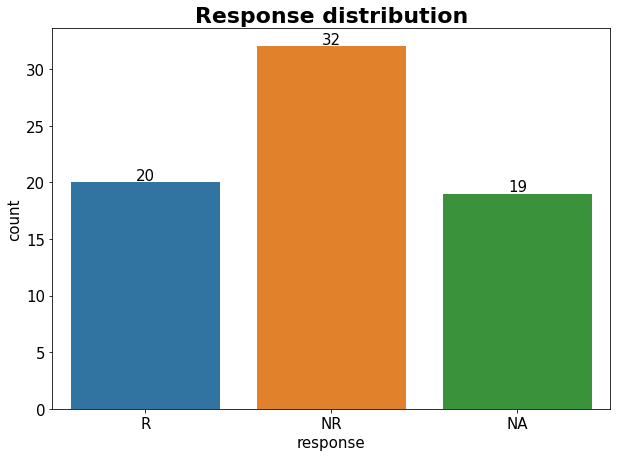

In [81]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})

melanoma_clinical_data = get_interpreted_clinical_table(ICI=False)#, response=['R', 'NR'])
melanoma_clinical_data.response = melanoma_clinical_data.response.apply(lambda x: 'NA' if x=='None' else x)

g = sns.countplot(x="response", data=melanoma_clinical_data)
plt.title('Response distribution', weight='bold', fontsize='22')
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2))
    
g.get_figure().savefig(join(OUTPUT_FOLDER, r'response_dist.png'));

melanoma_clinical_data##### (2) Biopsy time distribution

No filter on ICI, treatments, melanomaType, response

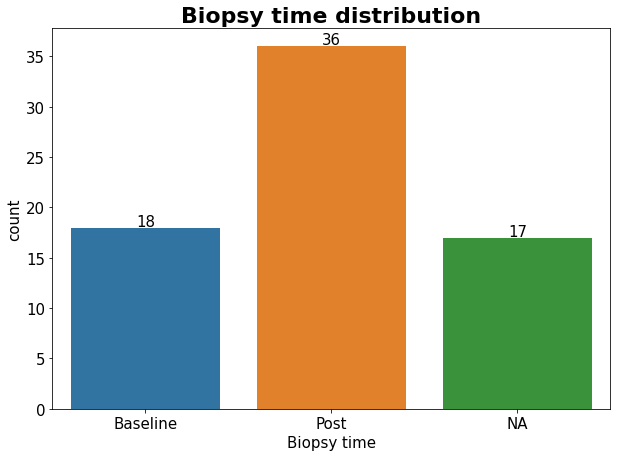

In [84]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})


melanoma_clinical_data = get_interpreted_clinical_table(ICI=False,
                                                        treatment=None)
melanoma_clinical_data = melanoma_clinical_data.rename(columns={'prePost':'Biopsy time'})
melanoma_clinical_data['Biopsy time'] = melanoma_clinical_data['Biopsy time'].apply(lambda x: 'NA' if x=='None' else x)
melanoma_clinical_data['Biopsy time'] = melanoma_clinical_data['Biopsy time'].apply(lambda x: 'Baseline' if x=='Pre' else x)


g = sns.countplot(x="Biopsy time", data=melanoma_clinical_data)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2))
# melanoma_clinical_data
plt.title('Biopsy time distribution', weight='bold', fontsize='22');
g.get_figure().savefig(join(OUTPUT_FOLDER, r'biopsy_time_dist.png'));

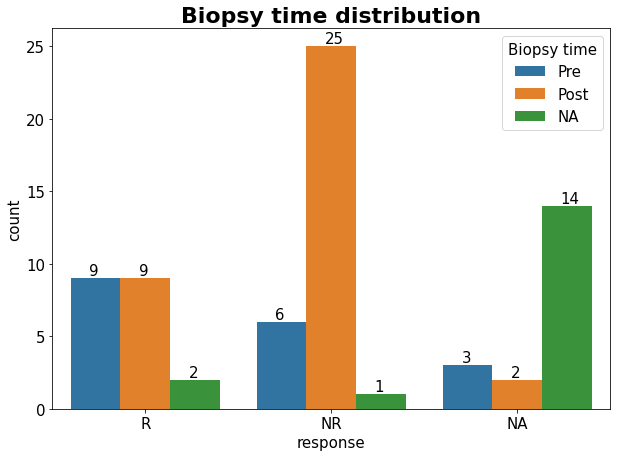

In [86]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})

melanoma_clinical_data = get_interpreted_clinical_table(ICI=False,
#                                                         response=['R', 'NR'],
                                                        treatment=None)
melanoma_clinical_data = melanoma_clinical_data.rename(columns={'prePost':'Biopsy time'})
melanoma_clinical_data.response = melanoma_clinical_data.response.apply(lambda x: 'NA' if x=='None' else x)
melanoma_clinical_data['Biopsy time'] = melanoma_clinical_data['Biopsy time'].apply(lambda x: 'NA' if x=='None' else x)


g = sns.countplot(x="response", hue='Biopsy time', data=melanoma_clinical_data)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.2))

plt.title('Biopsy time distribution', weight='bold', fontsize='22');
g.get_figure().savefig(join(OUTPUT_FOLDER, r'response_biopsy_time_dist.png'));

##### (3) Melanoma type distribution

No filter on ICI, treatments, melanomaType, response

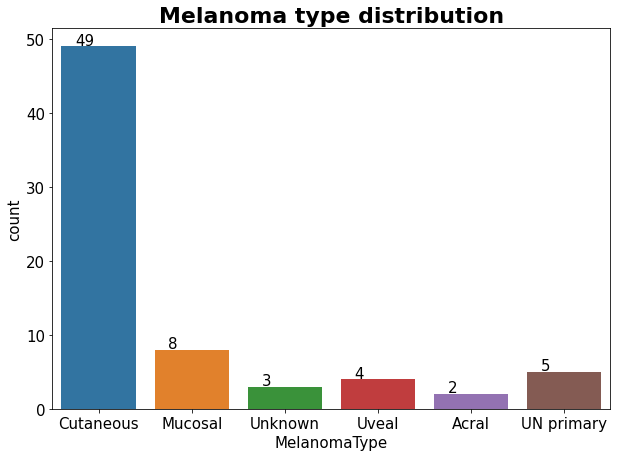

In [87]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})

melanoma_clinical_data = get_interpreted_clinical_table(ICI=False, 
#                                                         response=['R', 'NR'],
#                                                         melanomaType=['Cutaneous', 'Mucosal', 'Uveal', 'UN primary'], 
                                                        treatment=None)


g = sns.countplot(x="MelanomaType", data=melanoma_clinical_data)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.2))

    
plt.title('Melanoma type distribution', weight='bold', fontsize='22');
g.get_figure().savefig(join(OUTPUT_FOLDER, r'melanoma_type_dist.png'));

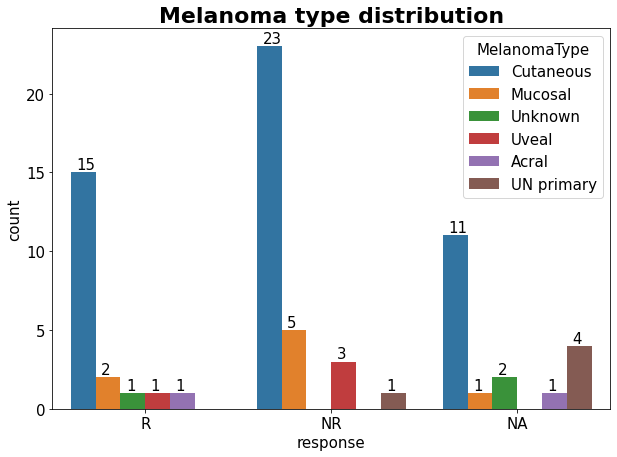

In [88]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})



melanoma_clinical_data = get_interpreted_clinical_table(ICI=False,
#                                                         response=['R', 'NR'],
                                                        treatment=None)
melanoma_clinical_data.response = melanoma_clinical_data.response.apply(lambda x: 'NA' if x=='None' else x)

g = sns.countplot(x="response", hue='MelanomaType', data=melanoma_clinical_data)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.03, p.get_height()+0.2))
plt.title('Melanoma type distribution',  weight='bold', fontsize='22');
g.get_figure().savefig(join(OUTPUT_FOLDER, r'response_melanoma_type_dist.png'));

##### (4) treatment distribution

filter on ICI, response

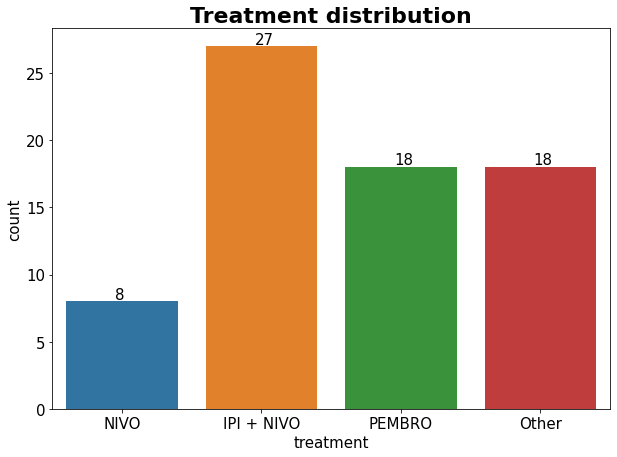

In [91]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})


melanoma_clinical_data = get_interpreted_clinical_table(ICI=False, 
#                                                         response=['R', 'NR'],
#                                                         melanomaType=['Cutaneous', 'Mucosal', 'Uveal', 'UN primary'], 
                                                        treatment=None)
melanoma_clinical_data.treatment = melanoma_clinical_data.treatment.apply(lambda x: 'Other' if x=='None' else x)
g = sns.countplot(x="treatment", data=melanoma_clinical_data)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+0.2))

plt.title('Treatment distribution',  weight='bold', fontsize='22');
g.get_figure().savefig(join(OUTPUT_FOLDER, r'Treatment_dist.png'));

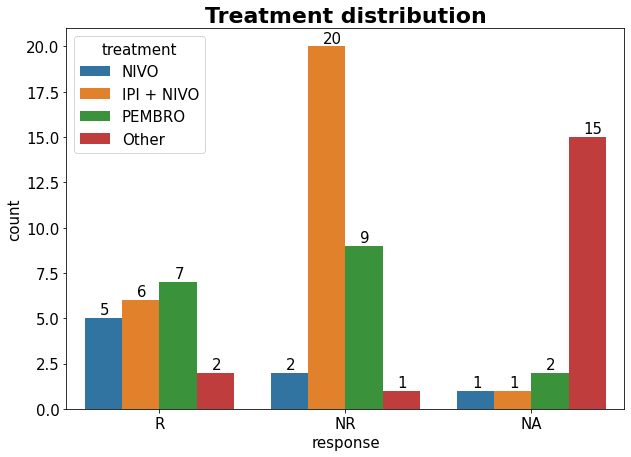

In [92]:
sns.reset_orig() # reset size of figure
plt.figure(figsize=(10, 7))# figsize
plt.rcParams.update({'font.size': 15})

melanoma_clinical_data = get_interpreted_clinical_table(ICI=False, 
#                                                         response=['R', 'NR'],
#                                                         melanomaType=['Cutaneous', 'Mucosal', 'Uveal', 'UN primary'], 
                                                        treatment=None)
melanoma_clinical_data.treatment = melanoma_clinical_data.treatment.apply(lambda x: 'Other' if x=='None' else x)
melanoma_clinical_data.response = melanoma_clinical_data.response.apply(lambda x: 'NA' if x=='None' else x)

g = sns.countplot(x = 'response', hue="treatment", data=melanoma_clinical_data)
for p in g.patches:
    g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.08, p.get_height()+0.2))
    
plt.title('Treatment distribution',  weight='bold', fontsize='22');
g.get_figure().savefig(join(OUTPUT_FOLDER, r'response_treatment_dist.png'));
    

# M2. Cells groups (1): figures


# M3. Cells groups (2): stacked plot


##### Option1: Entire cohort:

In [3]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, 
                                                        response=['R', 'NR'])

##### Option2: homogeneous set of samples. Cutaneous treated with NIVO or pembro:

In [4]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, 
                                                        response=['R', 'NR'],
#                                                         melanomaType=['Cutaneous', 'Mucosal', 'Uveal', 'UN primary'], 
                                                        treatment=['NIVO', 'PEMBRO'])

In [5]:
def get_clustering_data(clustering_path, melanoma_clinical_data, annotation_path=None):
    clustering_mapping_barcodes = pd.read_csv(clustering_path)
    clustering_mapping_barcodes = clustering_mapping_barcodes.drop(columns=[col for col in clustering_mapping_barcodes.columns if not col in ['Sample', 'Barcode', 'Cluster']])
    annotation_df = None
    if annotation_path:
        annotation_df = pd.read_excel(annotation_path).set_index('cluster')
    
    cluster_fraction = get_cluster_fraction_df(clustering_mapping_barcodes)
    cluster_fraction = cluster_fraction[cluster_fraction['sample'].isin(melanoma_clinical_data.PatientId)]
    cluster_fraction['Response'] = cluster_fraction['sample'].apply(lambda x: melanoma_clinical_data[melanoma_clinical_data.PatientId==x].response.iloc[0])
    cluster_fraction = cluster_fraction.pivot_table(index='sample', columns='cluster')
    cluster_fraction.columns = cluster_fraction.columns.get_level_values(1)
    cluster_fraction= cluster_fraction.sort_values(1)
    return clustering_mapping_barcodes, annotation_df, cluster_fraction

In [6]:
IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
IMMUNE_ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/Immune_clustering_26.6.21_ann.xlsx'
immune_clustering_mapping_barcodes, immune_annotations, immune_cluster_fraction = get_clustering_data(IMMUNE_CLUSTERING_PATH, melanoma_clinical_data, IMMUNE_ANNOTATION_PATH)


CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
CD8_ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/CD8_clustering_11.8.21_ann.xlsx'
CD8_clustering_mapping_barcodes, CD8_annotations, CD8_cluster_fraction = get_clustering_data(CD8_CLUSTERING_PATH, melanoma_clinical_data, CD8_ANNOTATION_PATH)


myeloid_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
myeloid_ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/Myeloid_clustering_11.8.21_ann.xlsx'
myeloid_clustering_mapping_barcodes, myeloid_annotations, myeloid_cluster_fraction = get_clustering_data(myeloid_CLUSTERING_PATH, melanoma_clinical_data, myeloid_ANNOTATION_PATH)

mem_exh_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'
mem_ex_CD8_clustering_mapping_barcodes, mem_ex_CD8_annotations, mem_ex_CD8_cluster_fraction = get_clustering_data(mem_exh_CD8_CLUSTERING_PATH, melanoma_clinical_data, None)
mem_ex_CD8_annotations = pd.DataFrame(['Memory CD8', 'Exhausted CD8'],columns=["annotation"], index=[1,2])

In [7]:
cluster_inf_dic = {'immune': [immune_cluster_fraction, immune_annotations], 
             'myeloid': [myeloid_cluster_fraction, myeloid_annotations],
            'CD8': [CD8_cluster_fraction, CD8_annotations],
            'Exhausted and Memory CD8': [mem_ex_CD8_cluster_fraction, mem_ex_CD8_annotations]}

In [8]:
OUTPUT_FOLDER = r'/storage/md_keren/shitay/outputs/thesis/clustering/fractions/9.6.22'

for clustering_name, clustering_inf in cluster_inf_dic.items():
    cluster_fraction = clustering_inf[0]
    annotation_df = clustering_inf[1]
    
    labels = [f'{idx+1}. {label}'  for idx,label in enumerate(annotation_df.annotation.tolist())]
    plot_stackedbar_p(cluster_fraction, labels, title=f'{clustering_name} clusters\n', 
                      subtitle='Fraction of cells per patient', 
                      file_path=join(OUTPUT_FOLDER, f'{clustering_name}_sample_fractions.png'))

    R_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.response=='R'].PatientId).values]
    NR_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.response=='NR'].PatientId).values]
    Pre_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.prePost=='Pre'].PatientId).values]
    Post_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.prePost=='Post'].PatientId).values]
    
    plot_stackedbar_p(R_cluster_fraction, labels, title=f'{clustering_name} clusters - Responder\n', 
                      subtitle='Fraction of cells per patient',
                    file_path=join(OUTPUT_FOLDER, f'{clustering_name}_R_sample_fractions.png'))

    plot_stackedbar_p(NR_cluster_fraction, labels, title=f'{clustering_name} clusters - Non-Responder\n', 
                      subtitle='Fraction of cells per patient',
                    file_path=join(OUTPUT_FOLDER, f'{clustering_name}_NR_sample_fractions.png'))

    plot_stackedbar_p(Pre_cluster_fraction, labels, title=f'{clustering_name} clusters - Pre patients\n', 
                      subtitle='Fraction of cells per patient',
                    file_path=join(OUTPUT_FOLDER, f'{clustering_name}_Pre_sample_fractions.png'))

    plot_stackedbar_p(Post_cluster_fraction, labels, title=f'{clustering_name} clusters - Post patients\n', 
                      subtitle='Fraction of cells per patient',
                    file_path=join(OUTPUT_FOLDER, f'{clustering_name}_Post_sample_fractions.png'))

    


Single stacked plot:

In [58]:
# cluster_fraction = immune_cluster_fraction
# annotation_df = immune_annotations
# clustering_name = 'Immune'

# cluster_fraction = myeloid_cluster_fraction
# annotation_df = myeloid_annotations
# clustering_name = 'myeloid'

# cluster_fraction = CD8_cluster_fraction
# annotation_df = CD8_annotations
# clustering_name = 'CD8'

OUTPUT_FOLDER = r'/storage/md_keren/shitay/outputs/thesis_visualizations/debug'
cluster_fraction = mem_ex_CD8_cluster_fraction
annotation_df = mem_ex_CD8_annotations
clustering_name = 'Exhaus_mem_CD8'

labels = [f'{idx+1}. {label}'  for idx,label in enumerate(annotation_df.annotation.tolist())]
plot_stackedbar_p(cluster_fraction, labels, title=f'{clustering_name} clusters\n', 
                  subtitle='Fraction of cells per patient', 
                  file_path=join(OUTPUT_FOLDER, f'{clustering_name}_sample_fractions.png'))

R_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.response=='R'].PatientId).values]
NR_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.response=='NR'].PatientId).values]
Pre_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.prePost=='Pre'].PatientId).values]
Post_cluster_fraction = cluster_fraction.iloc[cluster_fraction.reset_index()['sample'].isin(melanoma_clinical_data[melanoma_clinical_data.prePost=='Post'].PatientId).values]
    
plot_stackedbar_p(R_cluster_fraction, labels, title=f'{clustering_name} clusters - Responder\n', 
                  subtitle='Fraction of cells per patient',
                file_path=join(OUTPUT_FOLDER, f'{clustering_name}_R_sample_fractions.png'))

plot_stackedbar_p(NR_cluster_fraction, labels, title=f'{clustering_name} clusters - Non-Responder\n', 
                  subtitle='Fraction of cells per patient',
                file_path=join(OUTPUT_FOLDER, f'{clustering_name}_NR_sample_fractions.png'))

plot_stackedbar_p(Pre_cluster_fraction, labels, title=f'{clustering_name} clusters - Pre patients\n', 
                  subtitle='Fraction of cells per patient',
                file_path=join(OUTPUT_FOLDER, f'{clustering_name}_Pre_sample_fractions.png'))

plot_stackedbar_p(Post_cluster_fraction, labels, title=f'{clustering_name} clusters - Post patients\n', 
                  subtitle='Fraction of cells per patient',
                file_path=join(OUTPUT_FOLDER, f'{clustering_name}_Post_sample_fractions.png'))

    

# M5. GEPS: pathways


Liron tables:

smartseq:

k_15 - AXL program - 13

k_18 - AXL program - 2


dropseq: (contaminated)

K_24 - AXL program - 14

K_25 - AXL program - 11


In [4]:
GEPS_PATH = r'/storage/md_keren/shitay/outputs/thesis/GEPS_complementary/cohort_5.5.22_GEP_top_100_genes.xlsx'
LIRON_GEPS_PATH = r'/storage/md_keren/shitay/outputs/thesis/GEPS_complementary/Liron_k15_GEP_top_100_genes.xlsx'

geps_df = pd.read_excel(GEPS_PATH).T
liron_geps_df = pd.read_excel(LIRON_GEPS_PATH).T

In [6]:
LIRON_USAGES_PATH = r'/storage/md_keren/shitay/outputs/thesis/GEPS_complementary/Liron_k15_normalized_usages.xlsx'
liron_usages_df = pd.read_excel(LIRON_USAGES_PATH)

In [7]:
overlaps = []
for GEP_name, GEP_genes in geps_df.iterrows():
    GEP_markers = GEP_genes.tolist()
    for liron_GEP_name, liron_GEP_genes in liron_geps_df.iterrows():
        liron_GEP_markers = liron_GEP_genes.tolist()
        overlap_size = len([gg for gg in liron_GEP_markers if gg in GEP_markers])
        overlaps += [[GEP_name, liron_GEP_name, overlap_size]]

In [8]:
### see for each program in liron table, see the compatible progrm in our table with the biggest overlap

overlaps_df = pd.DataFrame(overlaps, columns=['GEP', 'LIRON_GEP', 'overlaps'])
# overlaps_df.loc[overlaps_df.groupby(["LIRON_GEP"])["overlaps"].idxmax()].sort_values('LIRON_GEP').reset_index(drop=True)


In [9]:
### given the program_idx in liron table see size of overlap over all our programs 

liron_GEP_IDX = 'GEP13' 
# overlaps_df[overlaps_df.LIRON_GEP==liron_GEP_IDX]

In [10]:
### given the AXLprogram_idx in liron table see Amount of cells express the AXL program

liron_GEP_IDX = 13
usage_threshold = 0.05

n_AXL_cells = sum(liron_usages_df[liron_GEP_IDX] > usage_threshold)
n_cells = len(liron_usages_df)

print(f'Liron AXL program:')
print(f'{n_AXL_cells}/{n_cells} cells')
print(f'{(n_AXL_cells/n_cells)*100}% of the tumor cells')

Liron AXL program:
1228/5088 cells
24.135220125786162% of the tumor cells


In [11]:
### see which gene are in overlap
GEP_IDX = 'GEP16'
liron_GEP_IDX = 'GEP13'
GEP_markers = geps_df.loc[GEP_IDX].tolist()
liron_GEP_markers = liron_geps_df.loc[liron_GEP_IDX].tolist()

# [(idx, gg) for idx, gg in enumerate(liron_GEP_markers) if gg in GEP_markers]

#### geneAnalytics ERK and AKT signaling - see overlap with genes

In [13]:
ERK_signaling_genes_PATH = r'/storage/md_keren/shitay/outputs/thesis/GEPS_complementary/ERK_signaling_genes.txt'
AKT_signaling_genes_PATH = r'/storage/md_keren/shitay/outputs/thesis/GEPS_complementary/AKT_signaling_genes.txt'


def extract_signaling_gene_from_file(signaling_gene_PATH):
    with open(signaling_gene_PATH) as f:
        lines = f.readlines()
        lines = [o_line.replace('\n', '') for o_line in flatten_list([line.split('\t') for line in lines])]
        signaling_genes = lines
    return signaling_genes

ERK_signaling_genes = extract_signaling_gene_from_file(ERK_signaling_genes_PATH)
AKT_signaling_genes = extract_signaling_gene_from_file(AKT_signaling_genes_PATH)

In [14]:
# AKT_signaling_pathways = ['ACVR1', 'ACVR2B', 'ACVRL1', 'ANGPT1', 'ANGPT2', 'ANGPT4', 'ANGPTL1', 'ANGPTL6', 'AREG', 'BAX', 'BCL2', 'BDNF', 'CXCR5', 'BMP1', 'BMP10', 'BMP15', 'BMP2', 'BMP3', 'BMP4', 'BMP5', 'BMP6', 'BMP7', 'BMP8B', 'BMP8A', 'BMPR1A', 'BMPR1B', 'BMPR2', 'BTC', 'BTK', 'CCL1', 'CCL11', 'CCL13', 'CCL14', 'CCL15', 'CCL16', 'CCL17', 'CCL18', 'CCL19', 'CCL2', 'CCL20', 'CCL21', 'CCL22', 'CCL23', 'CCL24', 'CCL25', 'CCL26', 'CCL27', 'CCL28', 'CCL3', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CCR9', 'CCRL2', 'CD2', 'CD28', 'CD4', 'CD80', 'CSF1R', 'CSF2RA', 'CSF2RB', 'CSF3R', 'CCN2', 'CX3CR1', 'CXCL12', 'CXCR3', 'CXCR4', 'CXCR6', 'LEFTY2', 'TYMP', 'EGF', 'EGFR', 'EPOR', 'ERBB2', 'ERBB3', 'ERBB4', 'FGF1', 'FGF10', 'FGF11', 'FGF12', 'FGF13', 'FGF14', 'FGF16', 'FGF17', 'FGF18', 'FGF19', 'FGF2', 'FGF20', 'FGF21', 'FGF22', 'FGF23', 'FGF4', 'FGF5', 'FGF6', 'FGF7', 'FGF8', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'VEGFD', 'FPR2', 'GAS1', 'GAS2', 'GAS6', 'GAS8', 'GDF10', 'GDF2', 'GDF5', 'GDF6', 'GDF9', 'GFER', 'GH1', 'GH2', 'GHRH', 'GMFG', 'GNA11', 'GNA12', 'GNA13', 'GNA14', 'GNA15', 'GNAS', 'GNB1', 'GNB2', 'GNB3', 'GNB4', 'GNB5', 'GNG2', 'GNG3', 'GNG4', 'GNRH1', 'GNRH2', 'GPC6', 'CCR10', 'HDGF', 'HGF', 'HRH4', 'IGF1', 'IGF1R', 'IGF2', 'IGF2 - AS', 'IL10', 'IL10RA', 'IL10RB', 'IL11', 'IL11RA', 'IL12A', 'IL12B', 'IL12RB1', 'IL12RB2', 'IL13', 'IL13RA1', 'IL13RA2', 'IL15', 'IL15RA', 'IL16', 'IL17A', 'IL17RA', 'IL17RC', 'IL18', 'IL18R1', 'IL19', 'IL1A', 'IL1B', 'IL1R1', 'IL2', 'IL20', 'IL20RA', 'IL22', 'IL22RA1', 'IL23A', 'IL23R', 'IL24', 'IL26', 'IL2RA', 'IL2RB', 'IL2RG', 'IL3', 'IL3RA', 'IL4', 'IL4R', 'IL5', 'IL5RA', 'IL6', 'IL6R', 'IL7', 'IL7R', 'CXCL8', 'CXCR1', 'CXCR2', 'IL9', 'IL9R', 'INSR', 'KITLG', 'LEFTY1', 'LHB', 'LIFR', 'NRG4', 'LTBP1', 'LTBP2', 'LTBP3', 'LTBP4', 'MDK', 'MET', 'NGF', 'NGFR', 'NRG1', 'NRG2', 'NRG3', 'NTF3', 'NTF4', 'NTRK1', 'NTRK2', 'NTRK3', 'NUDT6', 'OGN', 'OSMR', 'PDGFA', 'PDGFB', 'PDGFC', 'PDGFRA', 'PDGFRB', 'PENK', 'PGF', 'GDF15', 'PLPP3', 'PPBP', 'PROK1', 'PSIP1', 'PTN', 'PDGFD', 'CLEC11A', 'NPTN', 'SEMA3A', 'SEMA4B', 'SEMA4G', 'SEMA5A', 'SPON1', 'TBRG1', 'TDGF1', 'TEK', 'TGFA', 'TGFB1', 'TGFB2', 'TGFB3', 'THPO', 'TIE1', 'KLF10', 'TIMP1', 'TIMP2', 'TIMP3', 'TIMP4', 'TNF', 'TNFAIP6', 'TNFRSF10A', 'TNFRSF10B', 'TNFRSF10C', 'TNFRSF10D', 'TNFRSF11A', 'TNFRSF25', 'TNFRSF12A', 'TNFRSF13B', 'TNFRSF13C', 'TNFRSF14', 'TNFRSF17', 'TNFRSF18', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF21', 'TNFRSF4', 'CD40', 'FAS', 'CD27', 'TNFRSF8', 'TNFRSF9', 'TNFSF10', 'TNFSF12', 'TNFSF13B', 'FASLG', 'UTS2', 'VEGFB', 'VEGFC', 'XCR1', 'ALK', 'AXL', 'CCL4L1', 'CCL4L2', 'CER1', 'CREB1', 'CSF1', 'CSF2', 'CSF3', 'CX3CL1', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL13', 'CXCL14', 'CXCL16', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCL9', 'DAP', 'DDR1', 'DDR2', 'EPHA1', 'EPHA2', 'EPHA3', 'EPHA4', 'EPHA5', 'EPHA7', 'EPHA8', 'EPHB1', 'EPHB2', 'EPHB3', 'EPHB4', 'EPHB6', 'FLT1', 'FLT3', 'FLT4', 'GNAI1', 'GNAI2', 'GNAI3', 'GNAL', 'HRAS', 'IL21', 'INSRR', 'ITGA1', 'ITGA10', 'ITGA11', 'ITGA2', 'ITGA2B', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'ITGA8', 'ITGA9', 'ITGAD', 'ITGAE', 'ITGAL', 'ITGAM', 'ITGAV', 'ITGAX', 'ITGB1', 'ITGB2', 'ITGB3', 'ITGB4', 'ITGB5', 'ITGB6', 'ITGB7', 'ITGB8', 'JAK1', 'KDR', 'KIT', 'KRAS', 'LIF', 'LMTK2', 'LMTK3', 'LTA', 'MAP3K5', 'MERTK', 'MRAS', 'MST1R', 'MUSK', 'NRAS', 'OSM', 'PIK3R5', 'PF4', 'PF4V1', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R4', 'PIP', 'PPBPP2', 'PTK2', 'PTK2B', 'PTK7', 'ROR1', 'ROR2', 'ROS1', 'RRAS', 'RRAS2', 'RYK', 'SYK', 'TNFSF11', 'TNFSF13', 'TNFSF14', 'TNFSF18', 'TNFSF4', 'CD40LG', 'CD70', 'TNFSF8', 'TNFSF9', 'TP53', 'TYRO3', 'CD3D', 'CD3E', 'CD3G', 'CD247', 'CDC42', 'IRAK1', 'NFKB1', 'PAK1', 'PLCG1', 'PLCG2', 'PRKCA', 'PRKCB', 'PRKCD', 'PRKCE', 'PRKCG', 'PRKCH', 'RAC1', 'STAT1', 'AKT1', 'AKT1S1', 'AKT2', 'AKT3', 'AR', 'ATF4', 'BAD', 'XIAP', 'CASP9', 'CCND1', 'CCND2', 'CCND3', 'CDC37', 'CDKN1A', 'CDKN1B', 'CHEK1', 'CHUK', 'CREB3', 'CREB3L4', 'THEM4', 'BCAP31', 'ATXN10', 'EIF4E', 'EIF4EBP1', 'FOXO1', 'MTOR', 'GAB1', 'GAB2', 'GABRA1', 'GABRA2', 'GABRA3', 'GABRA4', 'GABRA5', 'GABRA6', 'GABRB1', 'GABRB2', 'GABRB3', 'GABRD', 'GABRE', 'GABRG1', 'GABRG2', 'GABRG3', 'GABRQ', 'GPR119', 'P2RY13', 'GSK3A', 'GSK3B', 'GYS1', 'GYS2', 'HTT', 'HSP90AA1', 'IKBKB', 'IKBKE', 'IKBKG', 'ILK', 'IRS1', 'MAPK8IP1', 'MDM2', 'ATXN3', 'NCF1', 'NOS3', 'PDE3B', 'PDPK1', 'PFKFB1', 'PFKFB2', 'PFKFB3', 'PFKFB4', 'PFKL', 'PFKM', 'PFKP', 'PIK3CG', 'PPP2CA', 'PPP2CB', 'PPP2R1A', 'PPP2R1B', 'PPP2R2A', 'PPP2R2B', 'PPP2R2C', 'PPP2R3A', 'PTPA', 'PPP2R5A', 'PPP2R5B', 'PPP2R5C', 'PPP2R5D', 'PPP2R5E', 'PPP2R3B', 'PRKDC', 'WNK1', 'PTEN', 'PXN', 'RAF1', 'RPS6KB1', 'ATXN1', 'ATXN2', 'ATXN7', 'SLC2A4', 'TSC1', 'TSC2', 'YAP1', 'YWHAB', 'YWHAE', 'YWHAG', 'YWHAH', 'YWHAQ', 'YWHAZ', 'AP2A1', 'ARHGEF7', 'ATF2', 'CASP3', 'CASP6', 'CDC25C', 'CEBPA', 'CEBPG', 'DAXX', 'DDIT3', 'ELK1', 'ELK4', 'ETV1', 'FOSL1', 'GNAO1', 'GNAT1', 'GNAT2', 'GNAZ', 'GNG10', 'GNG11', 'GNG12', 'GNG13', 'GNG5', 'GNG7', 'GNG8', 'GNGT1', 'GNGT2', 'GRB2', 'HSPB1', 'IL1R2', 'IRAK2', 'IRAK3', 'IRAK4', 'JUNB', 'JUND', 'LCK', 'MAP2K3', 'MAP2K6', 'MAP3K10', 'MAP3K3', 'MAP3K4', 'MAP3K7', 'TAB1', 'TAB2', 'MAP3K8', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPK8IP2', 'MAPKAPK2', 'MAPKAPK3', 'MAPKAPK5', 'MAX', 'MEF2A', 'MEF2C', 'MEF2D', 'MKNK1', 'MKNK2', 'PLCB1', 'PLCB2', 'PLCB3', 'PLCB4', 'PLCD1', 'PLCD3', 'PLCD4', 'PLCE1', 'PLCZ1', 'PRKCI', 'PRKD1', 'PRKD3', 'PRKCQ', 'PRKCZ', 'RALA', 'RALB', 'RALGDS', 'RIPK1', 'RPS6KA5', 'SOS1', 'SOS2', 'SP1', 'SPAG9', 'SRC', 'TGFBR1', 'TRADD', 'TRAF2', 'TRAF6', 'ZAP70', 'ACTA1', 'ACTA2', 'ACTB', 'ACTG1', 'ACTG2', 'RHOA', 'RHOB', 'RHOC', 'RHOD', 'RND3', 'RHOG', 'RHOH', 'DIRAS3', 'RHOJ', 'RND2', 'RHOQ', 'BMX', 'FADD', 'FCER1A', 'FCER1G', 'FOS', 'GTF2I', 'ITK', 'JAK2', 'JAK3', 'LAT', 'LCP2', 'MAPK10', 'MAPK8', 'MAPK9', 'MYD88', 'PAK2', 'PAK3', 'PAK4', 'PAK6', 'PAK5', 'RAC2', 'RAC3', 'STAT2', 'STAT3', 'STAT4', 'STAT5A', 'STAT5B', 'STAT6', 'TEC', 'TIRAP', 'TLR1', 'TLR10', 'TLR2', 'TLR3', 'TLR4', 'TLR5', 'TLR6', 'TLR7', 'TLR8', 'TLR9', 'TXK', 'VAV1', 'VAV2', 'VAV3', 'WAS']

In [15]:
signaling_genes = AKT_signaling_genes
# signaling_genes = ERK_signaling_genes

overlaps = []
for GEP_name, GEP_genes in geps_df.iterrows():
    GEP_markers = GEP_genes.tolist()
    overlap_size = len([gg for gg in signaling_genes if gg in GEP_markers])
    overlaps += [[GEP_name, overlap_size]]
    
overlaps_df = pd.DataFrame(overlaps, columns=['GEP', 'overlap'])

In [16]:
# overlaps_df

### Validate that program 12 is the AXL program by examining the expression of AXL

##### Extract tumor cohort

In [9]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [10]:
tumor_cohort = cohort[cohort.cells_information.getattr('is_cancer')]

In [19]:
print(f'AXL index: {tumor_cohort.gene_names.index("AXL")}')
print(f'Number of tumor cells: {tumor_cohort.number_of_cells}')

AXL index: 12030
Number of tumor cells: 131553


##### Extract GEP files

In [35]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_5.5.22'#/k30_2000genes_200iter'
RUN_NAME = f'k21_2000genes_200iter'
USAGES_CONSENSUS_FILE = f'k21_2000genes_200iter.usages.k_21.dt_0_10.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,22)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix['sample'] = [uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]
normalized_usage_matrix['barcode'] = [uu.split('_')[1] for uu in list(normalized_usage_matrix.index)]

In [37]:
# normalized_usage_matrix

In [42]:
### given the AXLprogram_idx in liron table see Amount of cells express the AXL program
GEP_IDX = 12
usage_threshold = 0.05

n_AXL_cells = sum(normalized_usage_matrix[GEP_IDX] > usage_threshold)
n_cells = len(normalized_usage_matrix)

print(f'AXL program:')
print(f'{n_AXL_cells}/{n_cells} cells')
print(f'{(n_AXL_cells/n_cells)*100}% of the tumor cells')

AXL program:
7562/131553 cells
5.748253555601165% of the tumor cells


In [176]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True,
                                                        response=['R', 'NR'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('PatientId')

In [177]:
# normalized_usage_matrix[6]
AXL_pathway_cells_df = normalized_usage_matrix[normalized_usage_matrix[12] > 0.1][['sample', 'barcode']]
print(f'Number of AXL cells: {len(AXL_pathway_cells_df)}')

Number of AXL cells: 2894


#### Compare the distribution of AXL expression in AXL program's cells and outside:

In [178]:
AXL_cohort = tumor_cohort.get_subset_by_identifiers(AXL_pathway_cells_df['sample'], AXL_pathway_cells_df.barcode)
Non_AXL_cohort = tumor_cohort.filter_cohort_from(AXL_pathway_cells_df['sample'], AXL_pathway_cells_df.barcode)

In [179]:
AXL_cohort.number_of_cells
AXL_cohort.counts[:, AXL_cohort.gene_names.index('AXL')].mean()
Non_AXL_cohort.counts[:, AXL_cohort.gene_names.index('AXL')].mean()

0.054032942966453244

In [180]:
axl_cells_exp_df = pd.DataFrame([AXL_cohort.counts[:, AXL_cohort.gene_names.index('AXL')], ['program 12']*AXL_cohort.number_of_cells]).T.append(pd.DataFrame([Non_AXL_cohort.counts[:, AXL_cohort.gene_names.index('AXL')], ['Other programs']*Non_AXL_cohort.number_of_cells]).T)
axl_cells_exp_df = axl_cells_exp_df.rename(columns={0:'Expression',1:'Group'})

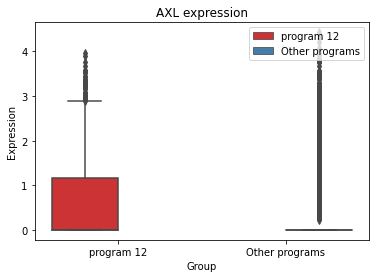

In [181]:
sns.reset_orig() # reset size of figure
sns.boxplot(y="Expression", x='Group', hue='Group',  palette="Set1", data=axl_cells_exp_df).set(title='AXL expression');
plt.legend(loc='upper right');


### M5. part 2: analysis AXL and Melan-A programs
cohort 5.5.22 - tumor cells

21 programs - files and all material related are in milestone_16 folder.

The program of Melan-A is number 6.

The program of AXL is number 12.

In [190]:
# melanoma_clinical_data

In [97]:
pd.set_option('display.max_rows', 10)
normalized_usage_matrix[[6,12]].sort_values(12).iloc[-2500:]

6         12
M106_CCCATACGTACCGAGA-1  0.050505  0.111774
M141_CGGGTCACAGGTTTCA-1  0.057661  0.111947
M157_AAGACCTAGGCTAGGT-1  0.078798  0.112006
M161_GTGCATAGTCTTCTCG-1  0.060733  0.112050
M148_CATCAGAGTGGTCCGT-1  0.000000  0.112089
...                           ...       ...
M168_CTTCTCTGTAAACACA-1  0.000000  0.983483
M168_CGTTGGGTCTCTAGGA-1  0.000000  0.985606
M168_GCATGTACACCACGTG-1  0.000000  0.999101
M168_CAAGTTGAGTGAACAT-1  0.000000  0.999844
M168_TGACAACGTAGCGTAG-1  0.000000  1.000000

[2500 rows x 2 columns]

In [78]:
ratios = normalized_usage_matrix[6] / normalized_usage_matrix[12]
# plt.boxplot(ratios[ratios.values!=np.inf])
# Counter(ratios[ratios.values!=np.inf])
ratios[ratios.values!=np.inf][9]
ratios[:10]

M100_AAACCTGAGAAACCAT-1           inf
M100_AAACCTGAGACGCAAC-1           inf
M100_AAACCTGAGGATTCGG-1           inf
M100_AAACCTGAGGGCATGT-1           inf
M100_AAACCTGCACGAGAGT-1           inf
M100_AAACCTGGTATAAACG-1      0.000000
M100_AAACCTGGTATTAGCC-1           inf
M100_AAACCTGGTTAGGGTG-1      8.056597
M100_AAACCTGTCCCAACGG-1           inf
M100_AAACGGGGTACTCTCC-1    161.873107
dtype: float64

In [187]:
normalized_usage_matrix[[6,12]][ratios.values!=np.inf].iloc[9]


6     0.0
12    0.0
Name: M100_AAAGTAGCATCGGAAG-1, dtype: float64

### Starts here

#### Option 1: entire cohort:

In [182]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True,
                                                        response=['R', 'NR'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('PatientId')

#### Option 2: homogeneous set of samples.

In [183]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, 
                                                        response=['R', 'NR'],
                                                        melanomaType=['Cutaneous'], 
                                                        treatment=['NIVO', 'PEMBRO'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('PatientId')

In [449]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_5.5.22'#/k30_2000genes_200iter'
RUN_NAME = f'k21_2000genes_200iter'
USAGES_CONSENSUS_FILE = f'k21_2000genes_200iter.usages.k_21.dt_0_10.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,22)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix['sample'] = [uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]
normalized_usage_matrix['barcode'] = [uu.split('_')[1] for uu in list(normalized_usage_matrix.index)]

In [450]:
usage_min_threshold = 0.1
melan_a_idx = 6
axl_idx = 12

normalized_usage_matrix[f'is_p{melan_a_idx}_related'] = normalized_usage_matrix[melan_a_idx] > usage_min_threshold
normalized_usage_matrix[f'is_p{axl_idx}_related'] = normalized_usage_matrix[axl_idx] > usage_min_threshold

In [451]:
normalized_usage_matrix['n_MLANA'] = normalized_usage_matrix[f'is_p{melan_a_idx}_related'] & ~normalized_usage_matrix[f'is_p{axl_idx}_related']
normalized_usage_matrix['n_AXL'] = ~normalized_usage_matrix[f'is_p{melan_a_idx}_related'] & normalized_usage_matrix[f'is_p{axl_idx}_related']
normalized_usage_matrix['n_MLANA_and_AXL'] = normalized_usage_matrix[f'is_p{melan_a_idx}_related'] & normalized_usage_matrix[f'is_p{axl_idx}_related']
normalized_usage_matrix['n_NOT_signaling'] = ~normalized_usage_matrix[f'is_p{melan_a_idx}_related'] & ~normalized_usage_matrix[f'is_p{axl_idx}_related']

Add response

In [452]:
MLAN_AXL_df = normalized_usage_matrix.groupby('sample').sum()[['n_MLANA', 'n_AXL', 'n_MLANA_and_AXL', 'n_NOT_signaling']].reset_index()

MLAN_AXL_df = MLAN_AXL_df[MLAN_AXL_df['sample'].isin(melanoma_clinical_data.PatientId)]
MLAN_AXL_df['response'] = MLAN_AXL_df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x].response)


In [453]:
pd.set_option('display.max_rows', 5)
mlan_portion = MLAN_AXL_df['n_MLANA'] / MLAN_AXL_df[['n_MLANA', 'n_AXL', 'n_MLANA_and_AXL', 'n_NOT_signaling']].sum(axis=1)
axl_portion = MLAN_AXL_df['n_AXL'] / MLAN_AXL_df[['n_MLANA', 'n_AXL', 'n_MLANA_and_AXL', 'n_NOT_signaling']].sum(axis=1)

MLAN_AXL_df['Melan-A'] = mlan_portion
MLAN_AXL_df['AXL'] = axl_portion

In [454]:
pd.set_option('display.max_rows', 100)
# MLAN_AXL_df

##### Pearson correlation of AXL with Melan-A fractions:

In [455]:
pd.set_option('display.max_rows', None)
print(f'Pearson correlation of AXL with Melan-A fractions:')
coeff, pval = scipy.stats.pearsonr(MLAN_AXL_df['Melan-A'], MLAN_AXL_df.AXL)
print(f'coeff: {coeff}, pval: {pval}')

Pearson correlation of AXL with Melan-A fractions:
coeff: -0.36304416607316037, pval: 0.011208637574995212


0.06233062330623306

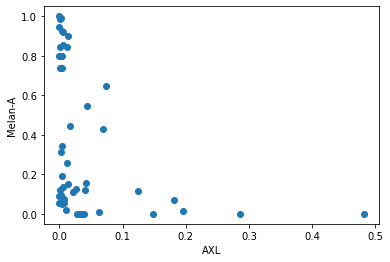

In [456]:
plt.scatter(MLAN_AXL_df.AXL, MLAN_AXL_df['Melan-A'])
plt.xlabel('AXL')
plt.ylabel('Melan-A')
MLAN_AXL_df.AXL.iloc[-1]

#### By response

In [457]:
melt_MLAN_AXL_df = MLAN_AXL_df.melt(id_vars=["sample", 'n_MLANA', 'n_AXL', 'n_MLANA_and_AXL', 'n_NOT_signaling', 'response'], 
                                    var_name="pathway", 
                                    value_name="fraction").sort_values('sample')

In [458]:
pd.set_option('display.max_rows', None)
# MLAN_AXL_df.sort_values('AXL')

In [459]:
_, AXL_pval = ranksums(MLAN_AXL_df[MLAN_AXL_df.response=='R'].AXL, MLAN_AXL_df[MLAN_AXL_df.response=='NR'].AXL)
_, MLAN_pval = ranksums(MLAN_AXL_df[MLAN_AXL_df.response=='R']['Melan-A'], MLAN_AXL_df[MLAN_AXL_df.response=='NR']['Melan-A'])

print(f'Ranksum test of AXL, pval: {AXL_pval}')
print(f'Ranksum test of Melan-A, pval: {MLAN_pval}')

Ranksum test of AXL, pval: 0.6742221285650014
Ranksum test of Melan-A, pval: 0.4313822063469567


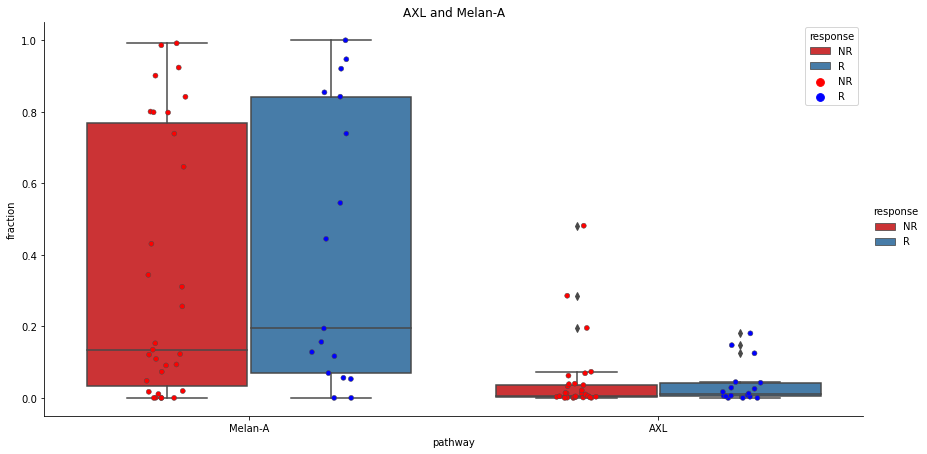

In [460]:
ax = sns.catplot(kind="box", x='pathway', y='fraction', hue='response', data=melt_MLAN_AXL_df, palette="Set1",height=6, aspect=2.0).set(title="AXL and Melan-A");
sns.stripplot(x='pathway', y='fraction', hue='response', data=melt_MLAN_AXL_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

In [461]:
MLAN_AXL_df.to_excel(r'/storage/md_keren/shitay/garbage/AXL.xlsx')

#### Ratio AXL/MELAN-A ranksum test:

In [462]:
MLAN_AXL_df['ratio'] = ( MLAN_AXL_df['Melan-A']+0.01) / (MLAN_AXL_df['AXL']+0.01)

_, pval = ranksums(MLAN_AXL_df[MLAN_AXL_df.response=='R'].ratio, MLAN_AXL_df[MLAN_AXL_df.response=='NR'].ratio)

print(f'Ranksum test of Melan-A, pval: {pval}')

Ranksum test of Melan-A, pval: 0.8042079864626045


### M5. GEPS - MITF

In [ ]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort[cohort.cells_information.getattr('is_cancer')]

option (1) Entire cohort:

In [5]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True,
                                                        response=['R', 'NR'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('PatientId')

option (2) Cutaneous samples:

In [6]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, 
                                                        response=['R', 'NR'],
#                                                         treatment=['NIVO', 'PEMBRO'],
                                                        melanomaType=['Cutaneous'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('PatientId')

In [13]:
def get_percent_gene(cohort, gene_name):
    gene_threshold = 1
    gene_idx = cohort.gene_names.index(gene_name)
    df = pd.DataFrame(np.array([cohort.samples, cohort.counts[:,gene_idx]]).T, columns=['sample', 'exp'])
    df.exp = df.exp.astype(float) > gene_threshold
    d1 = df.groupby('sample').sum().reset_index().rename(columns={'exp':f'c_{gene_name}'})
    d2 = df.groupby('sample').count().reset_index().rename(columns={'exp':'general_count'})

    merged_df = d1.merge(d2, left_on='sample', right_on='sample')
    merged_df[f'p_{gene_name}'] = merged_df[f'c_{gene_name}'] / merged_df.general_count
    return merged_df.drop(columns=['general_count'])

def get_percent_genes(cohort, genes):
    df = get_percent_gene(cohort, genes[0])
    for gene in genes[1:]:
        df = df.merge(get_percent_gene(cohort, gene), left_on='sample', right_on='sample')
    return df
# get_percent_gene(tumor_cohort, 'MLANA').merge(f(tumor_cohort, 'AXL'), left_on='sample', right_on='sample')


In [14]:
gene_A = 'MITF'
gene_B = 'AXL'
gene_C = 'MLANA'

fraction_gene_df = get_percent_genes(tumor_cohort, [gene_A, gene_B, gene_C])

In [15]:
filtered_fraction_gene_df = fraction_gene_df[fraction_gene_df['sample'].isin(melanoma_clinical_data.PatientId)]
filtered_fraction_gene_df['response'] = filtered_fraction_gene_df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x].response)

sample fractions of cells expressing genes:

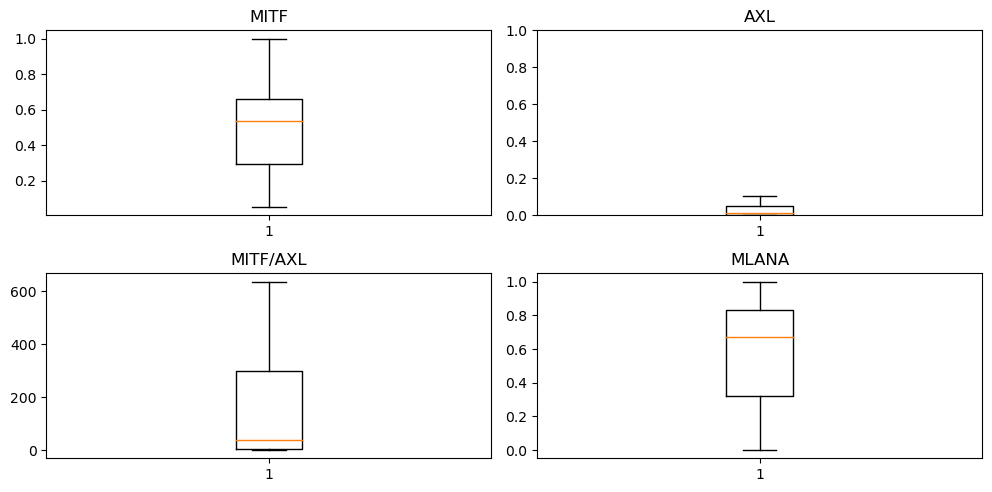

In [20]:
plt.rcdefaults()  # reset params

(fig,axes) = plt.subplots(2, 2, figsize=(10, 5))
axes = axes.ravel()


axes[0].boxplot(filtered_fraction_gene_df[f'p_{gene_A}'], showfliers=False);
axes[1].boxplot(filtered_fraction_gene_df[f'p_{gene_B}'], showfliers=False);
axes[2].boxplot(filtered_fraction_gene_df[f'p_{gene_A}'] / filtered_fraction_gene_df[f'p_{gene_B}'], showfliers=False);
axes[3].boxplot(filtered_fraction_gene_df[f'p_{gene_C}'], showfliers=False);

axes[0].set(title=gene_A);
axes[1].set(title=gene_B);
axes[1].set(ylim=[0, 1]);
axes[2].set(title=f'{gene_A}/{gene_B}');
axes[3].set(title=gene_C);


plt.tight_layout(pad=1)
# axes[-1].remove()

In [43]:
filtered_fraction_gene_df['ratio'] = filtered_fraction_gene_df.apply(lambda x: (x.p_AXL+0.01)/(x.p_MITF+0.01), axis=1)#[f'p_{gene_A}']
# filtered_fraction_gene_df[f'p_{gene_B}']
_, pval = ranksums(filtered_fraction_gene_df[filtered_fraction_gene_df.response=='R'].ratio, filtered_fraction_gene_df[filtered_fraction_gene_df.response=='NR'].ratio)
display(filtered_fraction_gene_df.head(3))
pval

sample  c_MITF    p_MITF  c_AXL     p_AXL  c_MLANA   p_MLANA response  \
0   M100    1958  0.713817      1  0.000365     2294  0.836311       NR   
4   M104      99  0.052744    578  0.307938        0  0.000000       NR   
6   M106    1909  0.600881      3  0.000944     2917  0.918162       NR   

      ratio  
0  0.014319  
4  5.067250  
6  0.017916

0.8527533813946728

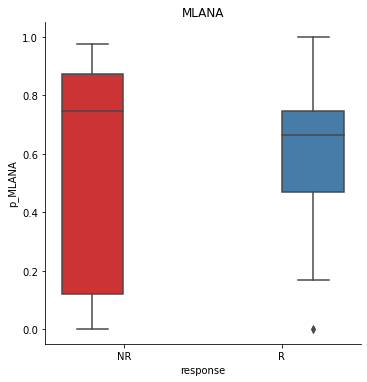

In [222]:
plt.rcdefaults()  # reset params
sns.reset_orig() # reset size of figure
gene = gene_C
ax = sns.catplot(kind="box", x='response', y=f'p_{gene}', hue='response', data=filtered_fraction_gene_df, palette="Set1").set(title=gene);
# sns.stripplot(x='pathway', y='fraction', hue='response', data=melt_MLAN_AXL_df,
#               jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

MITF and AXL:

Y - R

B - NR

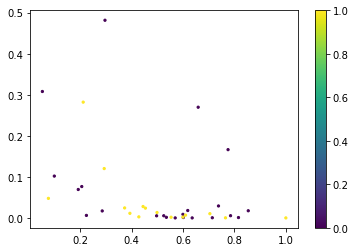

In [241]:
c = filtered_fraction_gene_df.response.apply(lambda x: 1 if x=='R' else 0).values
sc = plt.scatter(filtered_fraction_gene_df[f'p_{gene_A}'], filtered_fraction_gene_df[f'p_{gene_B}'], s=5, c=c);
plt.colorbar(sc);

MELAN-A and AXL:

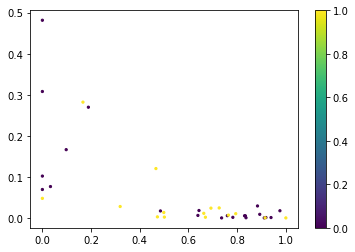

In [245]:
c = filtered_fraction_gene_df.response.apply(lambda x: 1 if x=='R' else 0).values
sc = plt.scatter(filtered_fraction_gene_df[f'p_{gene_C}'], filtered_fraction_gene_df[f'p_{gene_B}'], s=5, c=c);
plt.colorbar(sc);


# M6. Present ratio of immune cells to tumor cells in samples, and look for enrichment of immune cells in R


In [4]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [5]:
sum(cohort.cells_information.getattr('is_immune'))
sum(cohort.cells_information.getattr('is_cancer'))
sum(cohort.cells_information.getattr('is_stromal'))

33897

In [6]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True,
                                                        response=['R', 'NR'])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('PatientId')

In [7]:
from anndata import AnnData
ann_cohort = cohort.convert_to_AnnData()
cohort_df = ann_cohort.obs.copy()

In [8]:
cohort_df['T cells'] = cohort_df.cell_type_list.apply(lambda x: 'T cells' in x)
cohort_df['B cells'] = cohort_df.cell_type_list.apply(lambda x: 'B cells' in x)

In [9]:
# B_cells_cluster_idx = 1
# IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'

# #######################
# immune_clustering_mapping_barcodes = pd.read_csv(IMMUNE_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
# B_cells_barcodes = [tuple(aa) for aa in immune_clustering_mapping_barcodes[immune_clustering_mapping_barcodes.Cluster==B_cells_cluster_idx][['Sample', 'Barcode']].values.tolist()]
# cohort_df['B cells cluster'] = cohort_df.apply(lambda x: (x['sample'], x['barcode']) in B_cells_barcodes, axis=1)

#### Builds cohort_dfs of % and #:

In [10]:
filtered_cohort_df = cohort_df[cohort_df['sample'].isin(res_melanoma_clinical_data.index.tolist())]


In [11]:
proportions_cohort_df = filtered_cohort_df.groupby('sample').agg(immune=('is_immune', 'mean'), 
                                                         stromal=('is_stromal', 'mean'), 
                                                         tumor=('is_cancer', 'mean'))

amounts_cohort_df = filtered_cohort_df.groupby('sample').agg(immune=('is_immune', 'sum'), 
                                                     stromal=('is_stromal', 'sum'), 
                                                     tumor=('is_cancer', 'sum'), 
                                                     lymphoid=('is_lymphoid', 'sum'), 
                                                     myeloid=('is_myeloid', 'sum'),
                                                     T_cells=('T cells', 'sum'),
                                                     B_cells=('B cells', 'sum')).rename(columns={'T_cells':'T-cells', 'B_cells':'B-cells'})

In [12]:
# amounts_cohort_df

In [13]:
response_proportions_cohort_df = proportions_cohort_df.reset_index()
# response_proportions_cohort_df = response_proportions_cohort_df[response_proportions_cohort_df['sample'].isin(res_melanoma_clinical_data.index.tolist())]
response_proportions_cohort_df['response'] = response_proportions_cohort_df.apply(lambda x: res_melanoma_clinical_data.loc[x['sample']].response, axis=1)
response_proportions_cohort_df = response_proportions_cohort_df.melt(id_vars=["sample", "response"], var_name=["cell_type"], value_name="%")
# response_proportions_cohort_df.head()

response_amounts_cohort_df = amounts_cohort_df.reset_index()
# response_amounts_cohort_df = response_amounts_cohort_df[response_amounts_cohort_df['sample'].isin(res_melanoma_clinical_data.index.tolist())]
response_amounts_cohort_df['response'] = response_amounts_cohort_df.apply(lambda x: res_melanoma_clinical_data.loc[x['sample']].response, axis=1)
response_amounts_cohort_df = response_amounts_cohort_df.melt(id_vars=["sample", "response"], var_name=["cell_type"], value_name="#")
# response_amounts_cohort_df.head()

In [14]:
### concatenate dfs

d1 = amounts_cohort_df.copy()
d1.columns = '# ' + d1.columns
d2 = proportions_cohort_df.copy()
d2.columns = '% ' + d2.columns
concatenated_df = pd.concat([d2, d1], axis=1,join='inner')
concatenated_df['immuneEnrichment'] = concatenated_df['% immune']>0.5
concatenated_df['response'] = concatenated_df.reset_index()['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x].response).values

#### Fisher's test on immune enrichment

In [15]:
immune_enrichment_table = concatenated_df.groupby('response').aggregate({'immuneEnrichment': ['sum','count']})#.loc['R'][('immuneEnrichment',   'sum')]#.reset_index()
# concatenated_df[concatenated_df.response=='R'].sort_values('immuneEnrichment')

R_encriched_count = immune_enrichment_table.loc['R'][('immuneEnrichment',   'sum')]
R_non_encriched_count = immune_enrichment_table.loc['R'][('immuneEnrichment',   'count')] - R_encriched_count

NR_encriched_count = immune_enrichment_table.loc['NR'][('immuneEnrichment',   'sum')]
NR_non_encriched_count = immune_enrichment_table.loc['NR'][('immuneEnrichment',   'count')] - NR_encriched_count

print(f'Enriched \\ nonenriched\nR: {R_encriched_count}, {R_non_encriched_count} ({R_encriched_count/(R_encriched_count+R_non_encriched_count)*100}%)\nNR: {NR_encriched_count} , {NR_non_encriched_count} ({NR_encriched_count/(NR_encriched_count+NR_non_encriched_count)*100}%)')


oddsratio, pvalue = stats.fisher_exact([[R_encriched_count, NR_encriched_count],
                    [R_non_encriched_count, NR_non_encriched_count]])

print(f'Pval {pvalue}')


Enriched \ nonenriched
R: 12, 6 (66.66666666666666%)
NR: 10 , 21 (32.25806451612903%)
Pval 0.03586623577029205


#### Ranksum test on immune percentage:

In [16]:
test_df = concatenated_df[['response', '% immune']]
R_fractions = test_df[test_df.response=='R']['% immune'].values
NR_fractions = test_df[test_df.response=='NR']['% immune'].values
pval = ranksums(R_fractions, NR_fractions)[1]
pval

0.005113909661480624

In [17]:
test_df.head(2)

response  % immune
sample                   
M100         NR  0.059872
M101          R  0.185718

pval: 0.005113909661480624


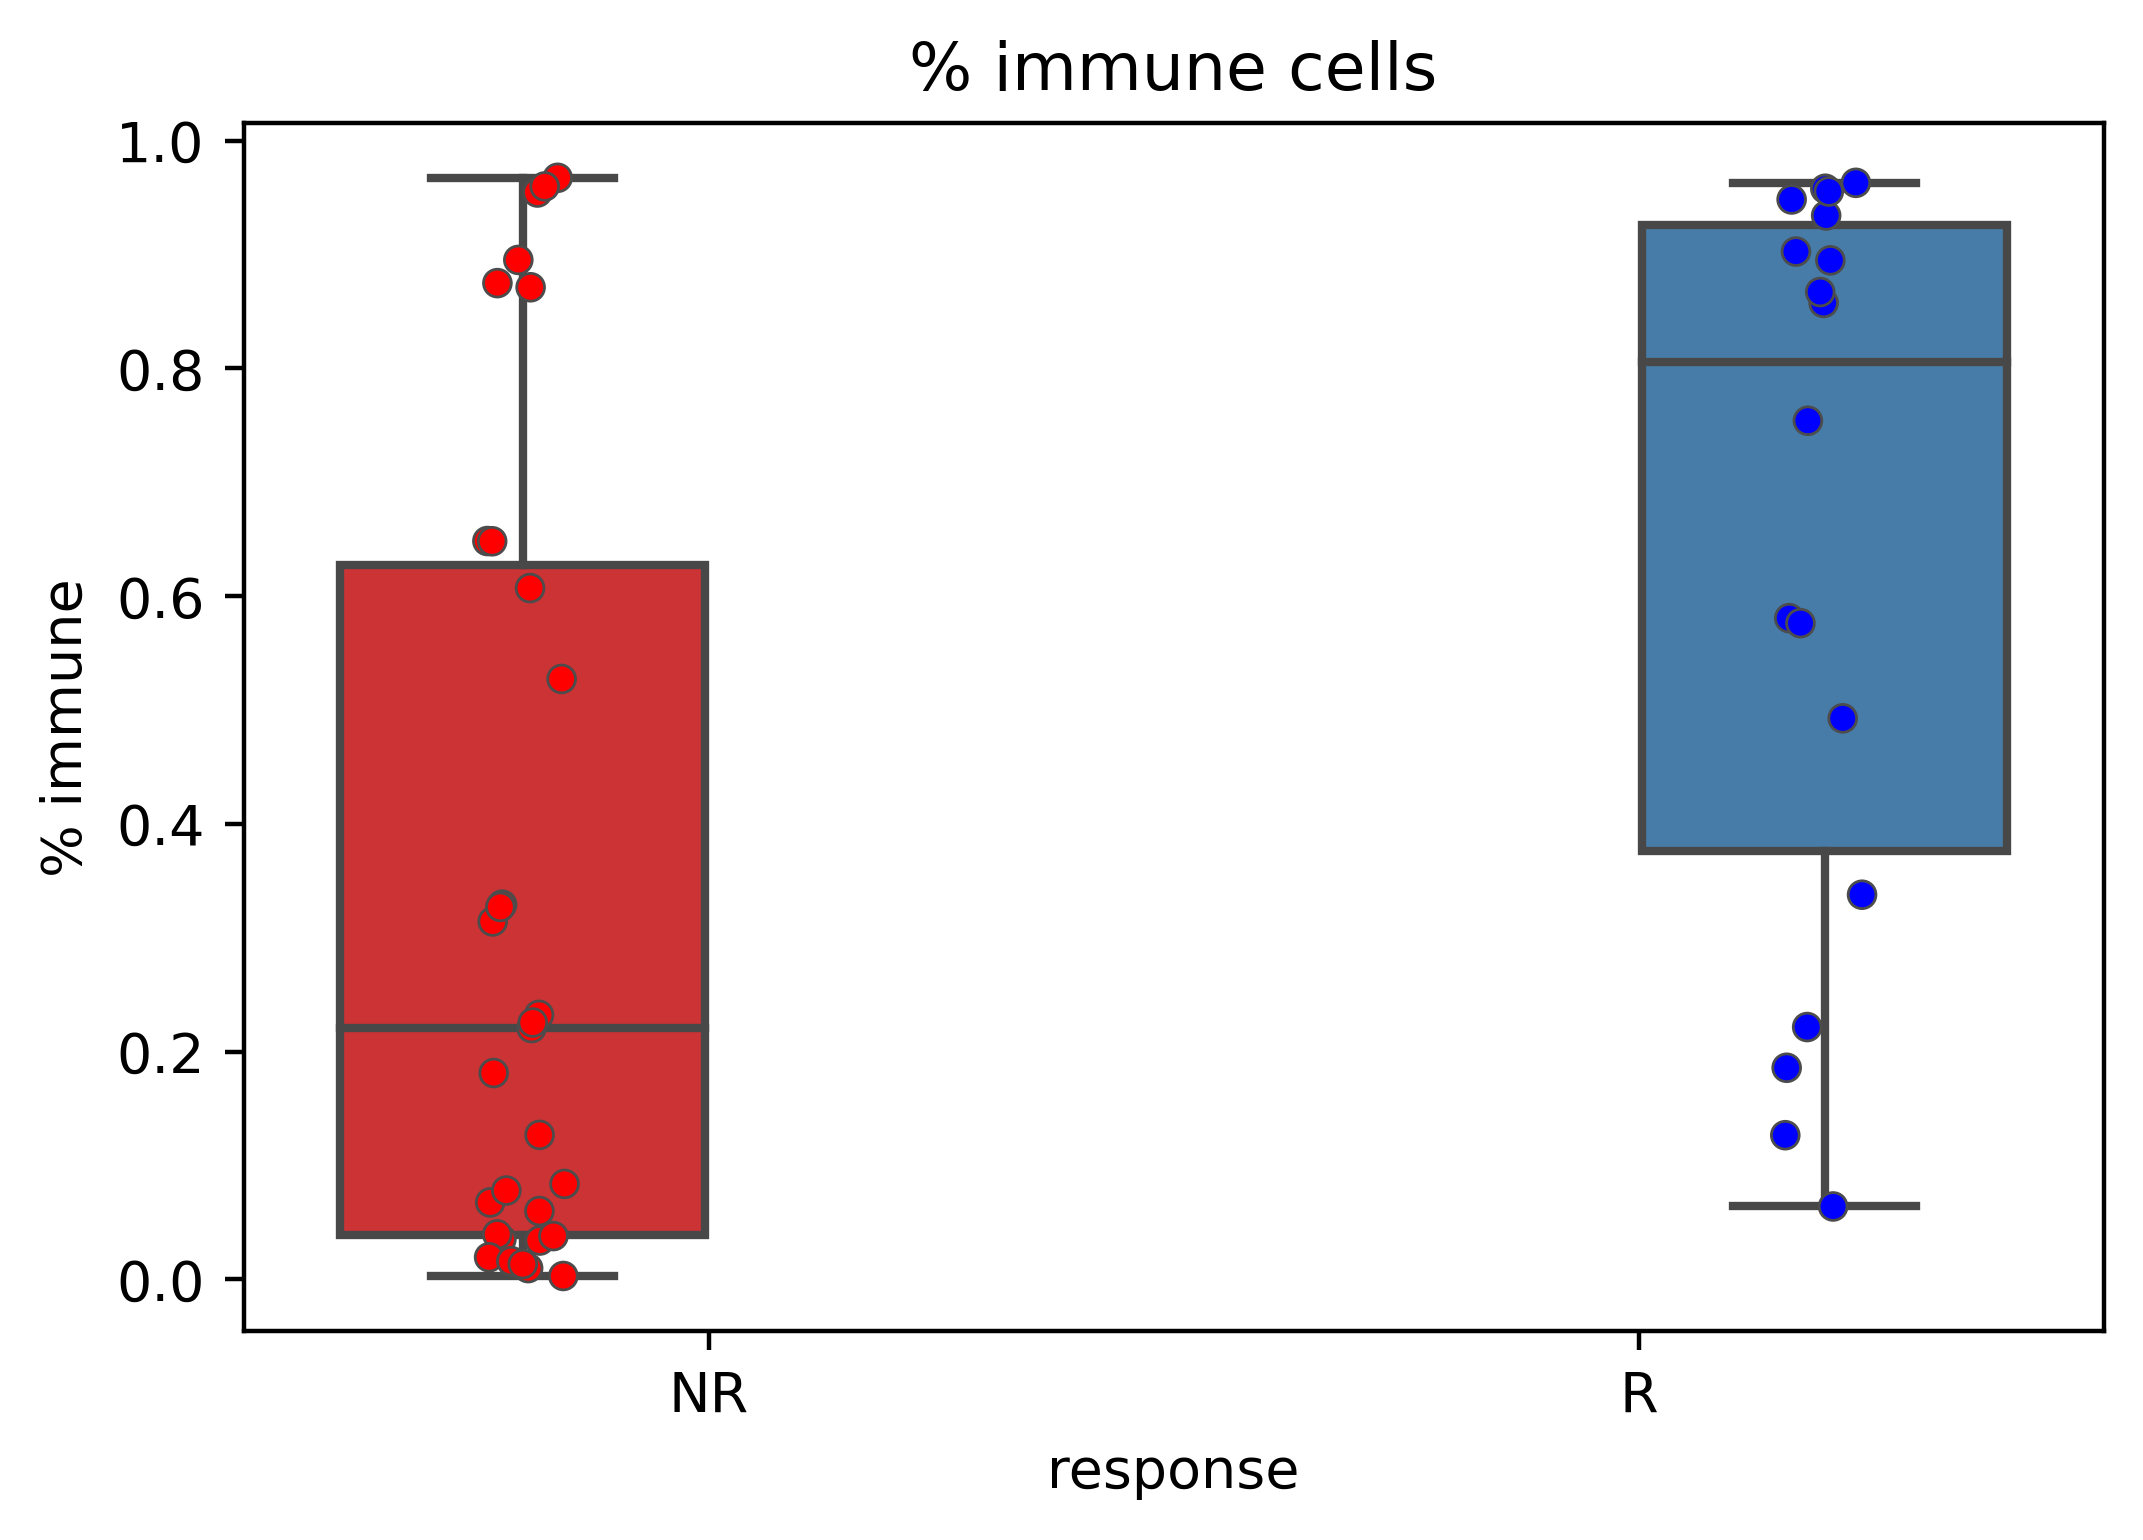

In [18]:
print(f'pval: {pval}')

sns.boxplot(y="% immune", x='response', hue='response',  palette="Set1", data=test_df).set(title='% immune cells');
sns.stripplot(y="% immune", x='response', hue='response', data=test_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
# plt.legend(loc='upper left');
plt.legend().set_visible(False)

plt.savefig(r'/storage/md_keren/shitay/outputs/thesis/cohort/immune_percent_r_vs_nr.jpg')



### Plots:

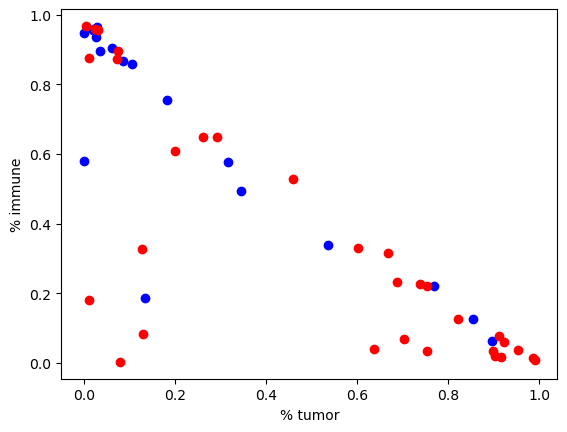

In [65]:
plt.rcdefaults()  # reset params

filtered_con_df = concatenated_df[concatenated_df.response=='R']
plt.scatter(filtered_con_df['% tumor'].values[::-1], filtered_con_df['% immune'].values[::-1], c='b');

filtered_con_df = concatenated_df[concatenated_df.response=='NR']
plt.scatter(filtered_con_df['% tumor'].values[::-1], filtered_con_df['% immune'].values[::-1], c='r');
plt.xlabel('% tumor');
plt.ylabel('% immune');

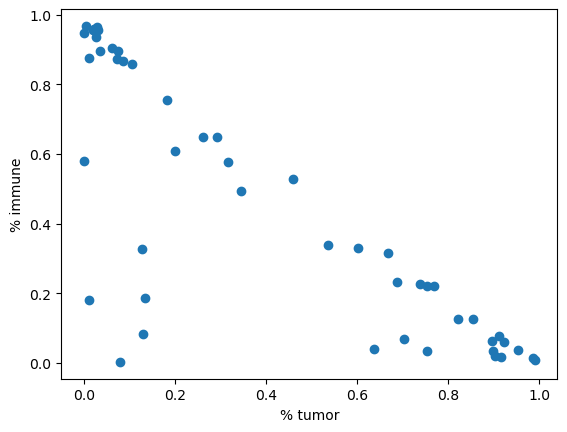

In [66]:
plt.rcdefaults()  # reset params

plt.scatter(concatenated_df['% tumor'].values[::-1], concatenated_df['% immune'].values[::-1]);
plt.xlabel('% tumor');
plt.ylabel('% immune');
plt.savefig(r'/storage/md_keren/shitay/outputs/thesis/cohort/cohort_composition/ratio_immune_tumor.jpg')

#### % of cell-type in sample distribution:

In [44]:
# partly_response_amounts_cohort_df.head(2)

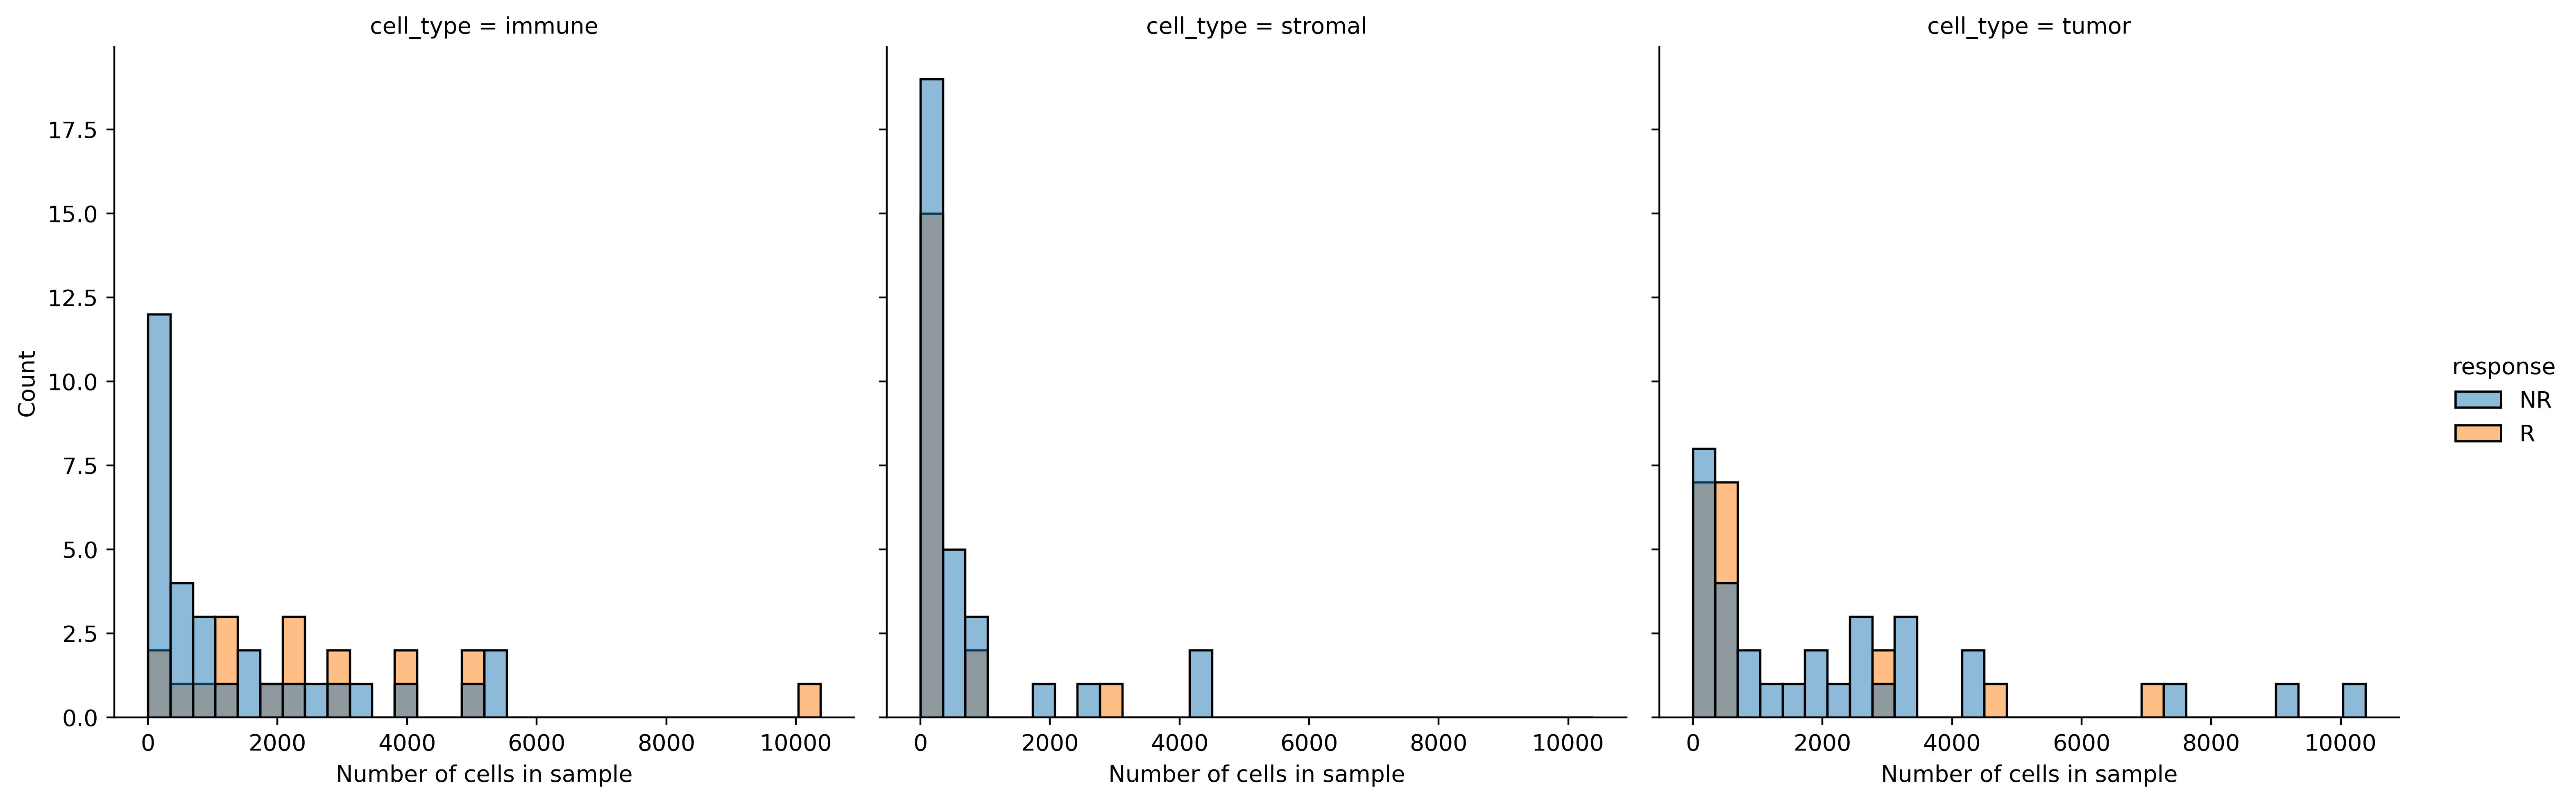

In [65]:
partly_response_amounts_cohort_df = response_amounts_cohort_df[response_amounts_cohort_df['cell_type'].isin(['immune', 'tumor', 'stromal'])].rename(columns={'#': 'Number of cells in sample'})
g = sns.displot(data=partly_response_amounts_cohort_df, x='Number of cells in sample', hue='response', common_norm=False, bins=30, col='cell_type');
g.savefig(r'/storage/md_keren/shitay/outputs/thesis/cohort/cohort_composition/response_tumor_immune_stromal_amounts.jpg')

In [66]:
# response_amounts_cohort_df

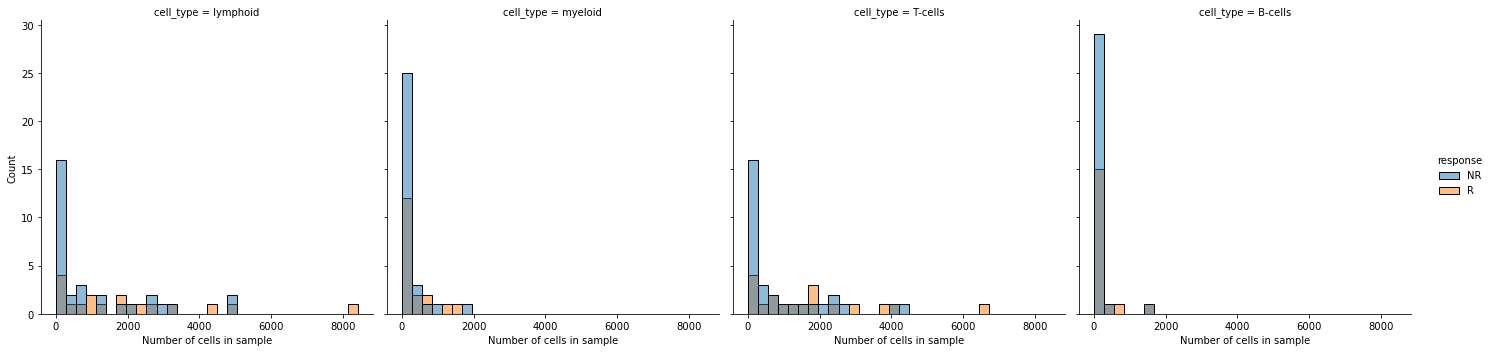

In [135]:
sns.reset_orig() # reset size of figure
# sns.set(font_scale=1.4)

partly_response_amounts_cohort_df = response_amounts_cohort_df[~response_amounts_cohort_df['cell_type'].isin(['immune', 'tumor', 'stromal'])].rename(columns={'#': 'Number of cells in sample'})

g = sns.displot(data=partly_response_amounts_cohort_df, x='Number of cells in sample', hue='response', common_norm=False, bins=30, col='cell_type');
# plt.title(weight='bold', fontsize='22')


# g.savefig(r'/storage/md_keren/shitay/outputs/thesis/cohort/cohort_composition/response_myeloid_lymphoid.jpg')

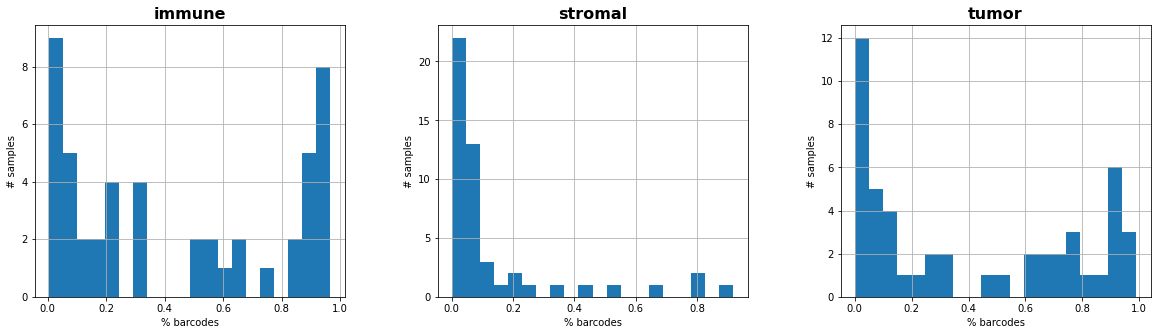

In [136]:
(fig,axes) = plt.subplots(1,3, figsize=(20, 5))
axes = axes.ravel()

for idx, col in enumerate(proportions_cohort_df.columns):        
    proportions_cohort_df.hist(column = col, bins = 20, ax=axes[idx])
    axes[idx].set(xlabel="% barcodes");
    axes[idx].set(ylabel="# samples");
    axes[idx].title.set(fontsize=16, fontweight='bold')

fig.savefig(r'/storage/md_keren/shitay/outputs/thesis/cohort/cohort_composition/tumor_immune_stromal_proportions.jpg')

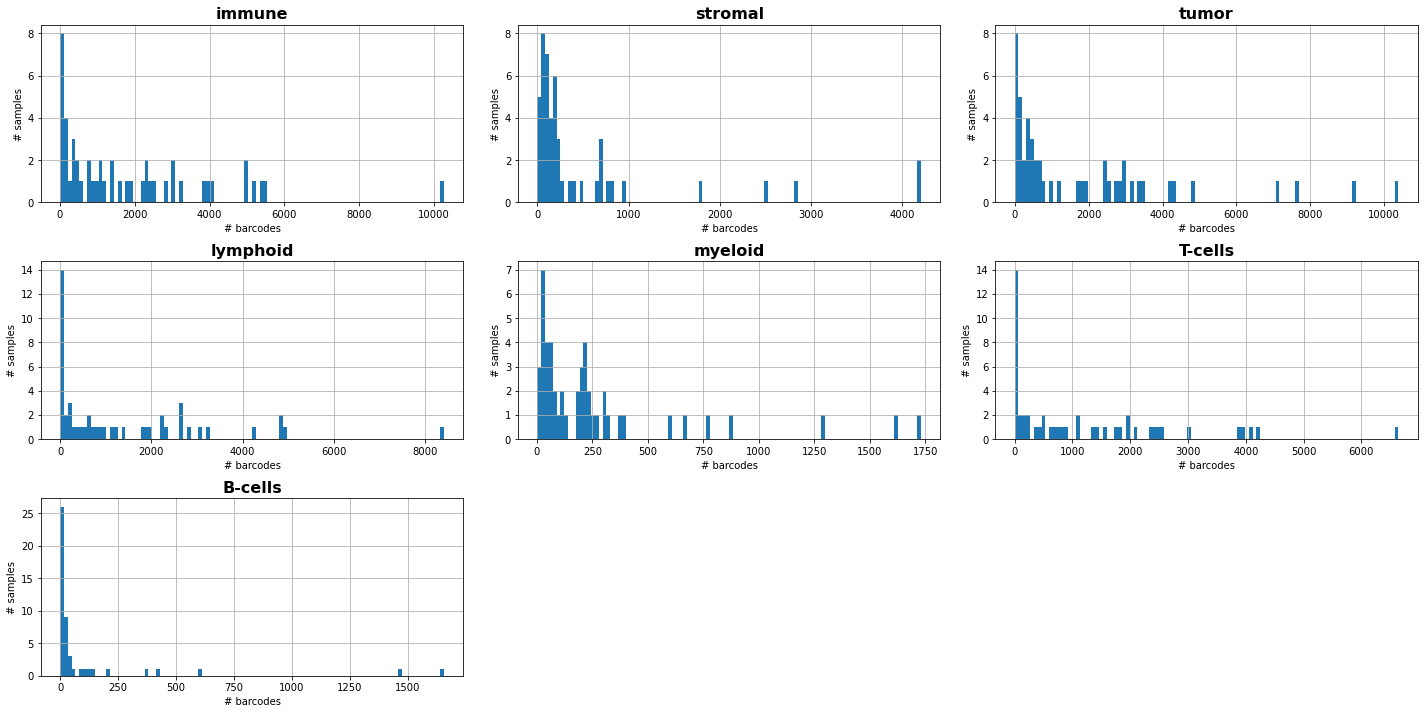

In [138]:
(fig,axes) = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(amounts_cohort_df.columns):
    amounts_cohort_df.hist(column = col, bins = 100, ax=axes[idx])
    axes[idx].set(ylabel="# samples");
    axes[idx].set(xlabel="# barcodes");
    axes[idx].title.set(fontsize=16, fontweight='bold')


    
if len(amounts_cohort_df.columns)%3>0:
    for i in range(3-len(amounts_cohort_df.columns)%3, 0, -1):
        axes[-i].remove();

plt.tight_layout(pad=1)

fig.savefig(r'/storage/md_keren/shitay/outputs/thesis/cohort/cohort_composition/tumor_immune_stromal_amounts.jpg')

# M7. analysis R vs NR: gene level

# M8. analysis R vs NR: cluster level

# M9. analysis R vs NR: validation via CD8 compartment

In [14]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/immune_cells_normalized_5.5.22_4k_genes.pkl'
print(f'Loading cohort from:\n{COHORT_PATH}')

cohort = pickle.load(open(COHORT_PATH, 'rb'))
CD8_cohort = get_requested_subset(cohort, 'CYTOTOXIC_T_CELLS')
immune_cohort = cohort.filter_cells_by_property('is_immune', True)

Loading cohort from:
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/immune_cells_normalized_5.5.22_4k_genes.pkl
Will be performed on cytotoxic T cells


##### Option 1: entire cohort:


In [10]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, 
                                                        response=['R', 'NR'],
#                                                         melanomaType=['Cutaneous', 'Mucosal', 'Uveal', 'UN primary'], 
                                                        treatment=None)

##### Option 2: homogeneous dataset:


In [4]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, 
                                                        response=['R', 'NR'],
                                                        melanomaType=['Cutaneous'],
                                                        treatment=['PEMBRO', 'NIVO'])

In [11]:
# Calculate fractions
immune_counter = dict(Counter(immune_cohort.samples))
CD8_counter = dict(Counter(CD8_cohort.samples))
# CD8_counter = dict(Counter(CD8_cohort_2.samples))

dic_fractions = {k: (CD8_counter.get(k,0)/v) for k,v in immune_counter.items()}
fraction_df = pd.DataFrame(list(dic_fractions.items()), columns=['Sample', 'Fraction'])
fraction_df = fraction_df[fraction_df.Sample.isin(melanoma_clinical_data['PatientId'])]
fraction_df['Response'] = fraction_df.Sample.apply(lambda x: melanoma_clinical_data.set_index('PatientId').loc[x].response)
# fraction_df

In [12]:
##### calculate pval
R_fractions = fraction_df[fraction_df["Response"] == 'R']['Fraction'].values
NR_fractions = fraction_df[fraction_df["Response"] == 'NR']['Fraction'].values
pval = ranksums(R_fractions, NR_fractions)[1]


pval: 0.633363702773104


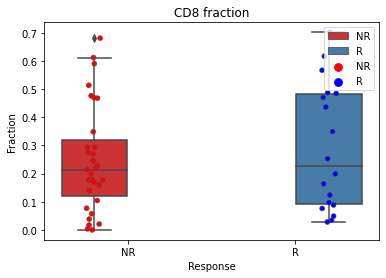

In [13]:
sns.reset_orig() # reset size of figure
# plt.figure(figsize=(7, 4))# figsize

sns.boxplot(y="Fraction", x='Response', hue='Response',  palette="Set1", data=fraction_df).set(title='CD8 fraction');
sns.stripplot(y="Fraction", x='Response', hue='Response', data=fraction_df,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
plt.legend(loc='upper right');

print(f'pval: {pval}')

In [8]:
#### Define the CD8 differently:
CD8_A_idx = immune_cohort.gene_names.index('CD8A')
CD8_B_idx = immune_cohort.gene_names.index('CD8B')
CD8_cohort_2 = immune_cohort[np.sum(immune_cohort.counts[:, [CD8_A_idx, CD8_B_idx]]>1, axis=1) > 0]

# M10. analysis R vs NR: logistic regression and AUC of log10 mem/exha CD8 

## M11. Gublin study
### Effect of treatment using a control group

In [5]:
full_melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, response=['R', 'NR'], treatment=None)
treatment_translator = {'NIVO':'anti-PD1', 'PEMBRO':'anti-PD1', 'IPI + NIVO':'anti-PD1 + anti-CTLA4'}
full_melanoma_clinical_data['treatment_group'] = full_melanoma_clinical_data.apply(lambda x: 'Control' if x['prePost']=='Pre' else treatment_translator[x.treatment], axis=1)
cutaneous_melanoma_clinical_data = full_melanoma_clinical_data[full_melanoma_clinical_data.MelanomaType == 'Cutaneous'].reset_index(drop=True)

In [6]:
full_melanoma_clinical_data.head(2)

PatientId MelanomaType   BRAF treatmentBefore treatmentAfter prePost   ICI  \
0       M97    Cutaneous  False            None           NIVO     Pre  True   
1       M98    Cutaneous  False            NIVO          Other    Post  True   

  response treatment treatment_group  
0        R      NIVO         Control  
1        R      NIVO        anti-PD1

In [7]:
R_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.response == 'R']
NR_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.response == 'NR']


In [8]:
def get_fraction_df(clustering_path):
    clustering_mapping_barcodes = pd.read_csv(clustering_path)
    cluster_fraction = get_cluster_fraction_df(clustering_mapping_barcodes)
    cluster_fraction = cluster_fraction[cluster_fraction['sample'].isin(full_melanoma_clinical_data.PatientId)]
    cluster_fraction['Response'] = cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data.PatientId==x].response.iloc[0])
    cluster_fraction['treatment'] = cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data.PatientId==x].treatment_group.iloc[0])
    return cluster_fraction


In [9]:
IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
myeloid_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
exh_mem_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'


immune_cluster_fraction = get_fraction_df(IMMUNE_CLUSTERING_PATH)
CD8_cluster_fraction = get_fraction_df(CD8_CLUSTERING_PATH)
myeloid_cluster_fraction = get_fraction_df(myeloid_CLUSTERING_PATH)
exh_mem_CD8_cluster_fraction = get_fraction_df(exh_mem_CD8_CLUSTERING_PATH)
GEP_fraction = get_arranged_GEP_fraction_df()

### Select group:

In [207]:
cluster_group_name = 'GEP'
OUTPUT_FOLDER = r'/storage/md_keren/shitay/outputs/thesis/clustering/statistical_tests/pre_post/5.7.22'

###################################
if cluster_group_name=='CD8':
    selected_group_fraction = CD8_cluster_fraction
if cluster_group_name=='myeloid':
    selected_group_fraction = myeloid_cluster_fraction
if cluster_group_name=='immune':
    selected_group_fraction = immune_cluster_fraction
if cluster_group_name=='GEP':
    selected_group_fraction = GEP_fraction
if cluster_group_name=='Exahusted and memory CD8':
    selected_group_fraction = exh_mem_CD8_cluster_fraction
    
create_folder(OUTPUT_FOLDER)
create_folder(join(OUTPUT_FOLDER, cluster_group_name))

In [208]:
all_groups = {'Non-responders':NR_cutaneous_melanoma_clinical_data,
             'Responders':R_cutaneous_melanoma_clinical_data}

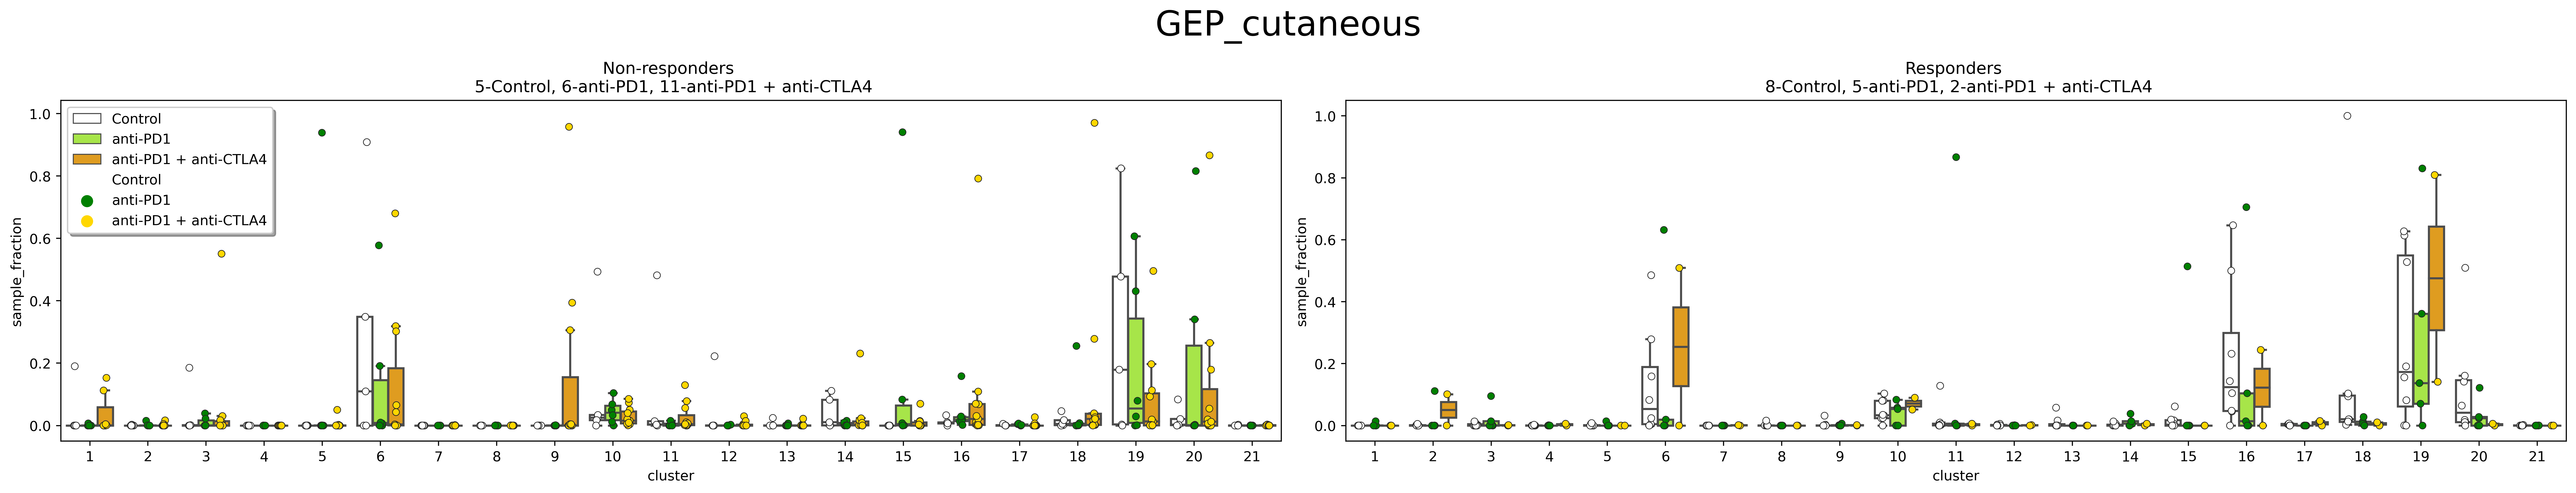

In [209]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(26, int(5*len(all_groups)/2)))
axes = axes.ravel()


for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = selected_group_fraction[selected_group_fraction['sample'].isin(group_df['PatientId'])]
    filtered_unique_sample_df = pd.DataFrame(group_fractions.groupby(['sample', 'treatment', 'Response']).count().index.tolist(), columns=['sample', 'treatment', 'response'])
    title_list = filtered_unique_sample_df.groupby('treatment').agg(count=('sample', 'count')).reset_index().values.tolist()
    title = group_name+' \n '+', '.join([str(v)+'-'+k for k,v in title_list])


    sns.boxplot(ax=axes[idx], x="cluster", y="sample_fraction", hue='treatment',  showfliers = False,
                palette={'Control':'white', 'anti-PD1':'greenyellow', 'anti-PD1 + anti-CTLA4':'orange'}, data=group_fractions.sort_values('treatment')).set(title=title);
    sns.stripplot(ax=axes[idx],x='cluster', y='sample_fraction', hue='treatment', data=group_fractions.sort_values('treatment'),
                  jitter=True, dodge=True, linewidth=0.5, palette={'Control':'white', 'anti-PD1 + anti-CTLA4':'gold', 'anti-PD1':'g'});
    axes[idx].legend(loc='upper left', fancybox=True, shadow=True)
    if idx>0:
        axes[idx].get_legend().remove()
    
    fold_change_df = get_fold_change__treatment_effect_df(group_fractions)
    pval_df = conduct_tests(group_fractions)
#     pval_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/{group_name}_cutaneous.xlsx'))
    fold_change_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/FC_{group_name}_cutaneous.xlsx'))


fig.suptitle(f'{cluster_group_name}_cutaneous', fontsize=25);
plt.tight_layout(pad=1)
# fig.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - {len(all_groups)} groups.jpg'))

### Cutaneous samples

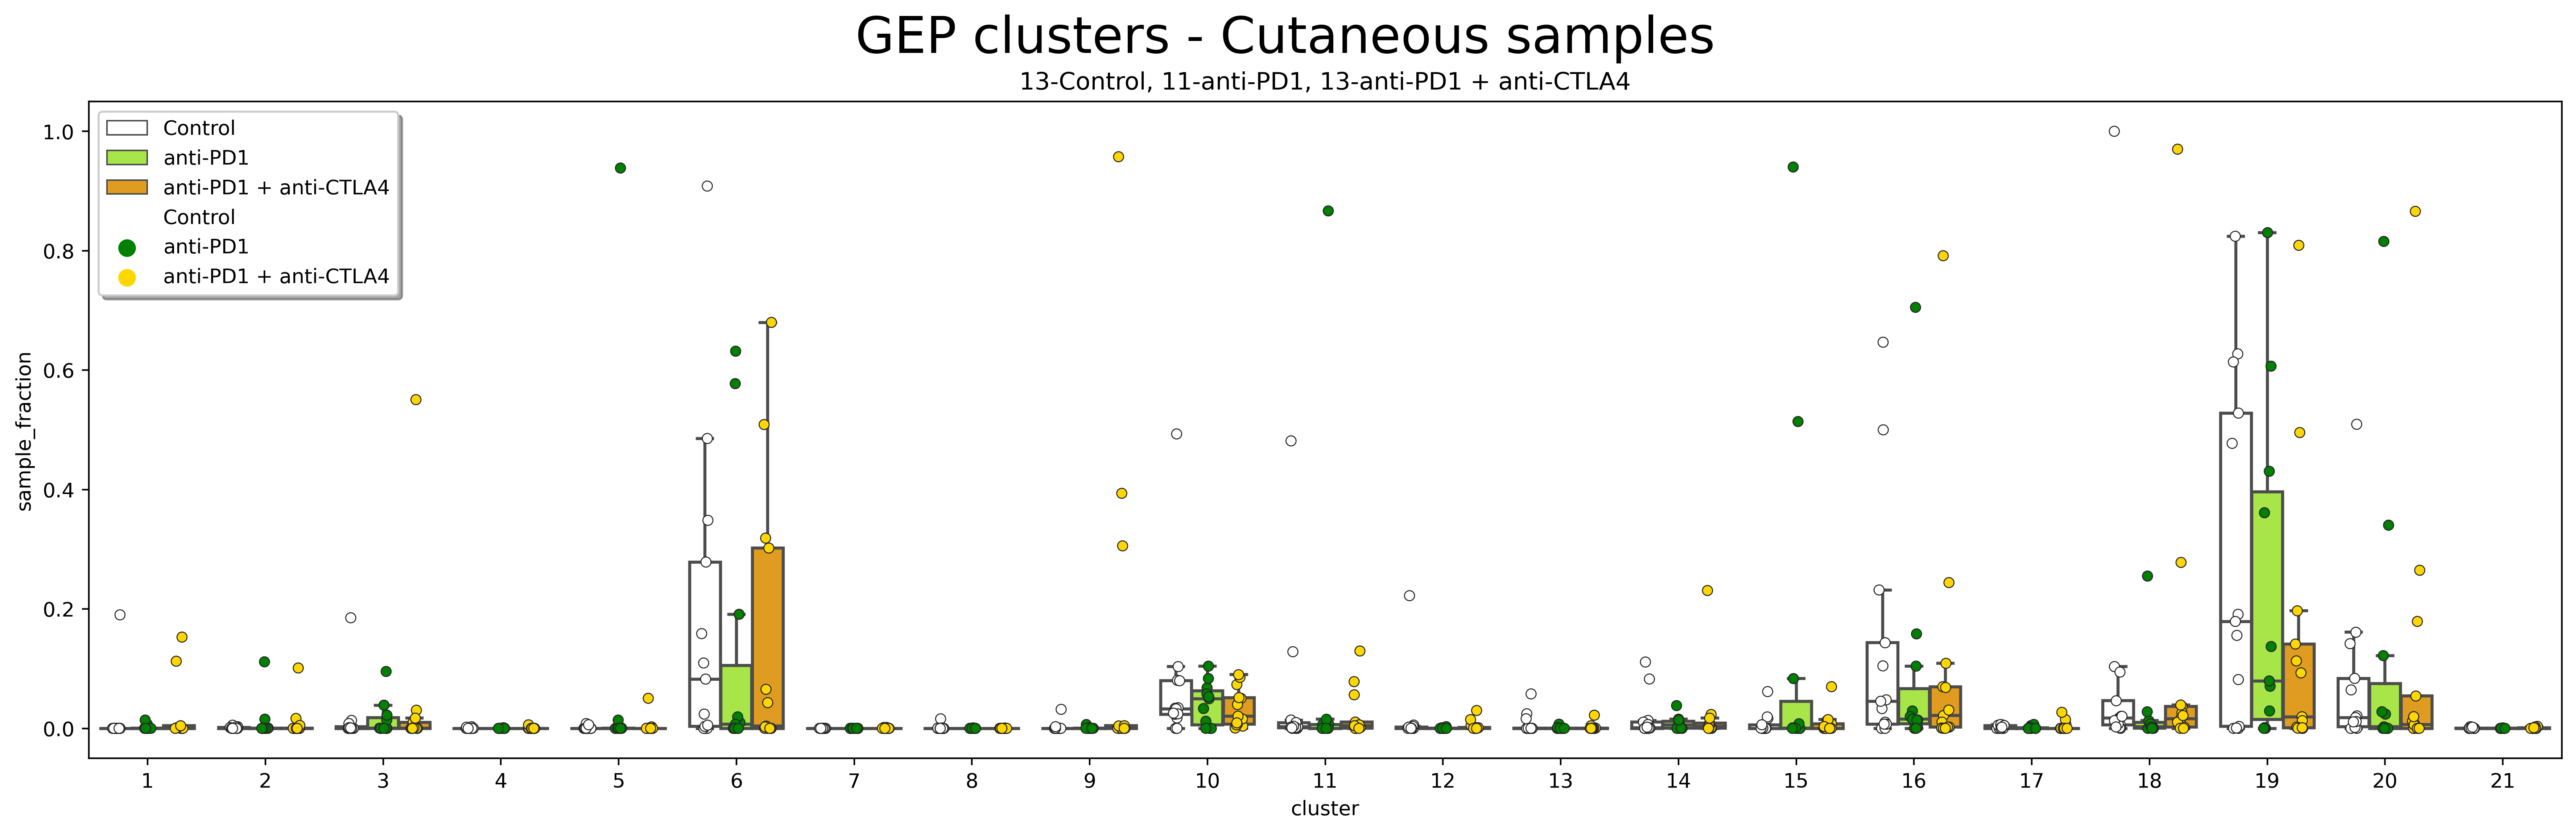

In [210]:
plt.figure(figsize=(22, 6))



group_fractions = selected_group_fraction[selected_group_fraction['sample'].isin(cutaneous_melanoma_clinical_data.PatientId)]

fold_change_df = get_fold_change__treatment_effect_df(group_fractions)
filtered_unique_sample_df = pd.DataFrame(group_fractions.groupby(['sample', 'treatment', 'Response']).count().index.tolist(), columns=['sample', 'treatment', 'response'])
title_list = filtered_unique_sample_df.groupby('treatment').agg(count=('sample', 'count')).reset_index().values.tolist()
title = ', '.join([str(v)+'-'+k for k,v in title_list])
pval_df = conduct_tests(group_fractions)
        

sns.boxplot(x="cluster", y="sample_fraction", hue='treatment',  showfliers = False,
            palette={'Control':'white', 'anti-PD1':'greenyellow', 'anti-PD1 + anti-CTLA4':'orange'}, data=group_fractions.sort_values('treatment')).set(title=title);
sns.stripplot(x='cluster', y='sample_fraction', hue='treatment', data=group_fractions.sort_values('treatment'),
              jitter=True, dodge=True, linewidth=0.5, palette={'Control':'white', 'anti-PD1 + anti-CTLA4':'gold', 'anti-PD1':'g'});

plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.suptitle(f'{cluster_group_name} clusters - Cutaneous samples', fontsize=25);

fold_change_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/FC_cutaneous_samples.xlsx'))
# pval_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/Cutaneous.xlsx'))
# plt.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - cutaenous samples.jpg'))

#### Entire cohort

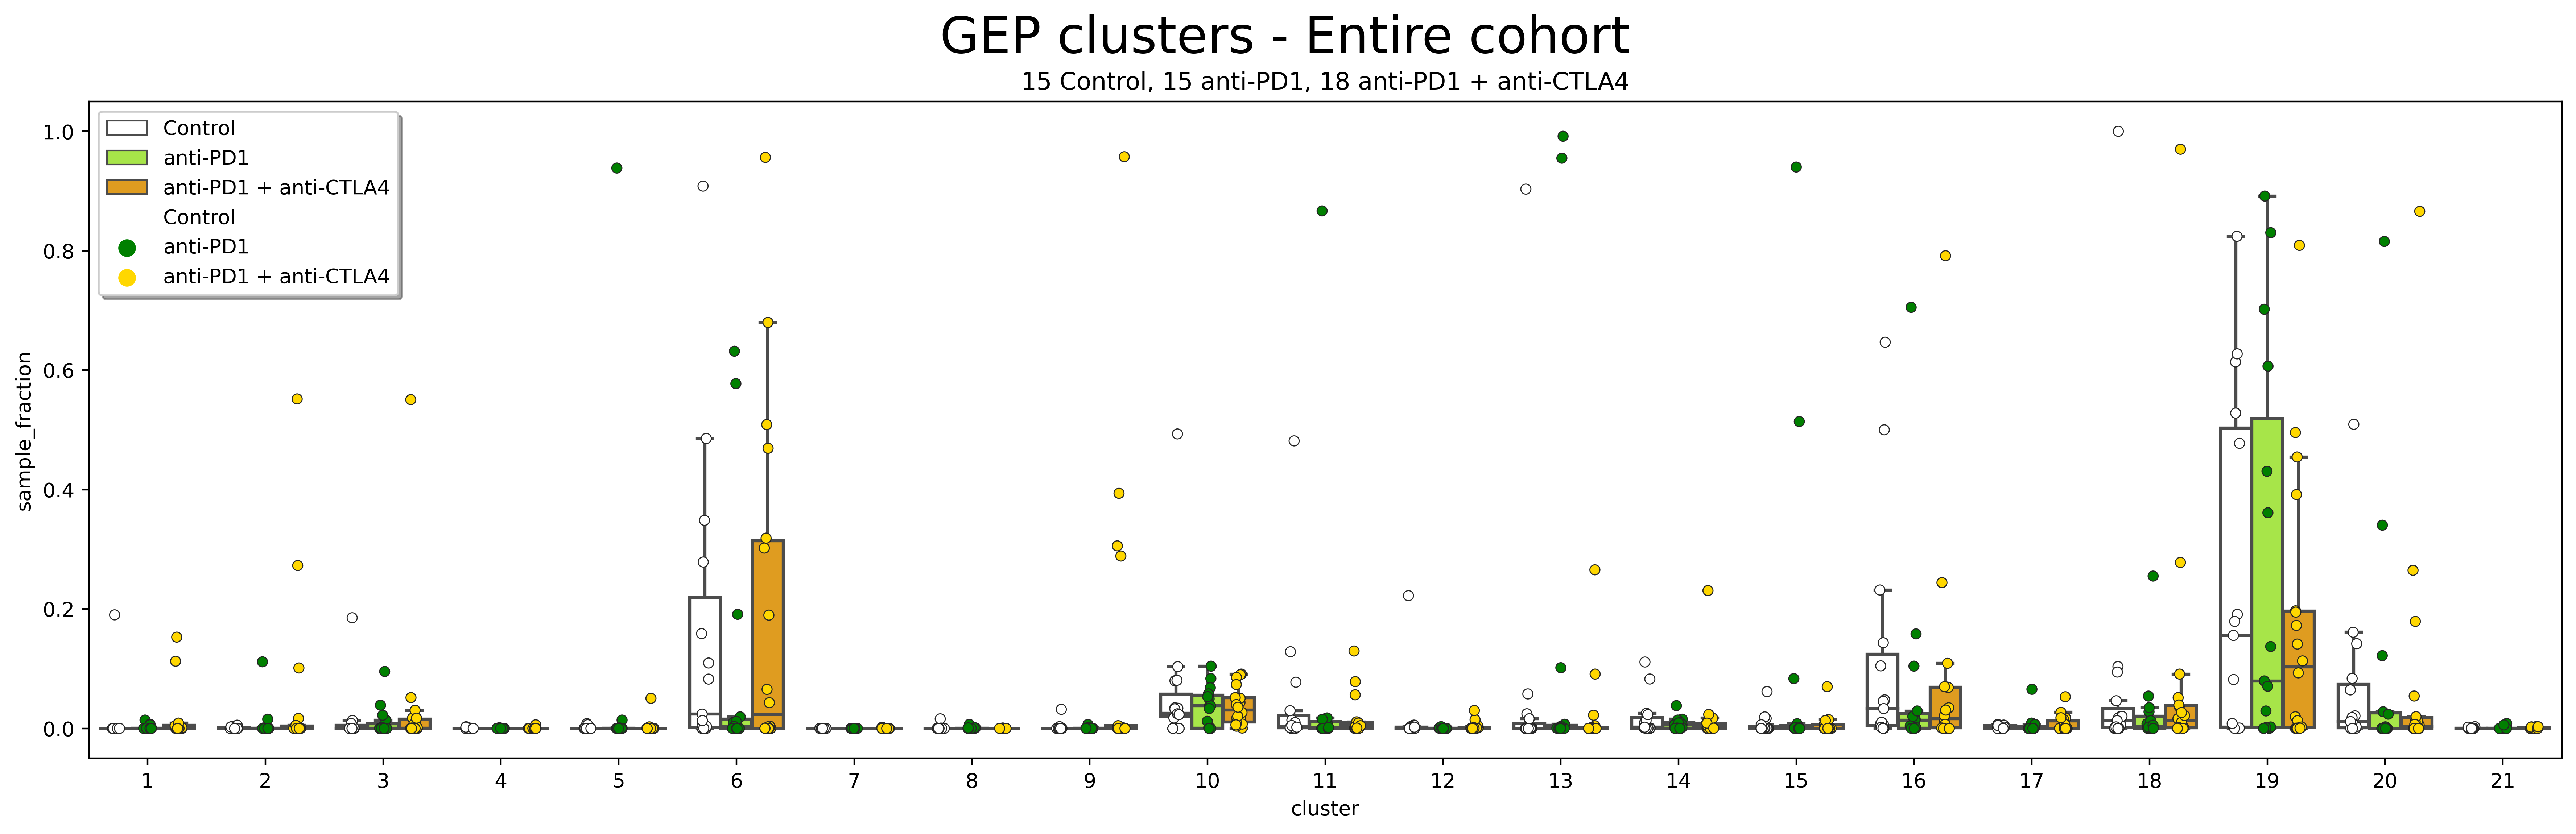

In [211]:
plt.figure(figsize=(22, 6))



group_fractions = selected_group_fraction
fold_change_df = get_fold_change__treatment_effect_df(group_fractions)

filtered_unique_sample_df = pd.DataFrame(group_fractions.groupby(['sample', 'treatment', 'Response']).count().index.tolist(), columns=['sample', 'treatment', 'response'])
title_list = filtered_unique_sample_df.groupby('treatment').agg(count=('sample', 'count')).reset_index().values.tolist()
title = ', '.join([str(v)+' '+k for k,v in title_list])
pval_df = conduct_tests(group_fractions)

sns.boxplot(x="cluster", y="sample_fraction", hue='treatment',  showfliers = False,
            palette={'Control':'white', 'anti-PD1':'greenyellow', 'anti-PD1 + anti-CTLA4':'orange'}, data=group_fractions.sort_values('treatment')).set(title=title);
sns.stripplot(x='cluster', y='sample_fraction', hue='treatment', data=group_fractions.sort_values('treatment'),
              jitter=True, dodge=True, linewidth=0.5, palette={'Control':'white', 'anti-PD1 + anti-CTLA4':'gold', 'anti-PD1':'g'});

plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.suptitle(f'{cluster_group_name} clusters - Entire cohort', fontsize=25);

fold_change_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/FC_entire_cohort.xlsx'))
# pval_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/entire_cohort.xlsx'))
# plt.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - Entire cohort.jpg'))

In [212]:
# join(OUTPUT_FOLDER, fr'{cluster_group_name}')

### Load pval dfs and see for significant cases:

In [64]:

MAIN_FOLDER = r'/storage/md_keren/shitay/outputs/thesis/clustering/statistical_tests/pre_post/15.6.22'
for clustering_name in os.listdir(MAIN_FOLDER):
    print(f'\n\n\n\n{clustering_name}')
    for file in os.listdir(join(MAIN_FOLDER, clustering_name)):
        print(file)
        df = pd.read_excel(join(MAIN_FOLDER, clustering_name, file))
        pvals = df[df.pval < 0.05]
        qvals = df[df.qval < 0.05]
#         if len(pvals)>0:
#             display(pvals)
        if len(qvals)>0:
            display(qvals)





Exahusted and memory CD8
Responders_cutaneous.xlsx
entire_cohort.xlsx
Cutaneous.xlsx
Non-responders_cutaneous.xlsx




immune
Responders_cutaneous.xlsx
entire_cohort.xlsx
Cutaneous.xlsx
Non-responders_cutaneous.xlsx




myeloid
Responders_cutaneous.xlsx
entire_cohort.xlsx
Cutaneous.xlsx
Non-responders_cutaneous.xlsx




CD8
Responders_cutaneous.xlsx
entire_cohort.xlsx
Cutaneous.xlsx
Non-responders_cutaneous.xlsx


## M11. Gublin study
### analysis Pre vs Post: subclustering

In [145]:
full_melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, response=['R', 'NR'], treatment=None)
cutaneous_melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True, melanoma_type=['Cutaneous'], therapy_translator=seperate_IPI_from_NIVO_translator, additional_features=['Biopsy type (pre, post)'], time_translator=pre_pro_translator)
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['response'] != 'not in use for now']                    
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data.drop(columns=['ICI', 'BRAF', 'Biopsy type (pre, post)']).reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


In [146]:
cutaneous_melanoma_clinical_data['treatment'] = cutaneous_melanoma_clinical_data.apply(lambda x: x.treatment_after if x['pre/post']=='Pre' else x.treatment_before, axis=1)

NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO']
IPI_NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO + IPI']



IPI_NIVO_R_cutaneous_melanoma_clinical_data = IPI_NIVO_cutaneous_melanoma_clinical_data[IPI_NIVO_cutaneous_melanoma_clinical_data.response == 'R']
IPI_NIVO_NR_cutaneous_melanoma_clinical_data = IPI_NIVO_cutaneous_melanoma_clinical_data[IPI_NIVO_cutaneous_melanoma_clinical_data.response == 'NR']

NIVO_R_cutaneous_melanoma_clinical_data = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data.response == 'R']
NIVO_NR_cutaneous_melanoma_clinical_data = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data.response == 'NR']


In [147]:
# CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
# CD8_clustering_mapping_barcodes = pd.read_csv(CD8_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
# CD8_cluster_fraction = get_cluster_fraction_df(CD8_clustering_mapping_barcodes)
# CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
# CD8_cluster_fraction['Response'] = CD8_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])


In [148]:
IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
immune_clustering_mapping_barcodes = pd.read_csv(IMMUNE_CLUSTERING_PATH)
f_immune_cluster_fraction = get_cluster_fraction_df(immune_clustering_mapping_barcodes)
f_immune_cluster_fraction = f_immune_cluster_fraction[f_immune_cluster_fraction['sample'].isin(full_melanoma_clinical_data['PatientId'])]
f_immune_cluster_fraction['Response'] = f_immune_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x].response.iloc[0])
f_immune_cluster_fraction['pre_post'] = f_immune_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x]['prePost'].iloc[0])
immune_cluster_fraction = f_immune_cluster_fraction[f_immune_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]

CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
CD8_clustering_mapping_barcodes = pd.read_csv(CD8_CLUSTERING_PATH)
f_CD8_cluster_fraction = get_cluster_fraction_df(CD8_clustering_mapping_barcodes)
f_CD8_cluster_fraction = f_CD8_cluster_fraction[f_CD8_cluster_fraction['sample'].isin(full_melanoma_clinical_data['PatientId'])]
f_CD8_cluster_fraction['Response'] = f_CD8_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x].response.iloc[0])
f_CD8_cluster_fraction['pre_post'] = f_CD8_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x]['prePost'].iloc[0])
CD8_cluster_fraction = f_CD8_cluster_fraction[f_CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]


myeloid_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
myeloid_clustering_mapping_barcodes = pd.read_csv(myeloid_CLUSTERING_PATH)
f_myeloid_cluster_fraction = get_cluster_fraction_df(myeloid_clustering_mapping_barcodes)
f_myeloid_cluster_fraction = f_myeloid_cluster_fraction[f_myeloid_cluster_fraction['sample'].isin(full_melanoma_clinical_data['PatientId'])]
f_myeloid_cluster_fraction['Response'] = f_myeloid_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x].response.iloc[0])
f_myeloid_cluster_fraction['pre_post'] = f_myeloid_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x]['prePost'].iloc[0])
myeloid_cluster_fraction = f_myeloid_cluster_fraction[f_myeloid_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]

exh_mem_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'
exh_mem_CD8_clustering_mapping_barcodes = pd.read_csv(exh_mem_CD8_CLUSTERING_PATH).drop(columns=['index'])
f_exh_mem_CD8_cluster_fraction = get_cluster_fraction_df(exh_mem_CD8_clustering_mapping_barcodes)
f_exh_mem_CD8_cluster_fraction = f_exh_mem_CD8_cluster_fraction[f_exh_mem_CD8_cluster_fraction['sample'].isin(full_melanoma_clinical_data['PatientId'])]
f_exh_mem_CD8_cluster_fraction['Response'] = f_exh_mem_CD8_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x].response.iloc[0])
f_exh_mem_CD8_cluster_fraction['pre_post'] = f_exh_mem_CD8_cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data['PatientId']==x]['prePost'].iloc[0])
exh_mem_CD8_cluster_fraction = f_exh_mem_CD8_cluster_fraction[f_exh_mem_CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]

### Select group:

In [149]:
cluster_group_name = 'Exahusted and memory CD8'
OUTPUT_FOLDER = r'/storage/md_keren/shitay/outputs/thesis/clustering/statistical_tests/pre_post'

###################################
if cluster_group_name=='CD8':
    selected_group_fraction = CD8_cluster_fraction
    full_selected_group_fraction = f_CD8_cluster_fraction
if cluster_group_name=='myeloid':
    selected_group_fraction = myeloid_cluster_fraction
    full_selected_group_fraction = f_myeloid_cluster_fraction
if cluster_group_name=='immune':
    selected_group_fraction = immune_cluster_fraction
    full_selected_group_fraction = f_immune_cluster_fraction
if cluster_group_name=='Exahusted and memory CD8':
    selected_group_fraction = exh_mem_CD8_cluster_fraction
    full_selected_group_fraction = f_exh_mem_CD8_cluster_fraction
    
create_folder(join(OUTPUT_FOLDER, cluster_group_name))

### Specify treatment division:

In [150]:
all_groups = {'Responders - anti-PD1 + anti-CTLA4':IPI_NIVO_R_cutaneous_melanoma_clinical_data,
 'Non-responders - anti-PD1 + anti-CTLA4':IPI_NIVO_NR_cutaneous_melanoma_clinical_data,
 'Responders - anti-PD1':NIVO_R_cutaneous_melanoma_clinical_data,
 'Non-responders - anti-PD1':NIVO_NR_cutaneous_melanoma_clinical_data}

# all_groups = {'anti-PD1 + anti-CTLA4':IPI_NIVO_cutaneous_melanoma_clinical_data,
#              'anti-PD1':NIVO_cutaneous_melanoma_clinical_data}

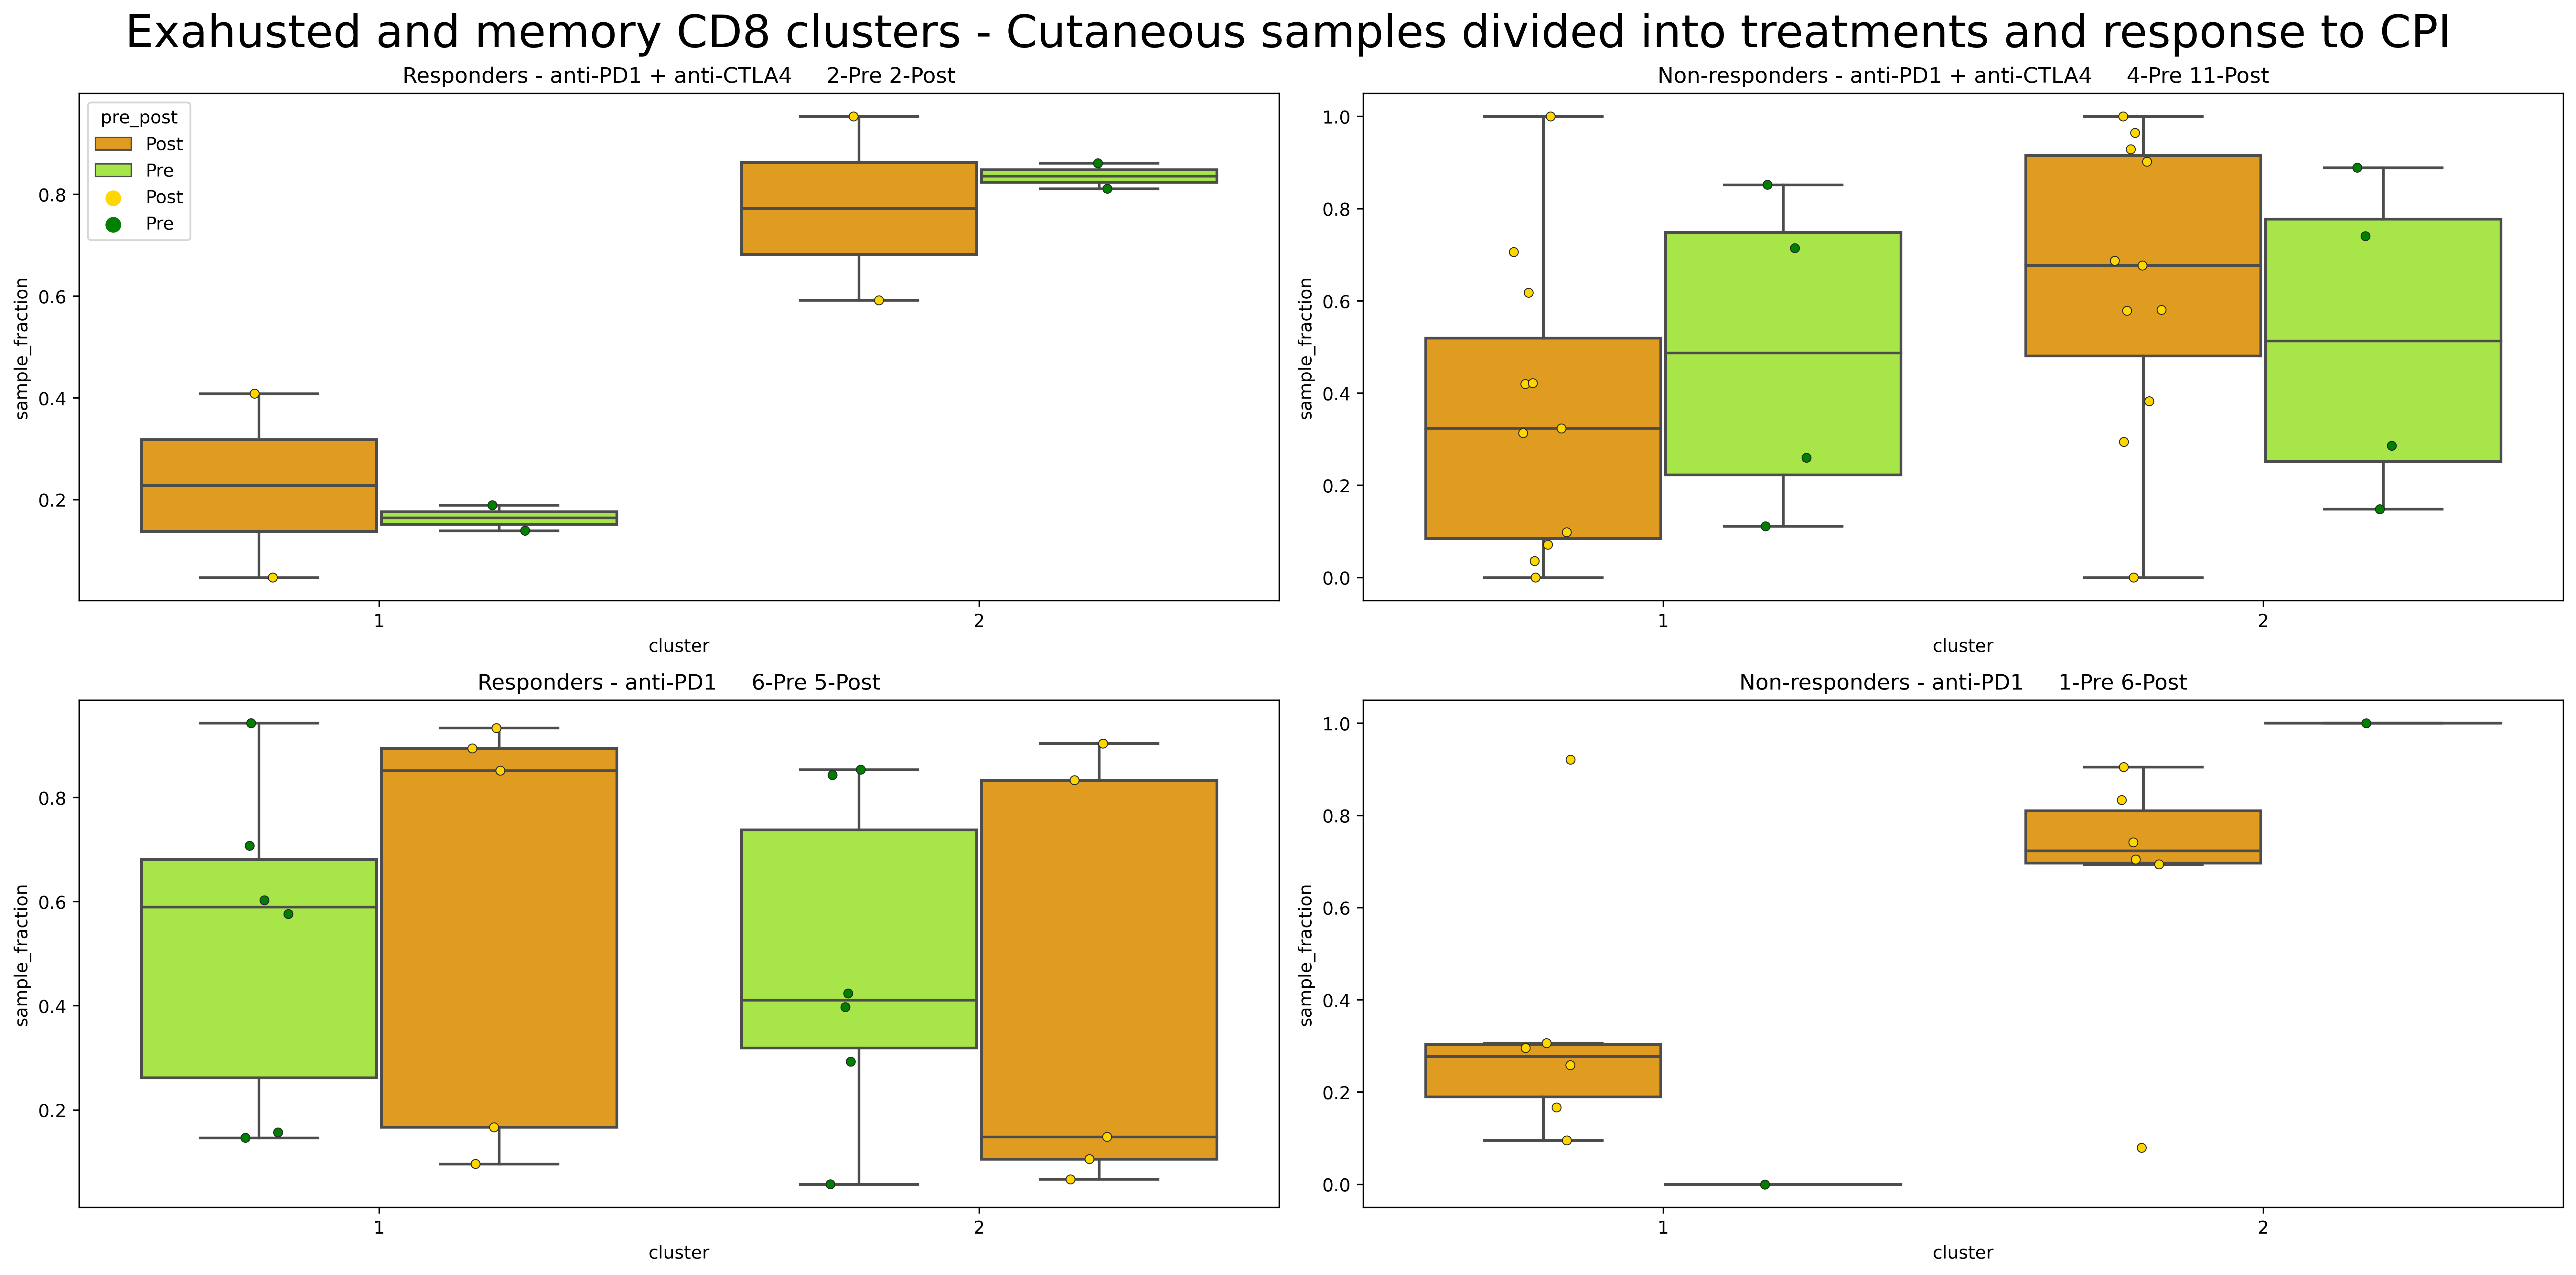

In [80]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(20, int(5*len(all_groups)/2)))
axes = axes.ravel()
# pre_post = '' if len(all_groups)==2 else ', Pre/Post'

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = selected_group_fraction[selected_group_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
#     group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="cluster", y="sample_fraction", hue='pre_post',  showfliers = False,
                palette={'Pre':'greenyellow', 'Post':'orange'}, data=group_fractions).set(title=group_name+'     '+str(group_df['pre/post'].value_counts()["Pre"])+'-Pre ' + str(group_df['pre/post'].value_counts()["Post"])+'-Post');
    sns.stripplot(ax=axes[idx],x='cluster', y='sample_fraction', hue='pre_post', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'Pre':'g', 'Post':'gold'});
    if idx>0:
        axes[idx].get_legend().remove()

# 
if len(all_groups)==2:
    fig.suptitle(f'{cluster_group_name} clusters - Cutaneous samples divided into treatments', fontsize=25);
else:
    fig.suptitle(f'{cluster_group_name} clusters - Cutaneous samples divided into treatments and response to CPI', fontsize=25);
plt.tight_layout(pad=1)
fig.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - {len(all_groups)} groups.jpg'))

All cutaneous samples:

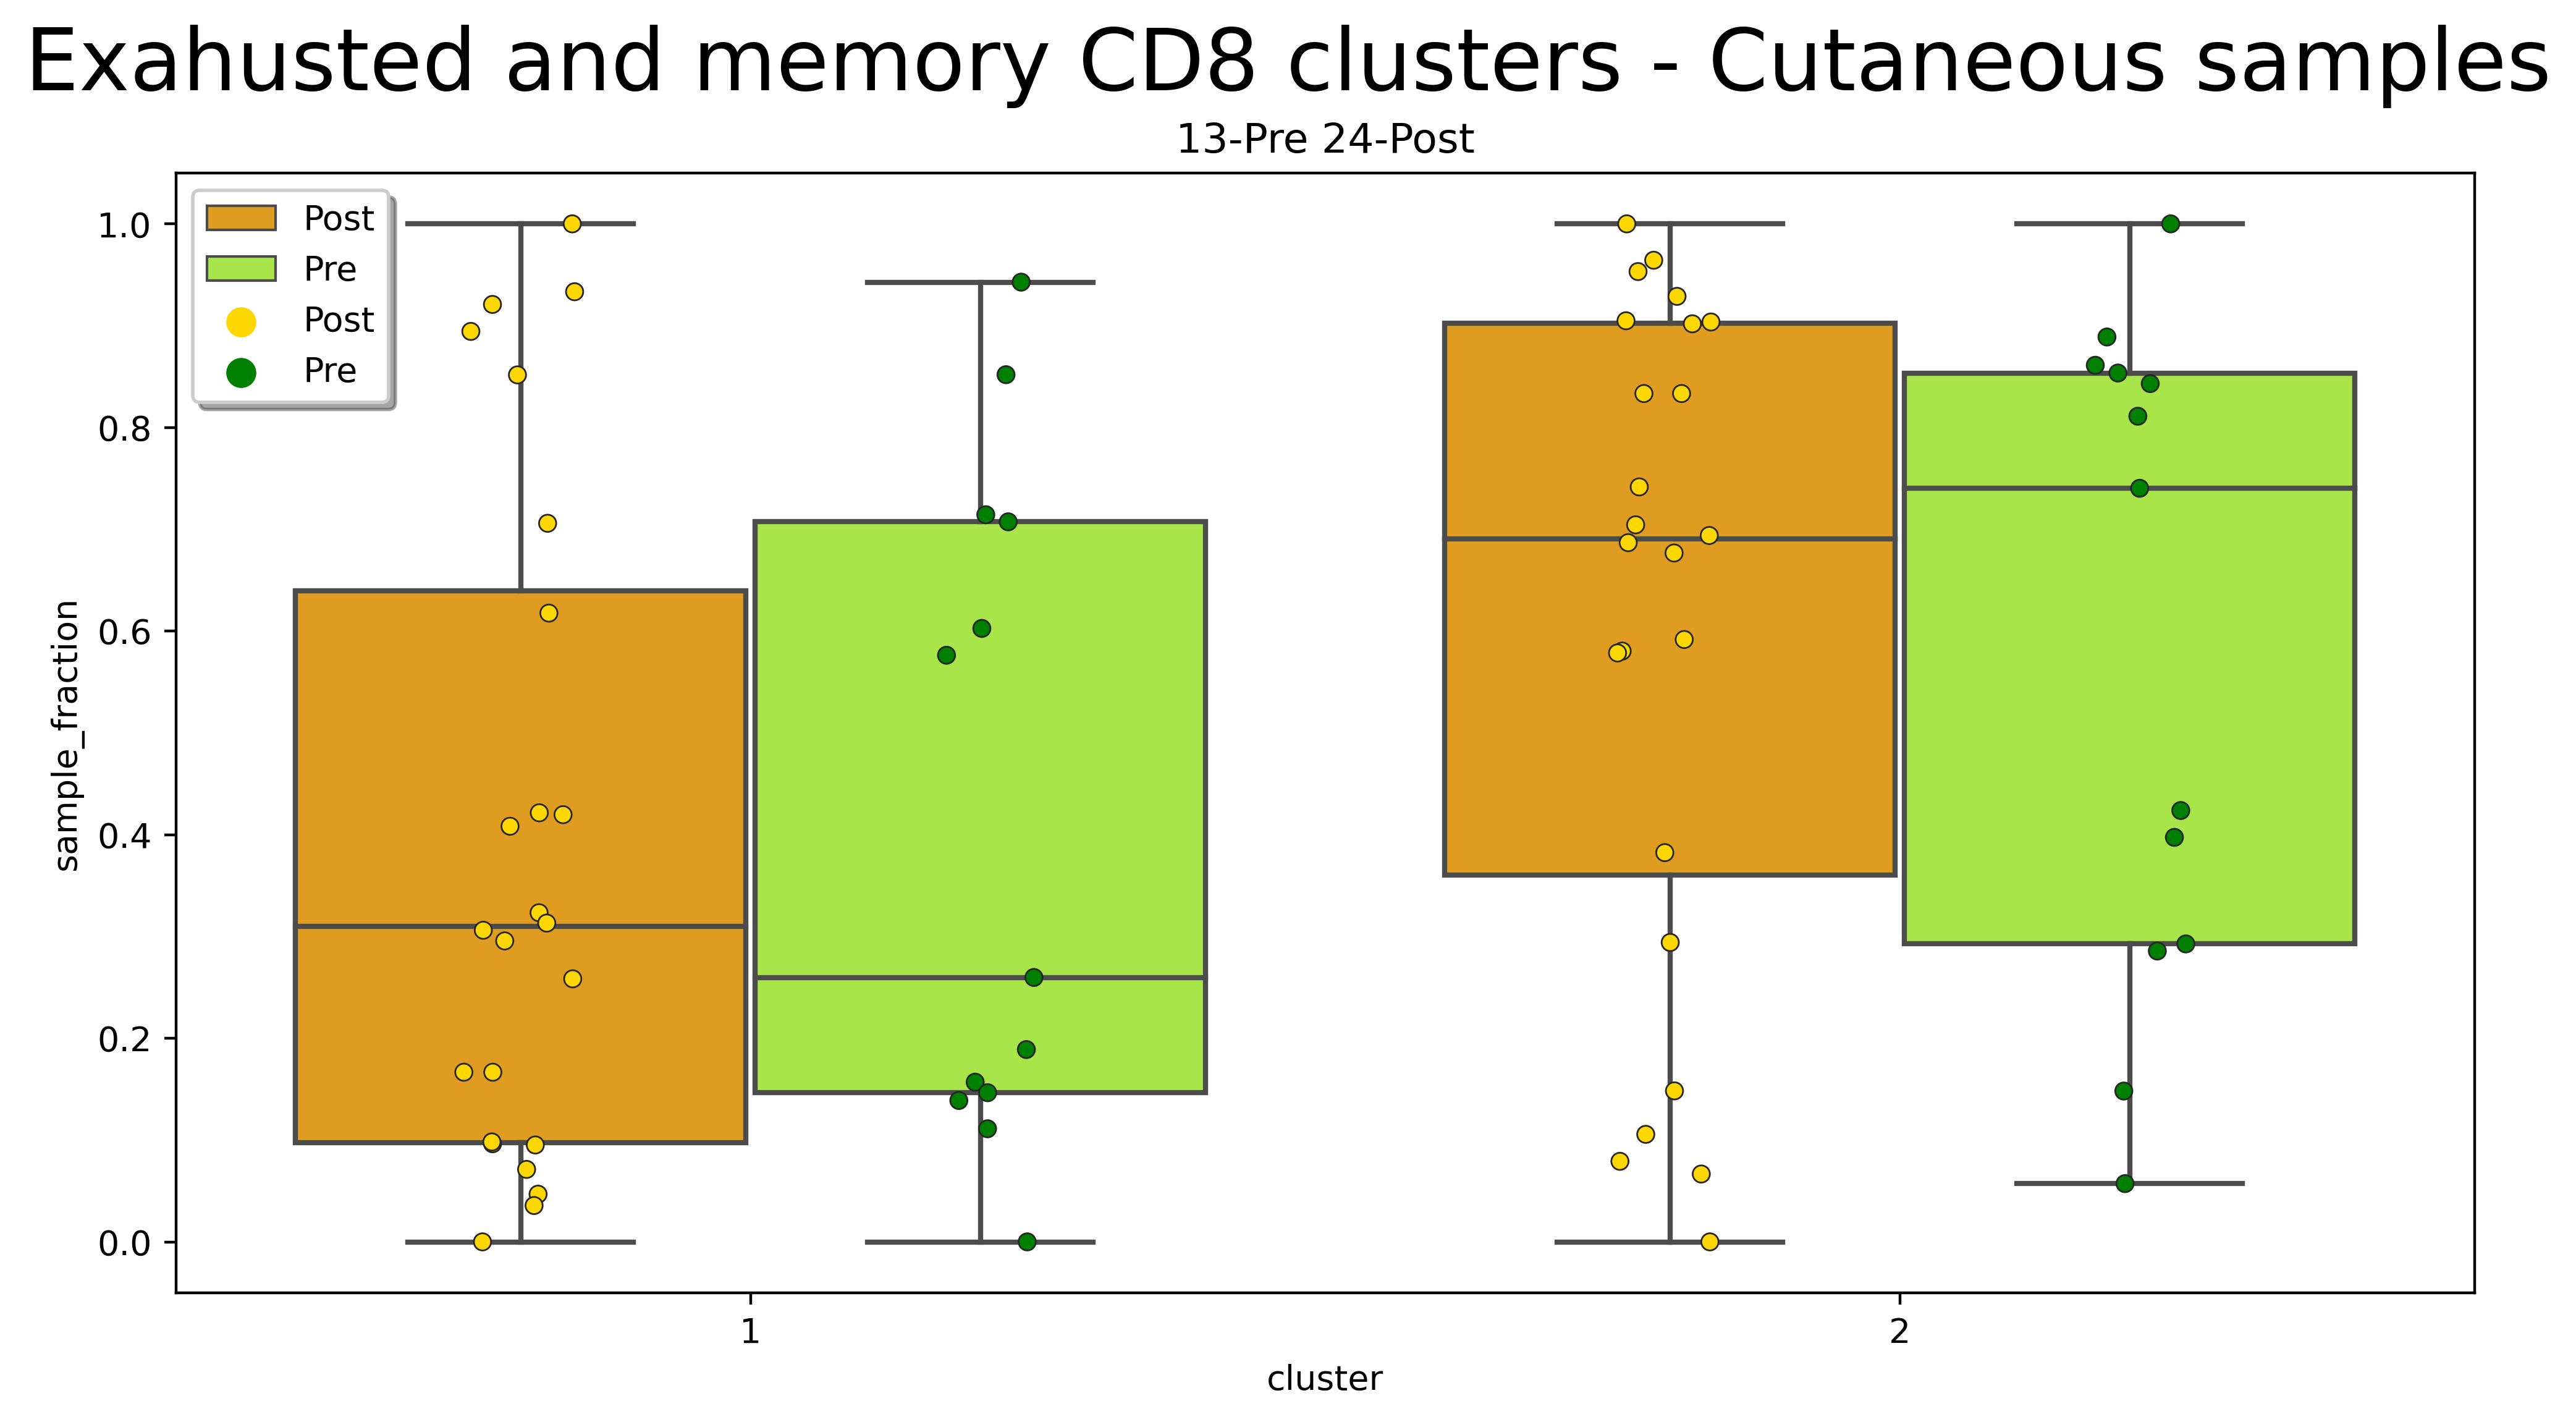

In [81]:
plt.figure(figsize=(12, 6))	# figsize



group_fractions = selected_group_fraction
pvals, corrected_pvals = get_pvals(group_fractions)


sns.boxplot(x="cluster", y="sample_fraction", hue='pre_post',  showfliers = False,
            palette={'Pre':'greenyellow', 'Post':'orange'}, data=group_fractions).set(title=str(cutaneous_melanoma_clinical_data['pre/post'].value_counts()["Pre"])+'-Pre ' + str(cutaneous_melanoma_clinical_data['pre/post'].value_counts()["Post"])+'-Post');
sns.stripplot(x='cluster', y='sample_fraction', hue='pre_post', data=group_fractions,
              jitter=True, dodge=True, linewidth=0.5, palette={'Pre':'g', 'Post':'gold'});

plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.suptitle(f'{cluster_group_name} clusters - Cutaneous samples', fontsize=25);
plt.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - Cutaneous samples.jpg'))

Entire cohort:

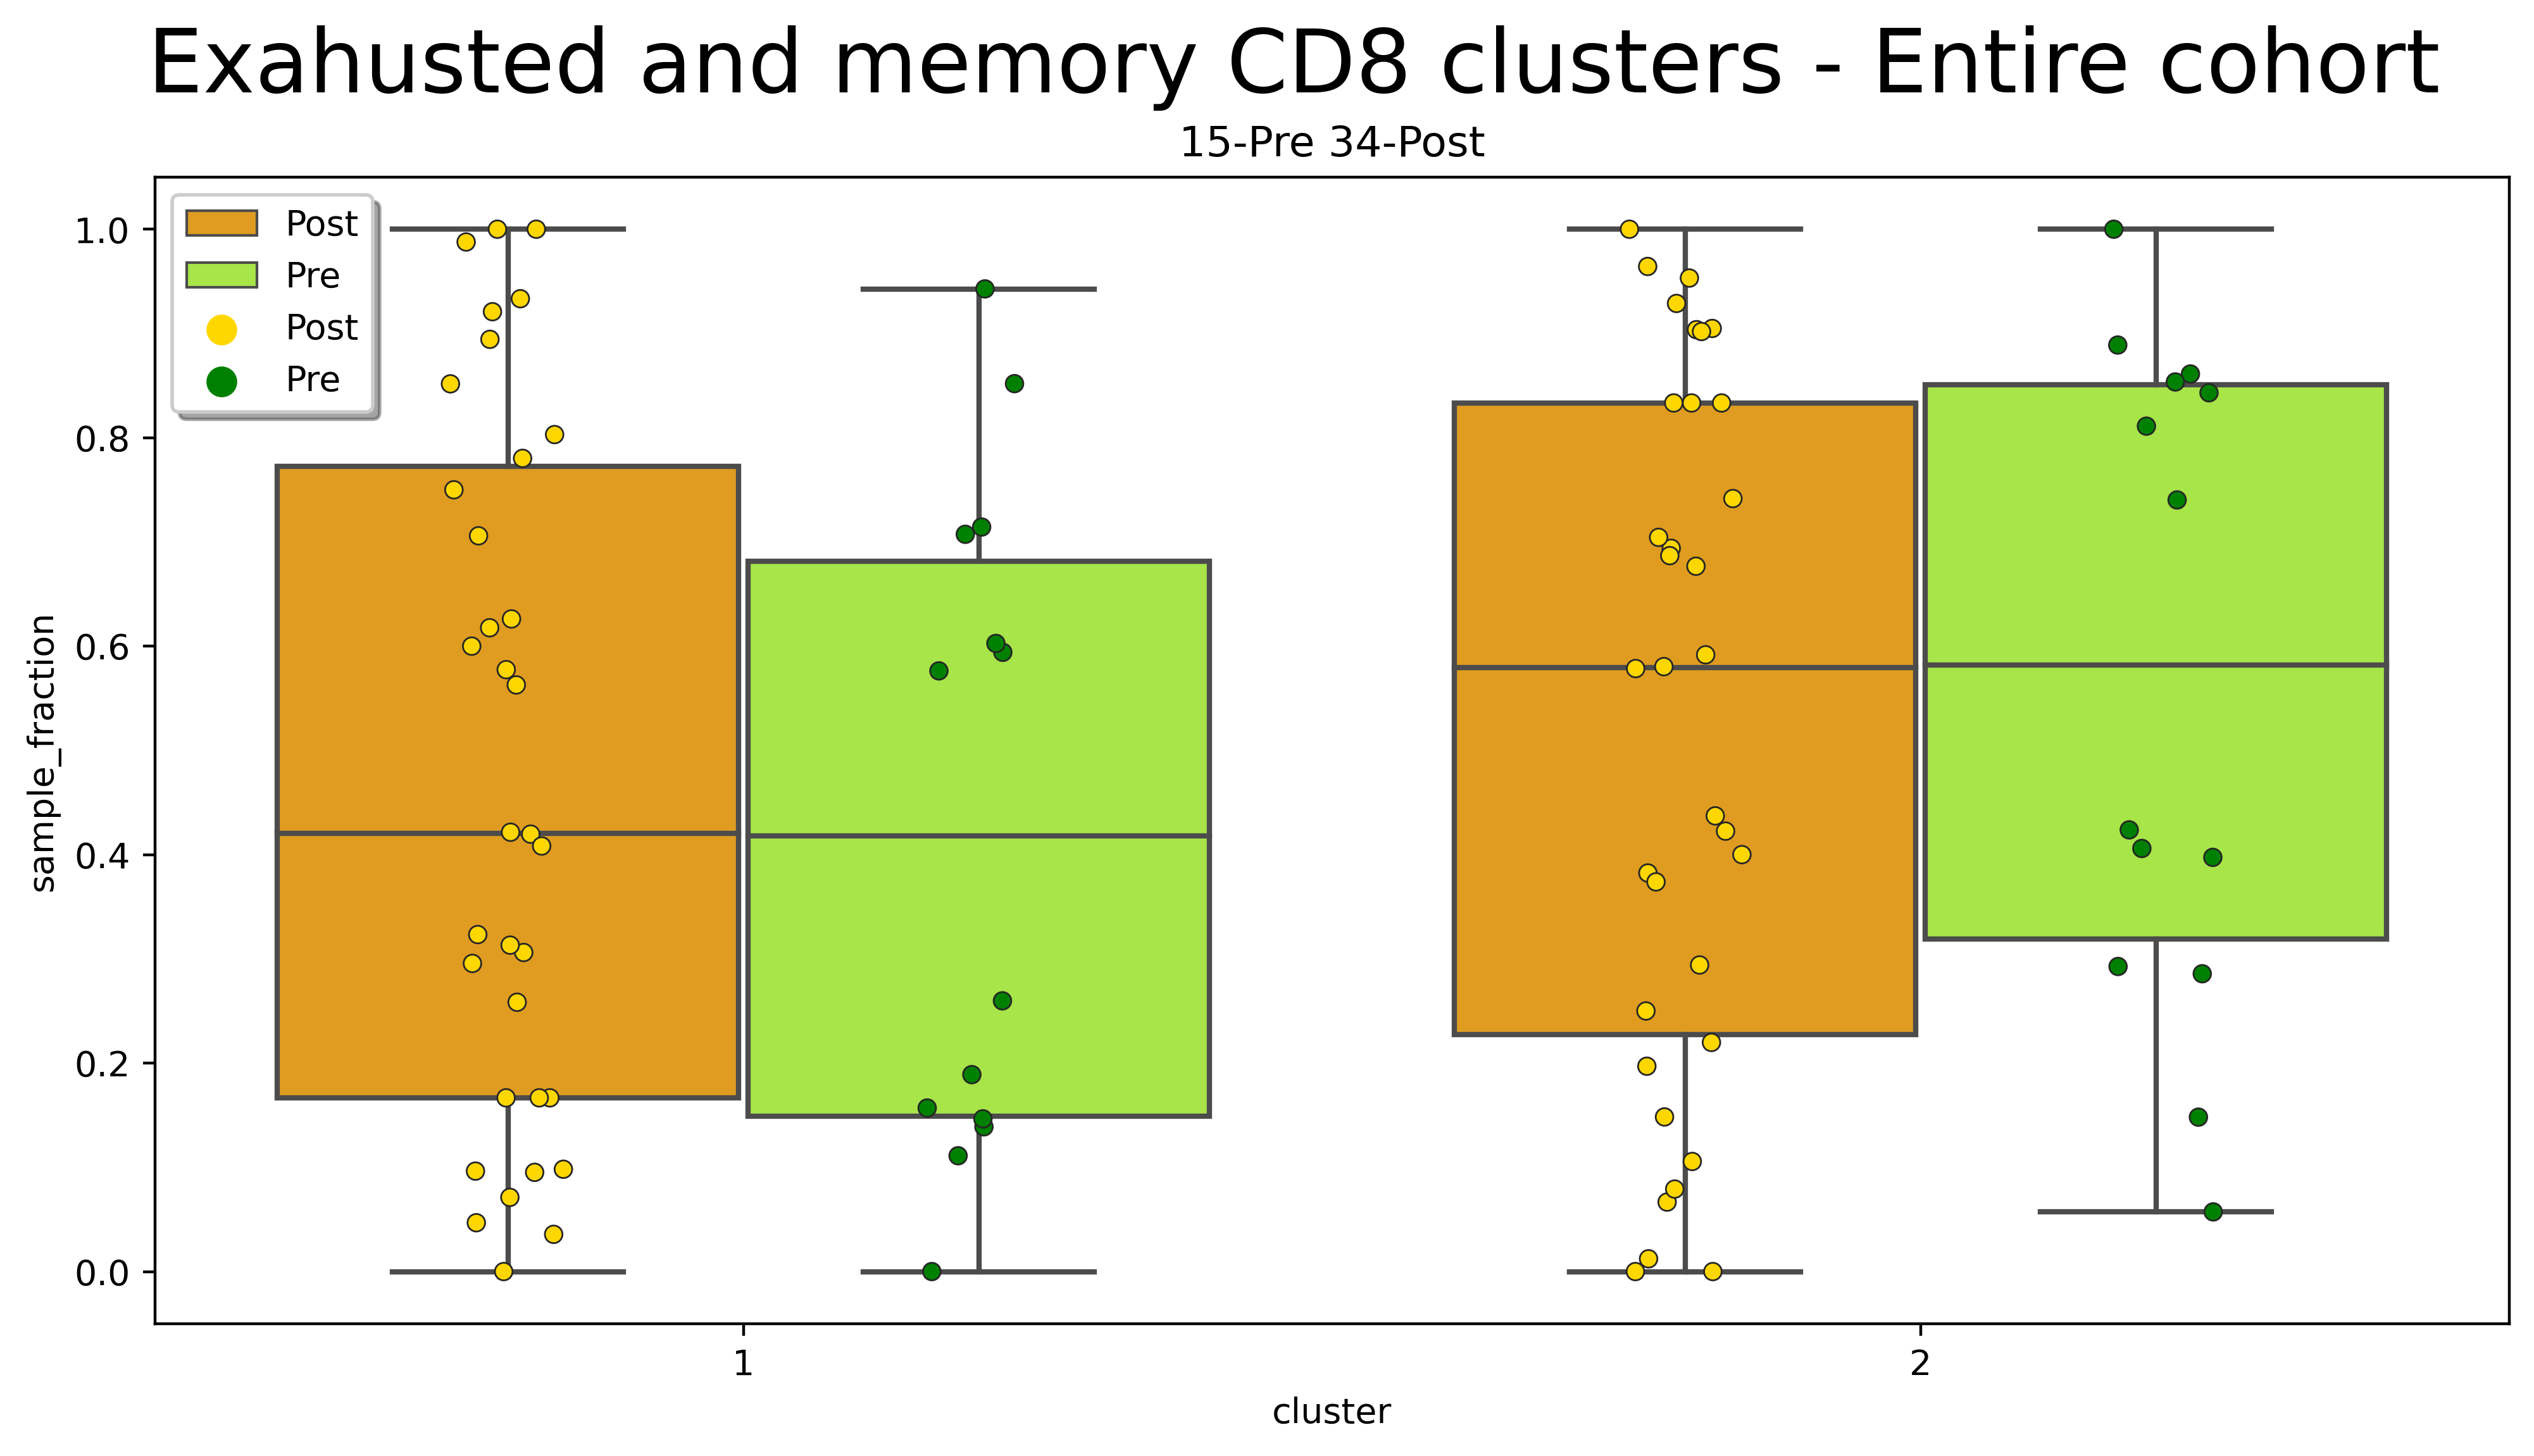

In [82]:
plt.figure(figsize=(12, 6))



group_fractions = full_selected_group_fraction
# pvals, corrected_pvals = get_pvals(group_fractions)


sns.boxplot(x="cluster", y="sample_fraction", hue='pre_post',  showfliers = False,
            palette={'Pre':'greenyellow', 'Post':'orange'}, data=group_fractions).set(title=str(full_melanoma_clinical_data['prePost'].value_counts()["Pre"])+'-Pre ' + str(full_melanoma_clinical_data['prePost'].value_counts()["Post"])+'-Post');
sns.stripplot(x='cluster', y='sample_fraction', hue='pre_post', data=group_fractions,
              jitter=True, dodge=True, linewidth=0.5, palette={'Pre':'g', 'Post':'gold'});

plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.suptitle(f'{cluster_group_name} clusters - Entire cohort', fontsize=25);
plt.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - Entire cohort.jpg'))

In [48]:
# f_CD8_cluster_fraction

## M11. Gublin study
### analysis R vs NR: subclustering

In [213]:
full_melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, response=['R', 'NR'], treatment=None)
treatment_translator = {'NIVO':'anti-PD1', 'PEMBRO':'anti-PD1', 'IPI + NIVO':'anti-PD1 + anti-CTLA4'}
full_melanoma_clinical_data['treatment_group'] = full_melanoma_clinical_data.apply(lambda x: 'Control' if x.prePost=='Pre' else treatment_translator[x.treatment], axis=1)
cutaneous_melanoma_clinical_data = full_melanoma_clinical_data[full_melanoma_clinical_data.MelanomaType == 'Cutaneous'].reset_index(drop=True)

In [214]:
# cutaneous_melanoma_clinical_data


In [215]:
# cutaneous_melanoma_clinical_data['treatment'] = cutaneous_melanoma_clinical_data.apply(lambda x: x.treatment_after if x.prePost=='Pre' else x.treatment_before, axis=1)

mono_therapy_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[(cutaneous_melanoma_clinical_data.treatment=='NIVO') | (cutaneous_melanoma_clinical_data.treatment=='PEMBRO')]
comb_therapy_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='IPI + NIVO']



comb_pre_cutaneous_melanoma_clinical_data = comb_therapy_cutaneous_melanoma_clinical_data[comb_therapy_cutaneous_melanoma_clinical_data.prePost == 'Pre']
comb_post_cutaneous_melanoma_clinical_data = comb_therapy_cutaneous_melanoma_clinical_data[comb_therapy_cutaneous_melanoma_clinical_data.prePost == 'Post']

mono_pre_cutaneous_melanoma_clinical_data = mono_therapy_cutaneous_melanoma_clinical_data[mono_therapy_cutaneous_melanoma_clinical_data.prePost == 'Pre']
mono_post_cutaneous_melanoma_clinical_data = mono_therapy_cutaneous_melanoma_clinical_data[mono_therapy_cutaneous_melanoma_clinical_data.prePost == 'Post']


In [216]:
def get_fraction_df(clustering_path):
    clustering_mapping_barcodes = pd.read_csv(clustering_path)
    cluster_fraction = get_cluster_fraction_df(clustering_mapping_barcodes)
    cluster_fraction = cluster_fraction[cluster_fraction['sample'].isin(full_melanoma_clinical_data.PatientId)]
    cluster_fraction['Response'] = cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data.PatientId==x].response.iloc[0])
    cluster_fraction['treatment'] = cluster_fraction['sample'].apply(lambda x: full_melanoma_clinical_data[full_melanoma_clinical_data.PatientId==x].treatment_group.iloc[0])
    return cluster_fraction

In [217]:
IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
myeloid_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
exh_mem_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'


immune_cluster_fraction = get_fraction_df(IMMUNE_CLUSTERING_PATH)
CD8_cluster_fraction = get_fraction_df(CD8_CLUSTERING_PATH)
myeloid_cluster_fraction = get_fraction_df(myeloid_CLUSTERING_PATH)
exh_mem_CD8_cluster_fraction = get_fraction_df(exh_mem_CD8_CLUSTERING_PATH)
GEP_fraction = get_arranged_GEP_fraction_df()

### Select group:

In [273]:
cluster_group_name = 'Exahusted and memory CD8'
OUTPUT_FOLDER = r'/storage/md_keren/shitay/outputs/thesis/clustering/statistical_tests/response/5.7.22'

###################################
if cluster_group_name=='CD8':
    selected_group_fraction = CD8_cluster_fraction
if cluster_group_name=='myeloid':
    selected_group_fraction = myeloid_cluster_fraction
if cluster_group_name=='immune':
    selected_group_fraction = immune_cluster_fraction
if cluster_group_name=='GEP':
    selected_group_fraction = GEP_fraction
if cluster_group_name=='Exahusted and memory CD8':
    selected_group_fraction = exh_mem_CD8_cluster_fraction
    
create_folder(join(OUTPUT_FOLDER, cluster_group_name))

folder: /storage/md_keren/shitay/outputs/thesis/clustering/statistical_tests/response/5.7.22/Exahusted and memory CD8 has been created


### Specify treatment division

In [274]:
# GROUP_NUM = 1

# if GROUP_NUM==1:
#     all_groups = {'Pre - anti-PD1 + anti-CTLA4':comb_pre_cutaneous_melanoma_clinical_data,
#      'Post - anti-PD1 + anti-CTLA4':comb_post_cutaneous_melanoma_clinical_data,
#      'Pre - anti-PD1':mono_pre_cutaneous_melanoma_clinical_data,
#      'Post - anti-PD1':mono_post_cutaneous_melanoma_clinical_data}
# else:
#     all_groups = {'anti-PD1 + anti-CTLA4':comb_therapy_cutaneous_melanoma_clinical_data,
#                  'anti-PD1':mono_therapy_cutaneous_melanoma_clinical_data}

In [275]:
all_groups = {'Pre - anti-PD1 + anti-CTLA4':comb_pre_cutaneous_melanoma_clinical_data,
     'Post - anti-PD1 + anti-CTLA4':comb_post_cutaneous_melanoma_clinical_data,
     'Pre - anti-PD1':mono_pre_cutaneous_melanoma_clinical_data,
     'Post - anti-PD1':mono_post_cutaneous_melanoma_clinical_data}

In [277]:
all_groups = {'anti-PD1 + anti-CTLA4':comb_therapy_cutaneous_melanoma_clinical_data,
                 'anti-PD1':mono_therapy_cutaneous_melanoma_clinical_data}

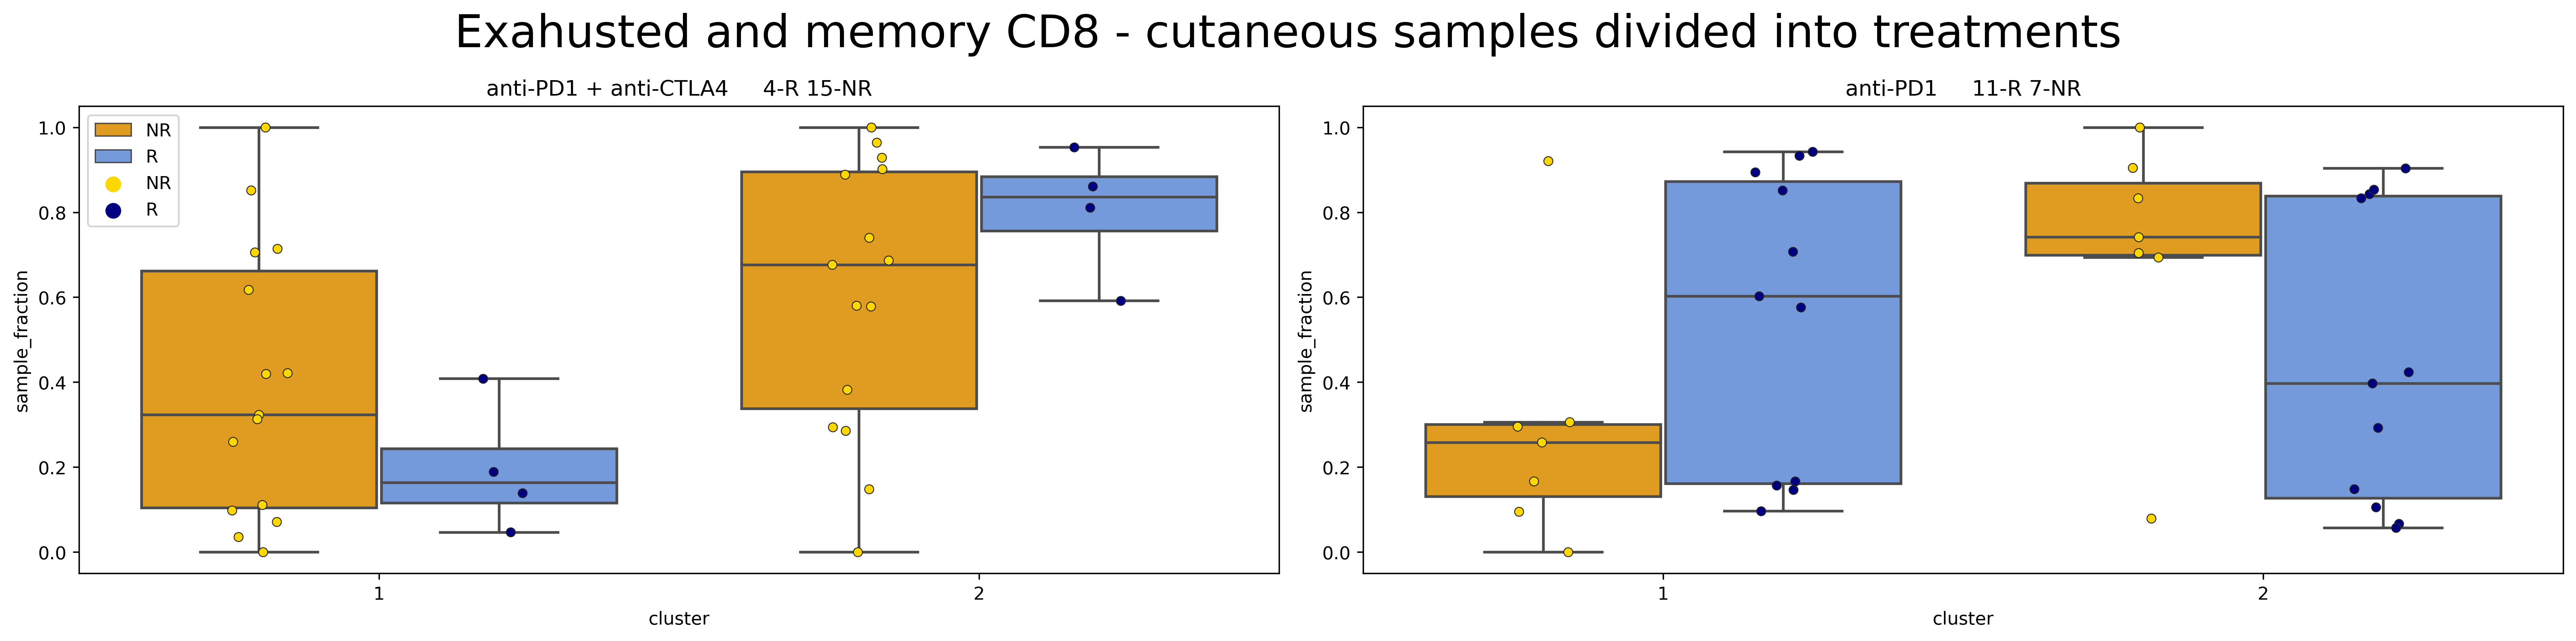

In [278]:
(fig,axes) = plt.subplots(int(len(all_groups)/2), 2, figsize=(20, int(5*len(all_groups)/2)))
axes = axes.ravel()
# pre_post = '' if len(all_groups)==2 else ', Pre/Post'

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = selected_group_fraction[selected_group_fraction['sample'].isin(group_df.PatientId)]
#     pvals, corrected_pvals = get_pvals(group_fractions)
#     group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    fold_change_df = get_fold_change_R_vs_NR_df(group_fractions)
    fold_change_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/FC_{group_name}_cutaneous.xlsx'))
    
    sns.boxplot(ax=axes[idx], x="cluster", y="sample_fraction", hue='Response',  showfliers = False,
                palette={'R':'cornflowerblue', 'NR':'orange'}, data=group_fractions).set(title=group_name+'     '+str(group_df['response'].value_counts()["R"])+'-R ' + str(group_df['response'].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'R':'navy', 'NR':'gold'});
    
    axes[idx].legend(loc='upper left')
    if idx>0:
        axes[idx].get_legend().remove()
    



if len(all_groups)==2:
    fig.suptitle(f'{cluster_group_name} - cutaneous samples divided into treatments', fontsize=25);
else:
    fig.suptitle(f'{cluster_group_name} - cutaneous samples divided into treatments and biopsy time', fontsize=25);
plt.tight_layout(pad=1)
# fig.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - {len(all_groups)} groups.jpg'))

Cutaneous samples:

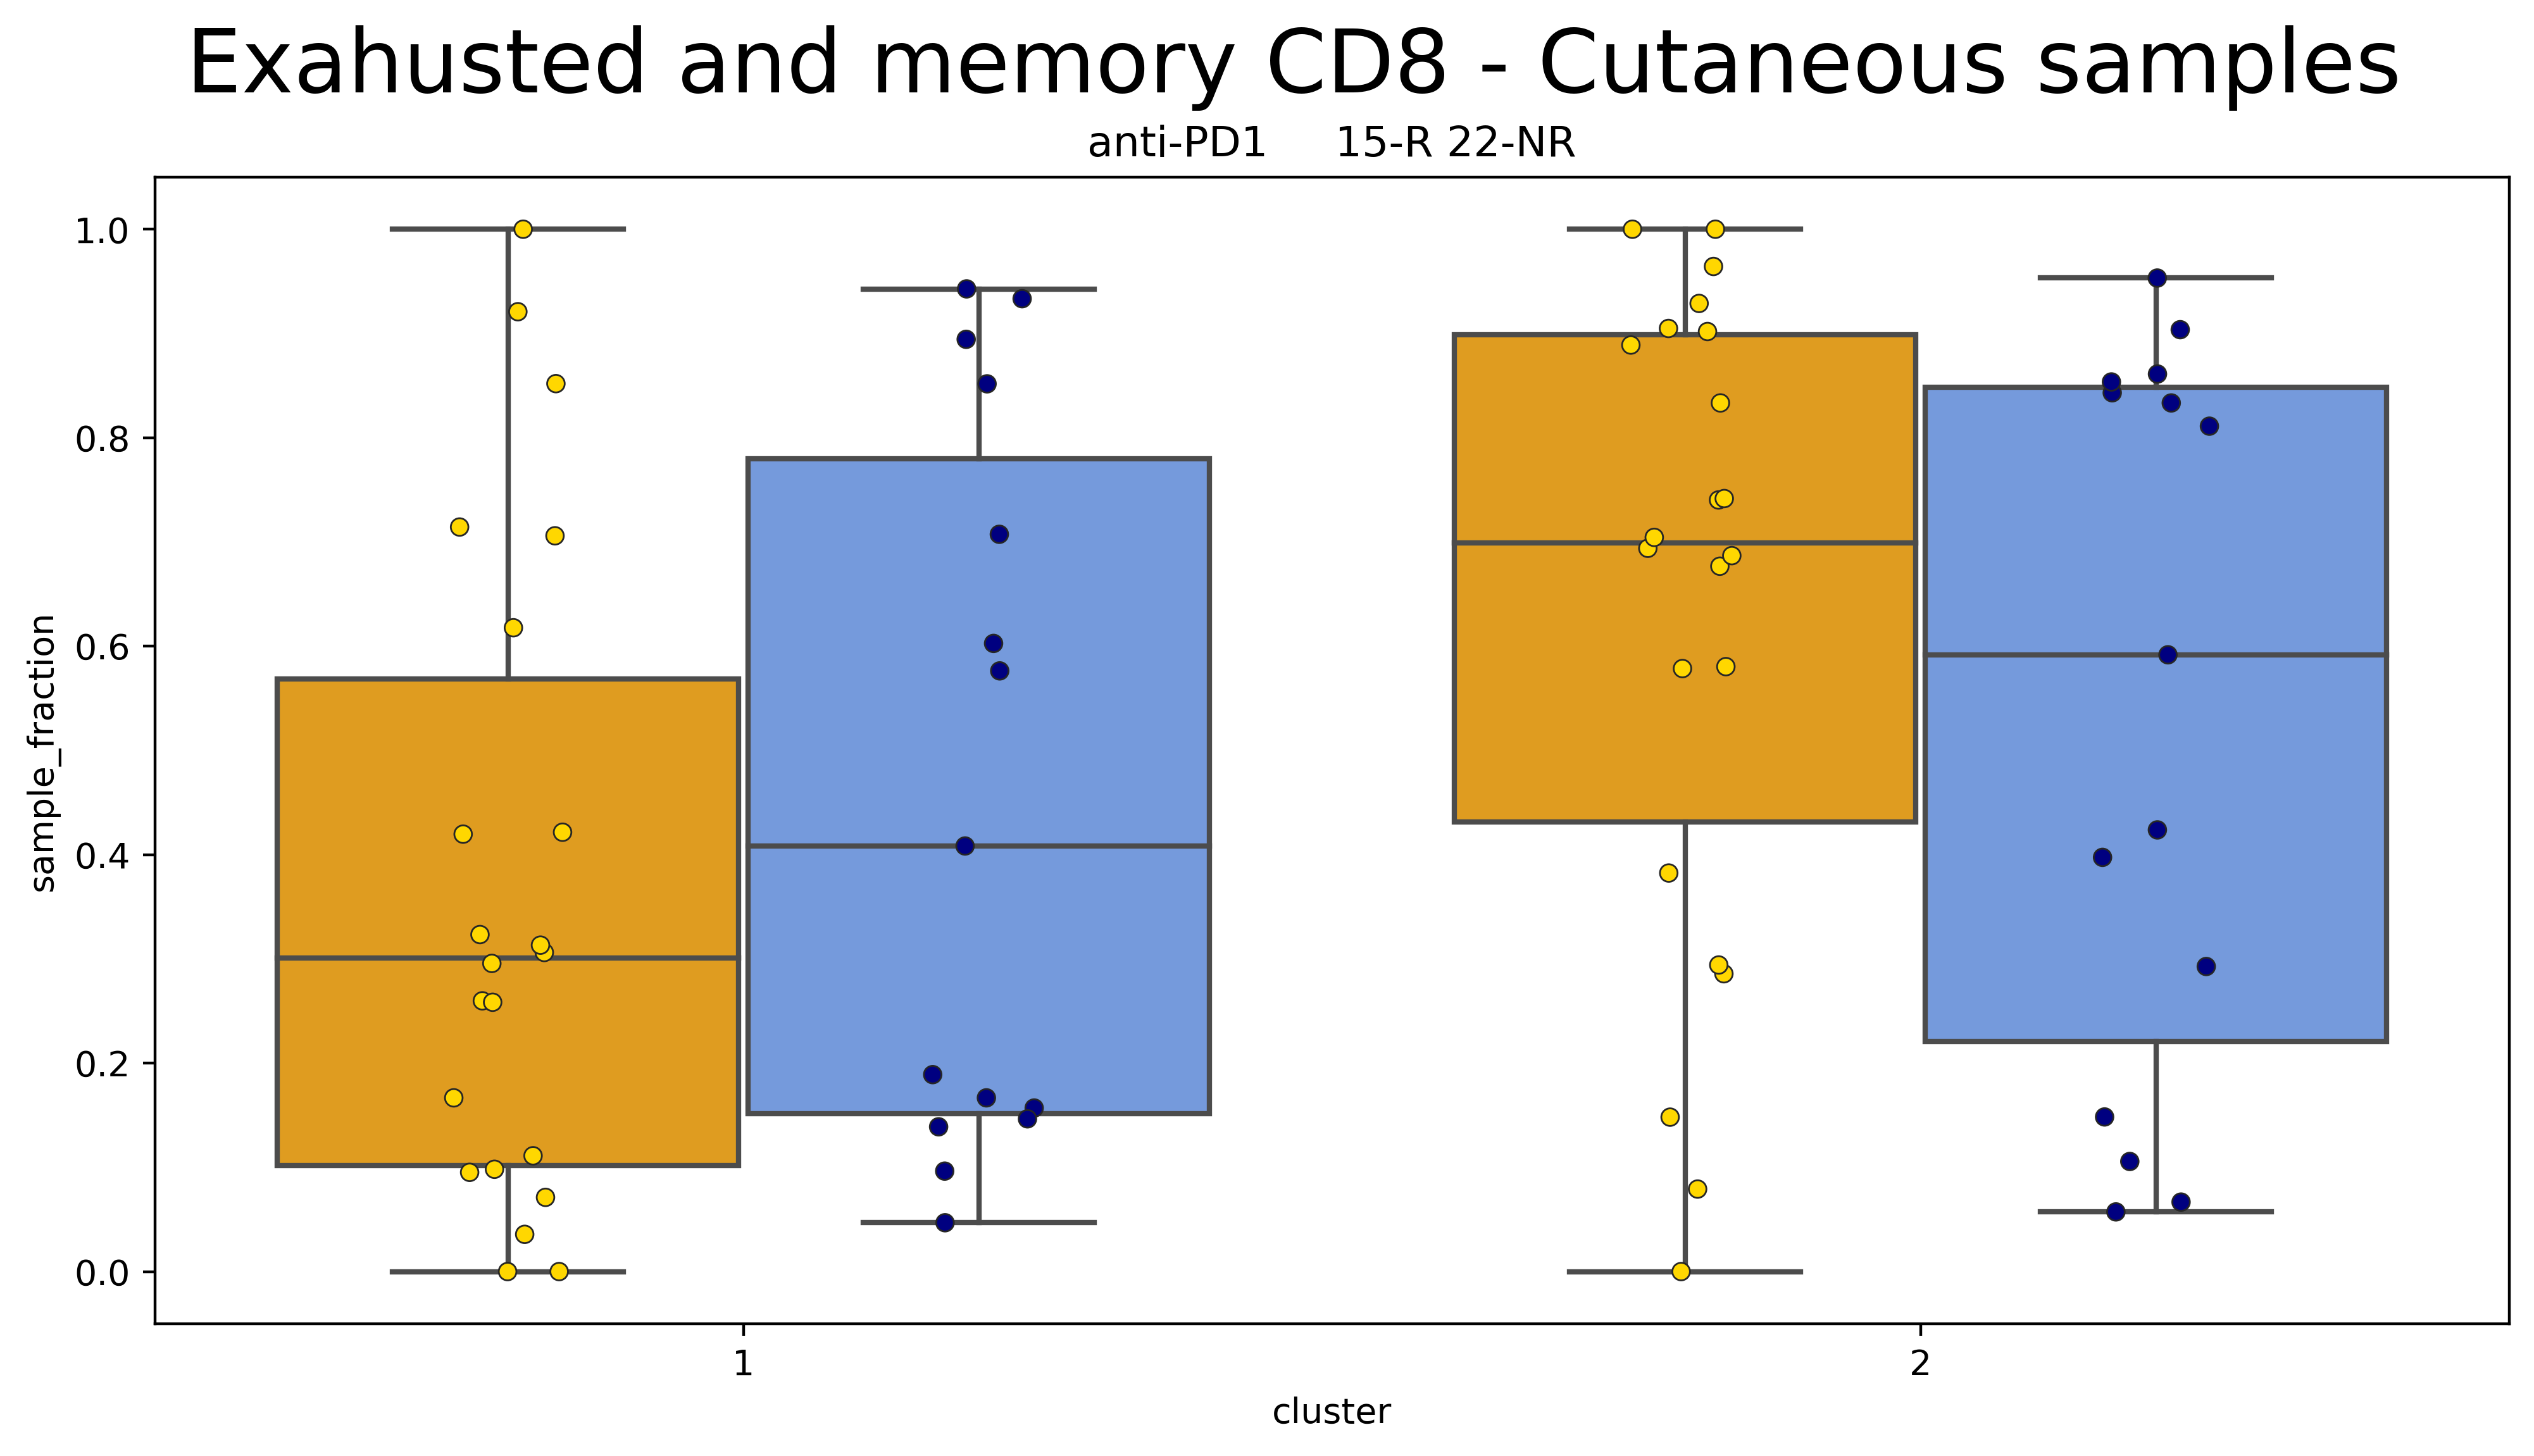

In [279]:
plt.figure(figsize=(12, 6))	# figsize


group_fractions = selected_group_fraction[selected_group_fraction['sample'].isin(cutaneous_melanoma_clinical_data.PatientId)]

# pvals, corrected_pvals = get_pvals(group_fractions)

fold_change_df = get_fold_change_R_vs_NR_df(group_fractions)
sns.boxplot(x="cluster", y="sample_fraction", hue='Response',  showfliers = False,
            palette={'R':'cornflowerblue', 'NR':'orange'}, data=group_fractions).set(title=group_name+'     '+str(cutaneous_melanoma_clinical_data['response'].value_counts()["R"])+'-R ' + str(cutaneous_melanoma_clinical_data['response'].value_counts()["NR"])+'-NR');
sns.stripplot(x='cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'R':'navy', 'NR':'gold'});

plt.legend(loc='upper left').set_visible(False)
plt.suptitle(f'{cluster_group_name} - Cutaneous samples', fontsize=25);

fold_change_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/FC_cutaneous_samples.xlsx'))
# plt.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - cutaneous samples.jpg'))

Enitre cohort:

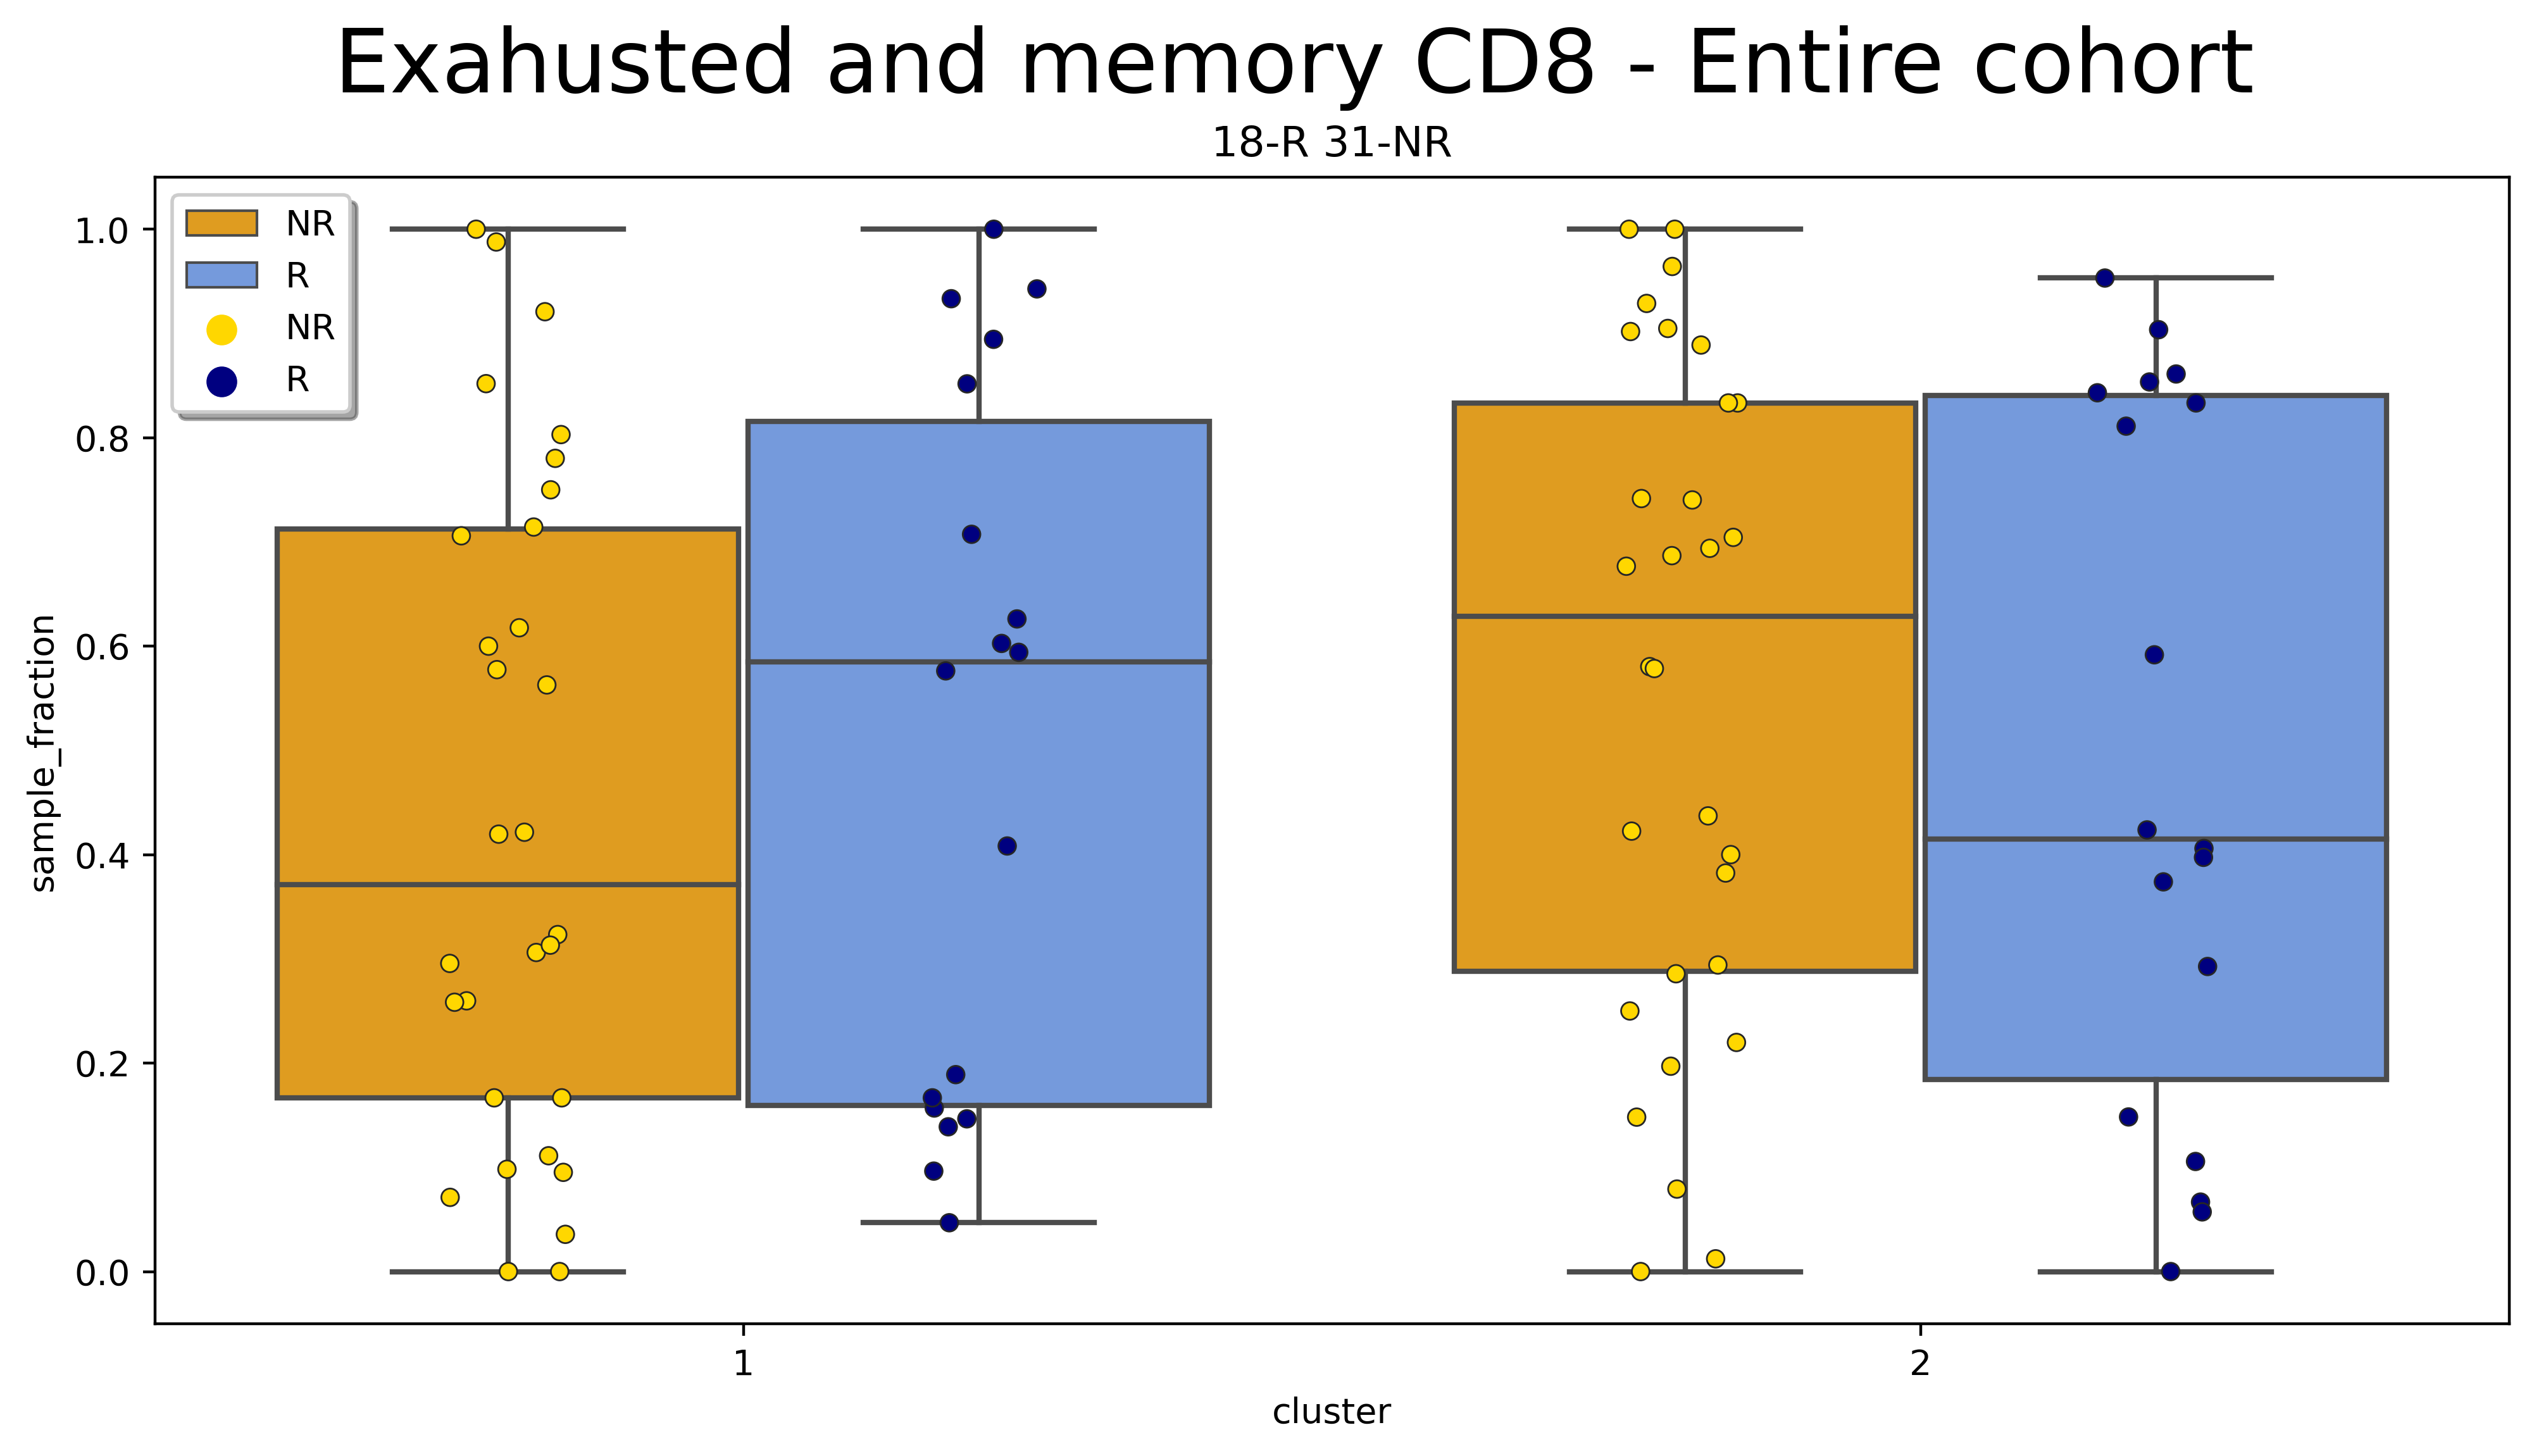

In [280]:
plt.figure(figsize=(12, 6))



group_fractions = selected_group_fraction
# pvals, corrected_pvals = get_pvals(group_fractions)
fold_change_df = get_fold_change_R_vs_NR_df(group_fractions)

sns.boxplot(x="cluster", y="sample_fraction", hue='Response',  showfliers = False,
            palette={'R':'cornflowerblue', 'NR':'orange'}, data=group_fractions).set(title=str(full_melanoma_clinical_data['response'].value_counts()["R"])+'-R ' + str(full_melanoma_clinical_data['response'].value_counts()["NR"])+'-NR');
sns.stripplot(x='cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'R':'navy', 'NR':'gold'});

plt.legend(loc='upper left', fancybox=True, shadow=True)#.set_visible(False)

plt.suptitle(f'{cluster_group_name} - Entire cohort', fontsize=25);

fold_change_df.to_excel(join(OUTPUT_FOLDER, fr'{cluster_group_name}/FC_entire_cohort.xlsx'))
# plt.savefig(join(OUTPUT_FOLDER, cluster_group_name, fr'{cluster_group_name} - Entire cohort.jpg'))

In [239]:
# def get_fold_change_R_vs_NR_df(group_fractions):
#     fold_change_df = group_fractions.groupby(['Response', 'cluster']).median('sample_fraction').reset_index()
#     fold_change_df = fold_change_df.pivot_table(index='cluster', columns='Response') + 0.001
#     fold_change_df.columns = [v[1] for v in fold_change_df.columns]
#     fold_change_df

#     one_side = (fold_change_df['R'] / fold_change_df['NR']).values.round(2).astype(str)
#     second_side = (fold_change_df['NR'] / fold_change_df['R']).values.round(2).astype(str)
#     FC = [', '.join(vv) for vv in np.array([one_side, second_side]).T]
#     fold_change_df['FC'] = FC

#     fold_change_df['R'] = fold_change_df['R'].round(3)
#     fold_change_df['NR'] = fold_change_df['NR'].round(3)
#     return fold_change_df
# 


# M12. create Clustering figures 

In [18]:
# TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/CD8/CD8_bhtsne_5.5.22.csv'
# CLUSTERING_MAPPING_PATH = '/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
# ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/CD8_clustering_11.8.21_ann.xlsx'
# OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/thesis/clustering/CD8'
# title='CD8 clustering'

# TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/immune/immune_bhtsne_5.5.22.csv'
# CLUSTERING_MAPPING_PATH = '/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
# ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/Immune_clustering_26.6.21_ann.xlsx'
# OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/thesis/clustering/immune'
# title='immune clustering'

TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/myeloid/myeloid_bhtsne_5.5.22.csv'
CLUSTERING_MAPPING_PATH = '/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/Myeloid_clustering_11.8.21_ann.xlsx'
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/thesis/clustering/myeloid'
title='Myeloid clustering'


# ANNOTATION_PATH = r'/storage/md_keren/shitay/Data/tables/clustering_annotations/cohort_4.11.21/python_format/Immune_clustering_26.6.21_ann.xlsx'


In [19]:
tsne_df = pd.read_csv(TSNE_PATH)
clustering_mapping = pd.read_csv(CLUSTERING_MAPPING_PATH)
ann_df = pd.read_excel(ANNOTATION_PATH).set_index('cluster')
# ann_df
# all_clusters_idx
# tsne_df.drop(columns=['Unnamed: 0']).to_csv(TSNE_PATH, index=False)
# clustering_mapping.drop(columns=['Unnamed: 0']).to_csv(CLUSTERING_MAPPING_PATH, index=False)

In [20]:
clustering_tsne_merged_df = pd.merge(clustering_mapping, tsne_df)
# clustering_tsne_merged_df
# clustering_mapping
# tsne_df

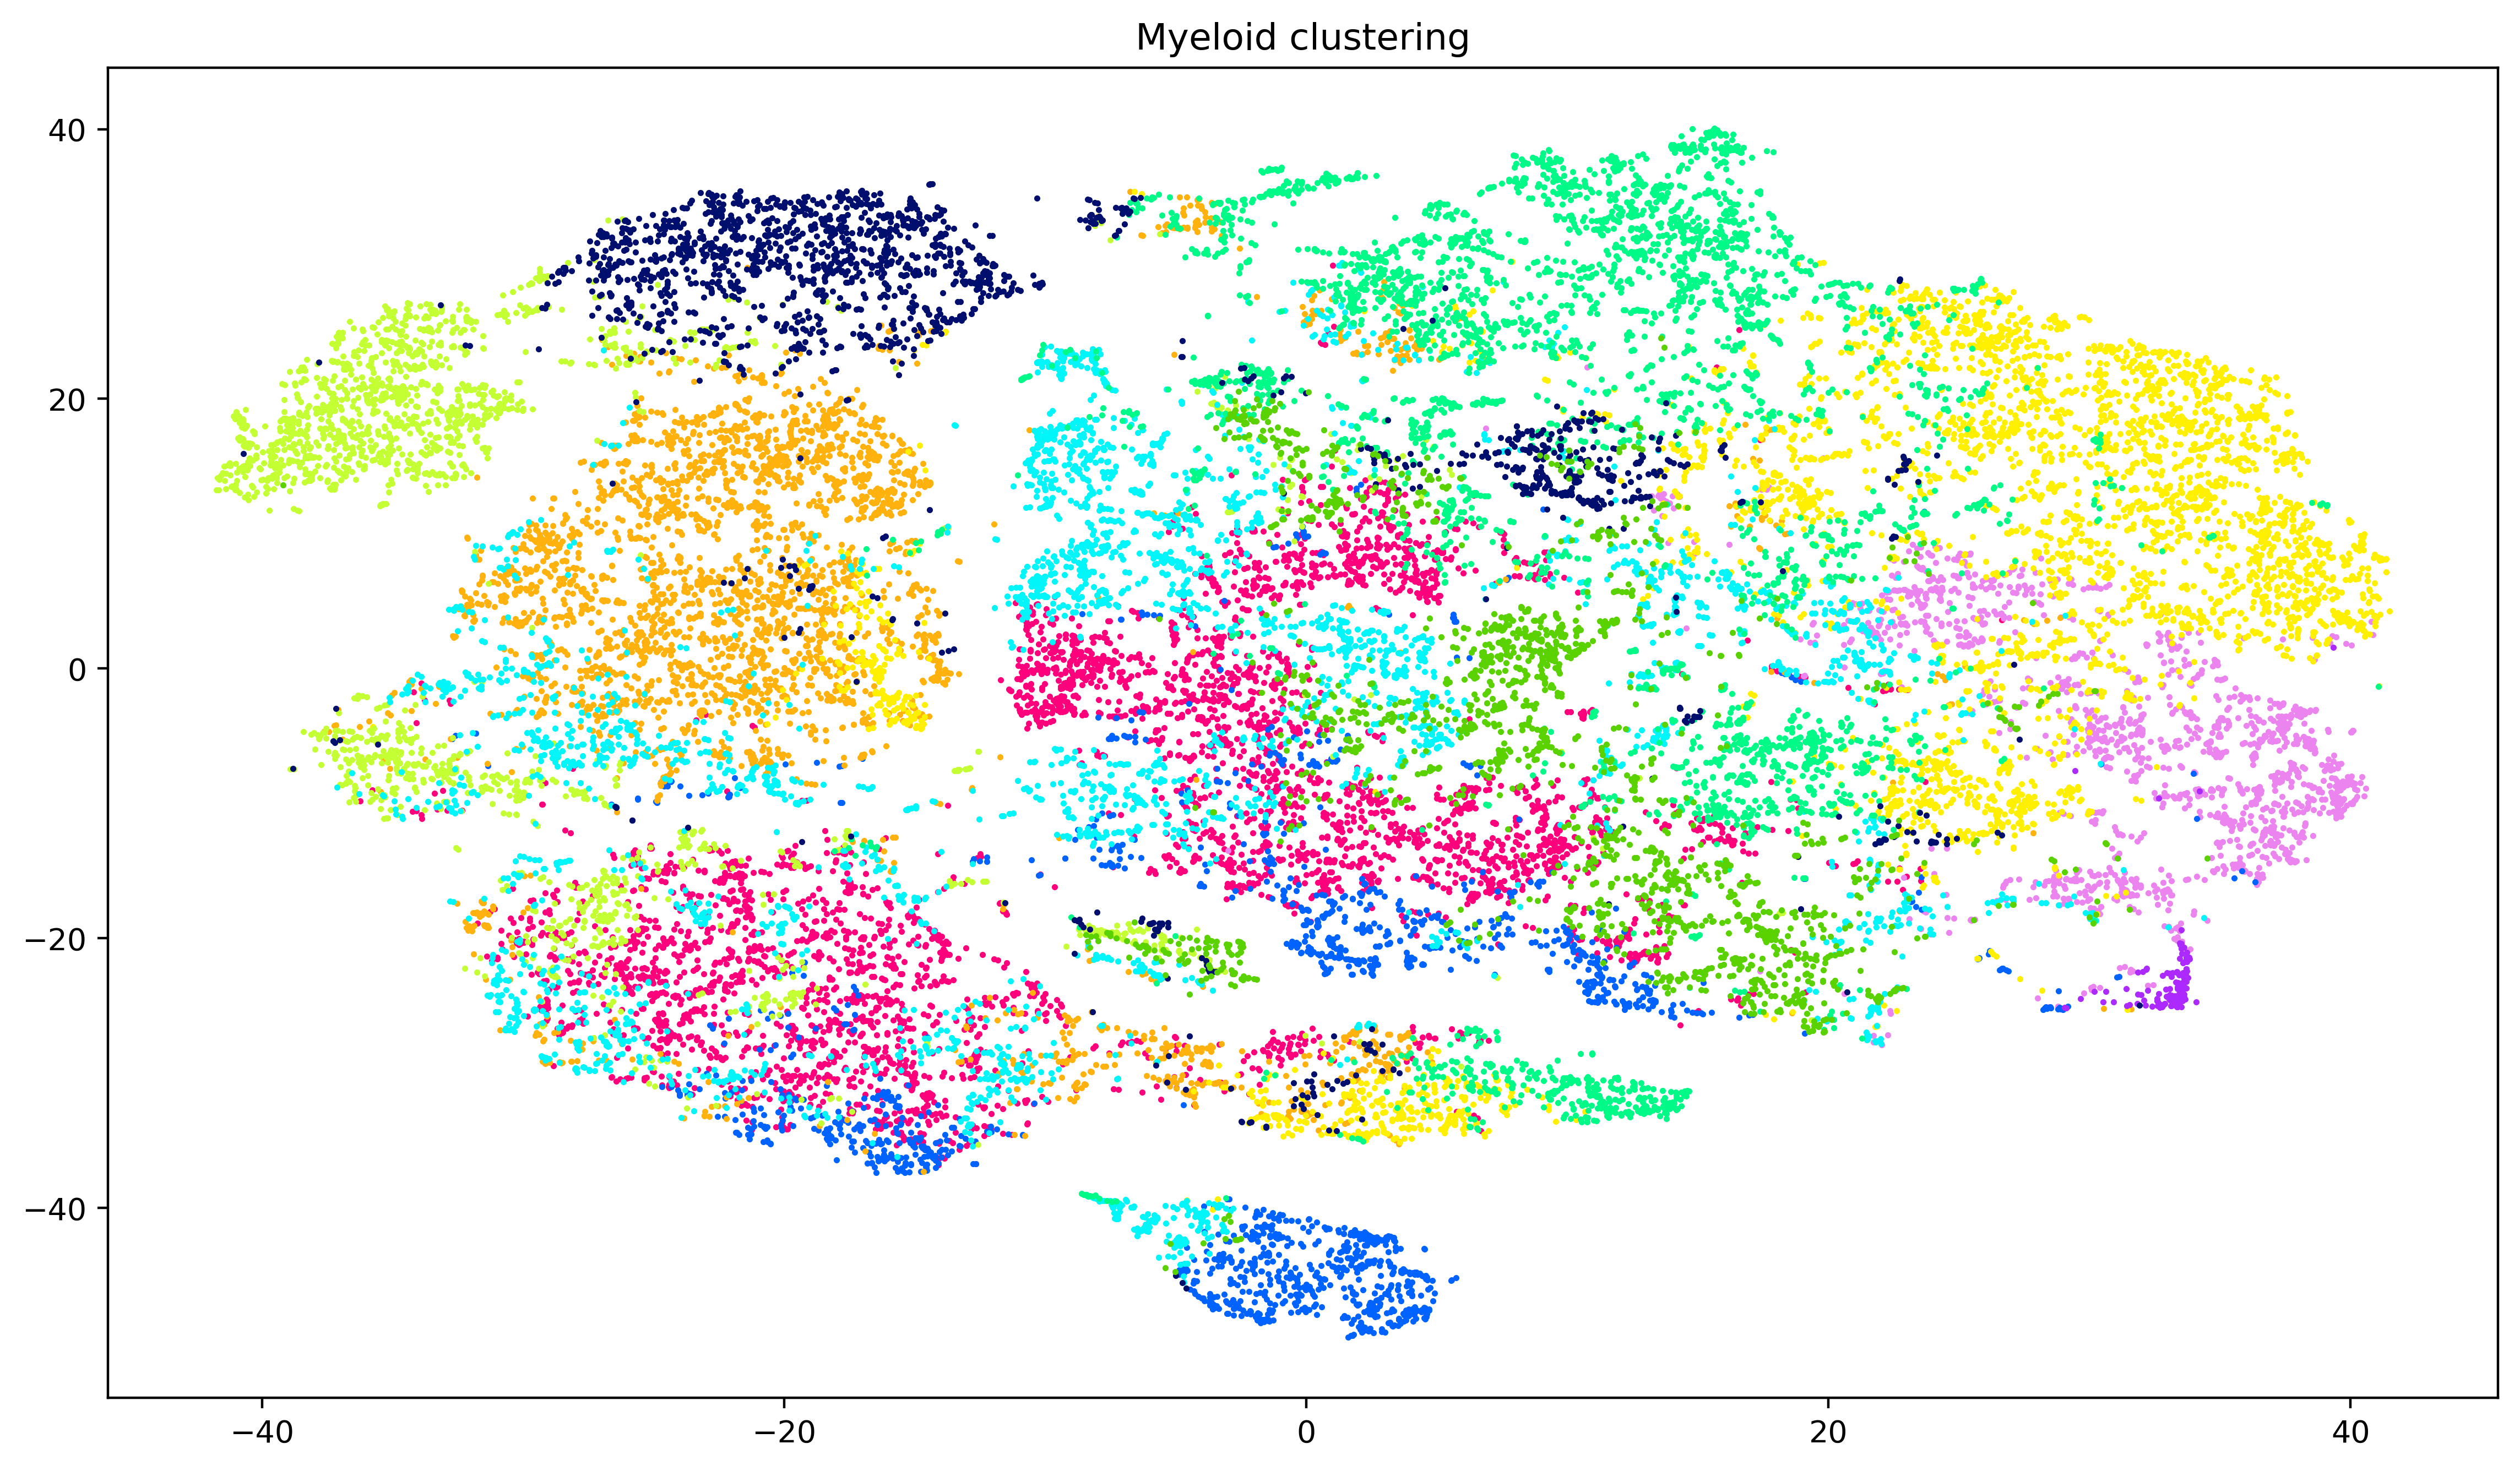

In [21]:
all_clusters_idx = list(set(clustering_tsne_merged_df.Cluster))



plt.rcParams["figure.figsize"] = 14, 8 #plt.rcParamsDefault["figure.figsize"]
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]
# colors = np.array([colormap(i) for i in np.linspace(0, 0.9,15)])[[2, 5, 11, 10, 0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 14]]
# plt.rcParams['font.size'] = '16'

for cluster_idx in all_clusters_idx:
    Xi = clustering_tsne_merged_df[clustering_tsne_merged_df.Cluster == cluster_idx].x.values#[-2]
    Yi = clustering_tsne_merged_df[clustering_tsne_merged_df.Cluster == cluster_idx].y.values#[-2]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx-1], label=f'M{cluster_idx}. {ann_df.loc[cluster_idx].annotation}', markersize=1, linestyle='')

plt.title(title);
# plt.show()

# remove if you dont want to save
# plt.savefig(join(OUTPUT_PATH, r'tSNE.jpg'))

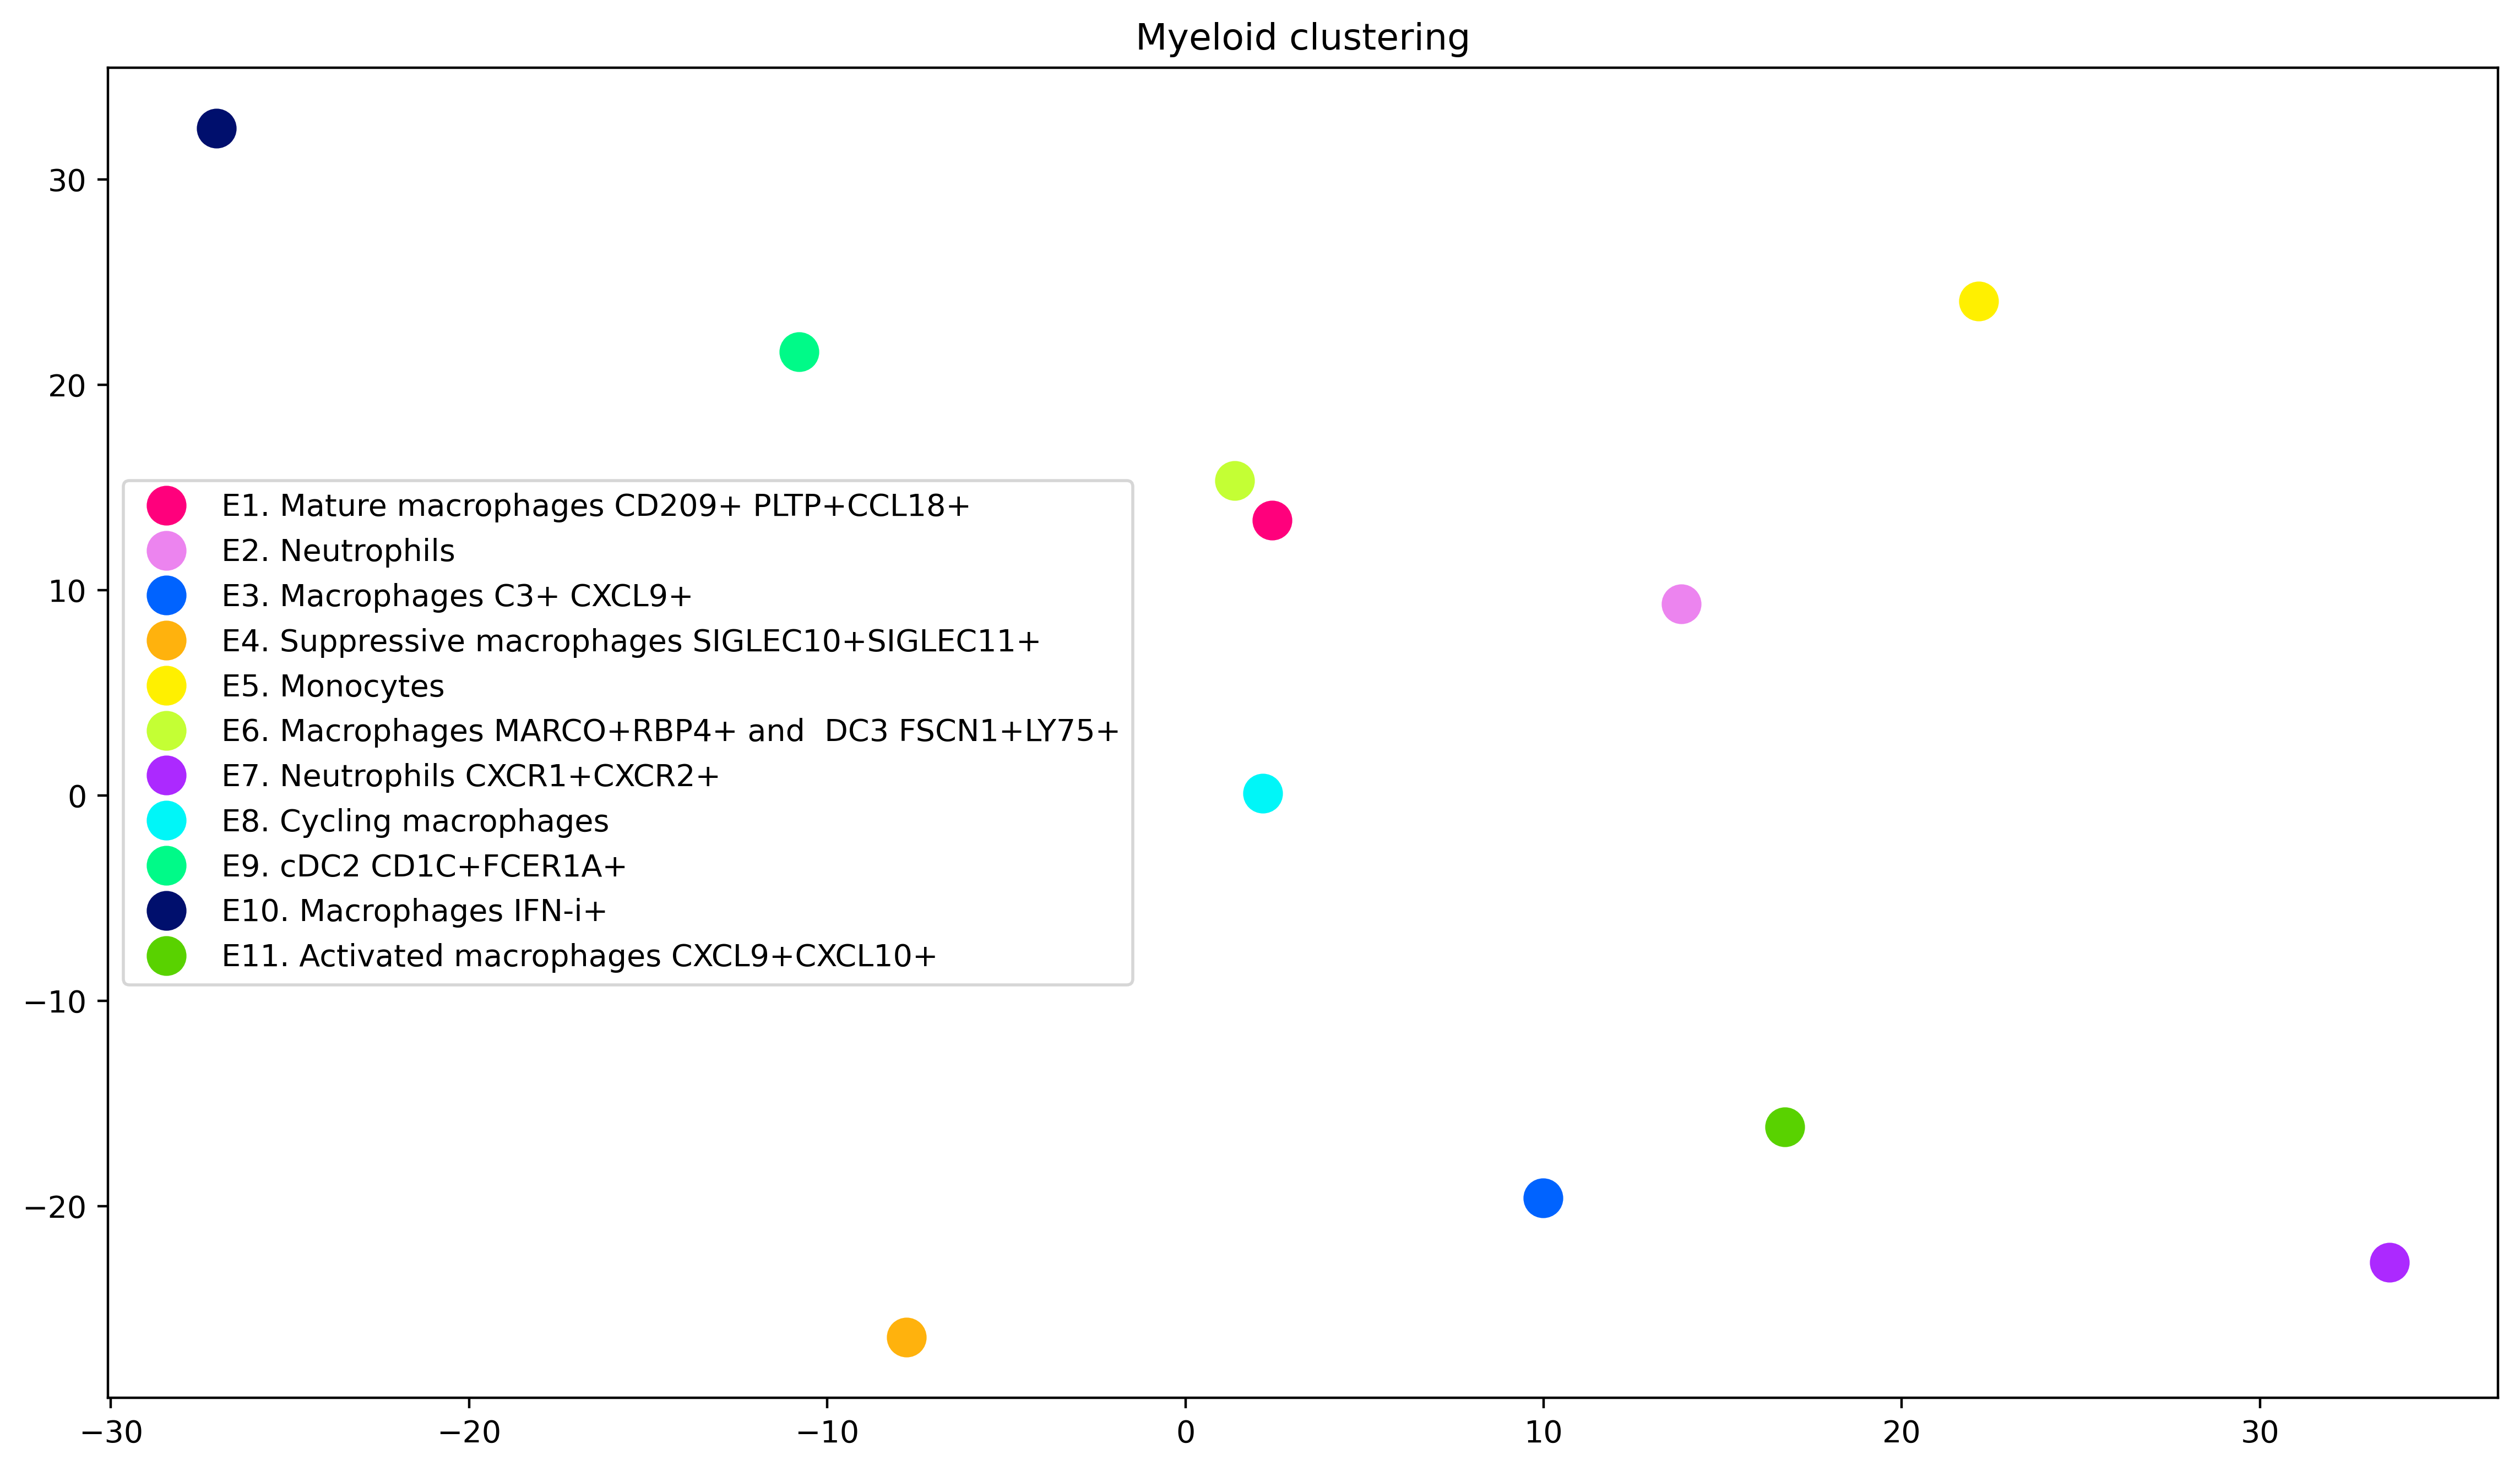

In [23]:
all_clusters_idx = list(set(clustering_tsne_merged_df.Cluster))

plt.rcParams["figure.figsize"] = 14, 8 #plt.rcParamsDefault["figure.figsize"]
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]

for cluster_idx in all_clusters_idx:
    Xi = clustering_tsne_merged_df[clustering_tsne_merged_df.Cluster == cluster_idx].x.values[-2]
    Yi = clustering_tsne_merged_df[clustering_tsne_merged_df.Cluster == cluster_idx].y.values[-2]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx-1], label=f'E{cluster_idx}. {ann_df.loc[cluster_idx].annotation}', markersize=12, linestyle='')
    plt.legend()

plt.title(title);
# plt.show()

# remove if you dont want to save
plt.savefig(join(OUTPUT_PATH, r'labels.jpg'))

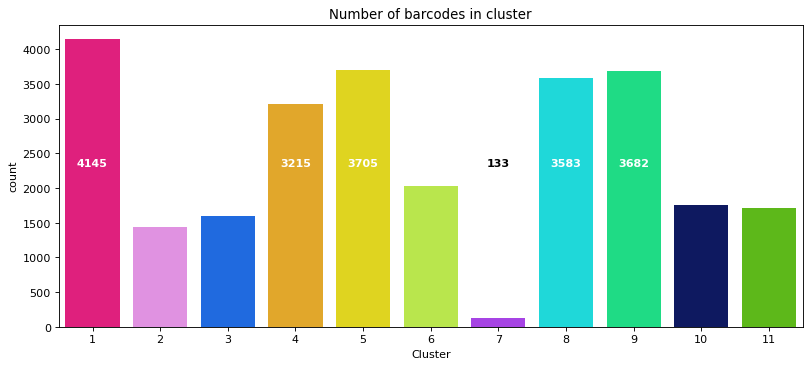

In [23]:
all_clusters_idx = list(set(clustering_tsne_merged_df.Cluster))

sns.reset_orig() # reset size of figure
fig = plt.figure(figsize=(12, 5), dpi=80);
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]
palette_clustering = {cluster_idx:colors[cluster_idx-1] for cluster_idx in all_clusters_idx}

ax = sns.countplot(x="Cluster", data=clustering_tsne_merged_df, palette=palette_clustering)#palette="Set1")
ax.set(title='Number of barcodes in cluster')
for p in ax.patches:
    if p.get_height()>300:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, 2600), ha='center', va='top', color='white',weight='bold',  size=10)
    else:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, 2600), ha='center', va='top', color='black',weight='bold', size=10)
plt.show()
ax.get_figure().savefig(join(OUTPUT_PATH, r'sizes.jpg'))

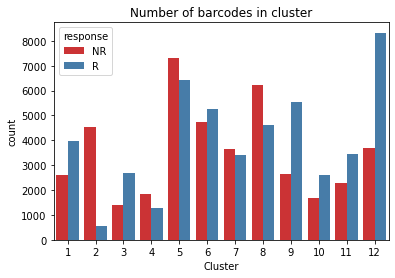

In [302]:
filtered_merged_df = clustering_tsne_merged_df[clustering_tsne_merged_df.Sample.isin(list(set(melanoma_clinical_data.PatientId)))]
filtered_merged_df['response'] = filtered_merged_df.Sample.apply(lambda x: res_melanoma_clinical_data.loc[x].response)

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='response', data=filtered_merged_df, palette="Set1")
ax.set(title='Number of barcodes in cluster')
ax.get_figure().savefig(join(OUTPUT_PATH, r'sizes_per_response.jpg'))

# M13. overlap of 10 CD10 clusters with 2 CD8 clusters:

1. memory

2. exhausted

In [40]:
CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
exh_mem_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'


ext_clustering_mapping = pd.read_csv(CD8_CLUSTERING_PATH)
abs_clustering_mapping = pd.read_csv(exh_mem_CD8_CLUSTERING_PATH)

In [41]:
m_df = ext_clustering_mapping.merge(abs_clustering_mapping.rename(columns={'Cluster':'mem_exh'}))


In [42]:
c_count_df = m_df.groupby(['Cluster', 'mem_exh']).count().reset_index()
t_count_df = m_df.groupby(['Cluster']).count()

In [43]:
t_count_df
c_count_df['Total'] = c_count_df.apply(lambda x: t_count_df.loc[x.Cluster].Barcode,axis=1)
c_count_df['%'] = c_count_df['Sample'] / c_count_df['Total']

In [68]:
c_count_df

Cluster  mem_exh  Sample  Barcode  Total         %
0         1        1    4558     4558   5401  0.843918
1         1        2     843      843   5401  0.156082
2         2        1     189      189   2315  0.081641
3         2        2    2126     2126   2315  0.918359
4         3        1     953      953   1542  0.618029
5         3        2     589      589   1542  0.381971
6         4        1    4262     4262   4263  0.999765
7         4        2       1        1   4263  0.000235
8         5        1    4913     4913   4933  0.995946
9         5        2      20       20   4933  0.004054
10        6        2    5872     5872   5872  1.000000
11        7        1      29       29   3677  0.007887
12        7        2    3648     3648   3677  0.992113
13        8        1     276      276   3968  0.069556
14        8        2    3692     3692   3968  0.930444
15        9        1    1576     1576   5577  0.282589
16        9        2    4001     4001   5577  0.717411
17       10        1     392      392   4663  0.084066
18       10        2    4271     4271   4663  0.915934

In [69]:
c_count_df.sort_values('%', ascending=False).groupby('Cluster').head(1)[['Cluster', 'mem_exh', '%']].sort_values('Cluster').reset_index(drop=True)

Cluster  mem_exh         %
0        1        1  0.843918
1        2        2  0.918359
2        3        1  0.618029
3        4        1  0.999765
4        5        1  0.995946
5        6        2  1.000000
6        7        2  0.992113
7        8        2  0.930444
8        9        2  0.717411
9       10        2  0.915934

# M14. tSNE of entire cohort

In [72]:
TSNE_PATH = r'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/entire_cohort/immune_bhtsne_5.5.22.csv'
tsne_df = pd.read_csv(TSNE_PATH)

In [73]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [82]:
TSNE_PATH = r'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/entire_cohort/immune_bhtsne_5.5.22.pkl'
tsne_embedded = pickle.load(open(TSNE_PATH, 'rb'))

In [90]:
cell_types = cohort.get_cancer_immune_stroma_map()[1]

In [96]:
tsne_embedded[1:5, 0]

array([-13.16629641, -11.01738063,  -4.19565998, -13.45501487])

In [105]:
list(set(cell_types))

['is_stroma', 'is_cancer', 'is_immune']

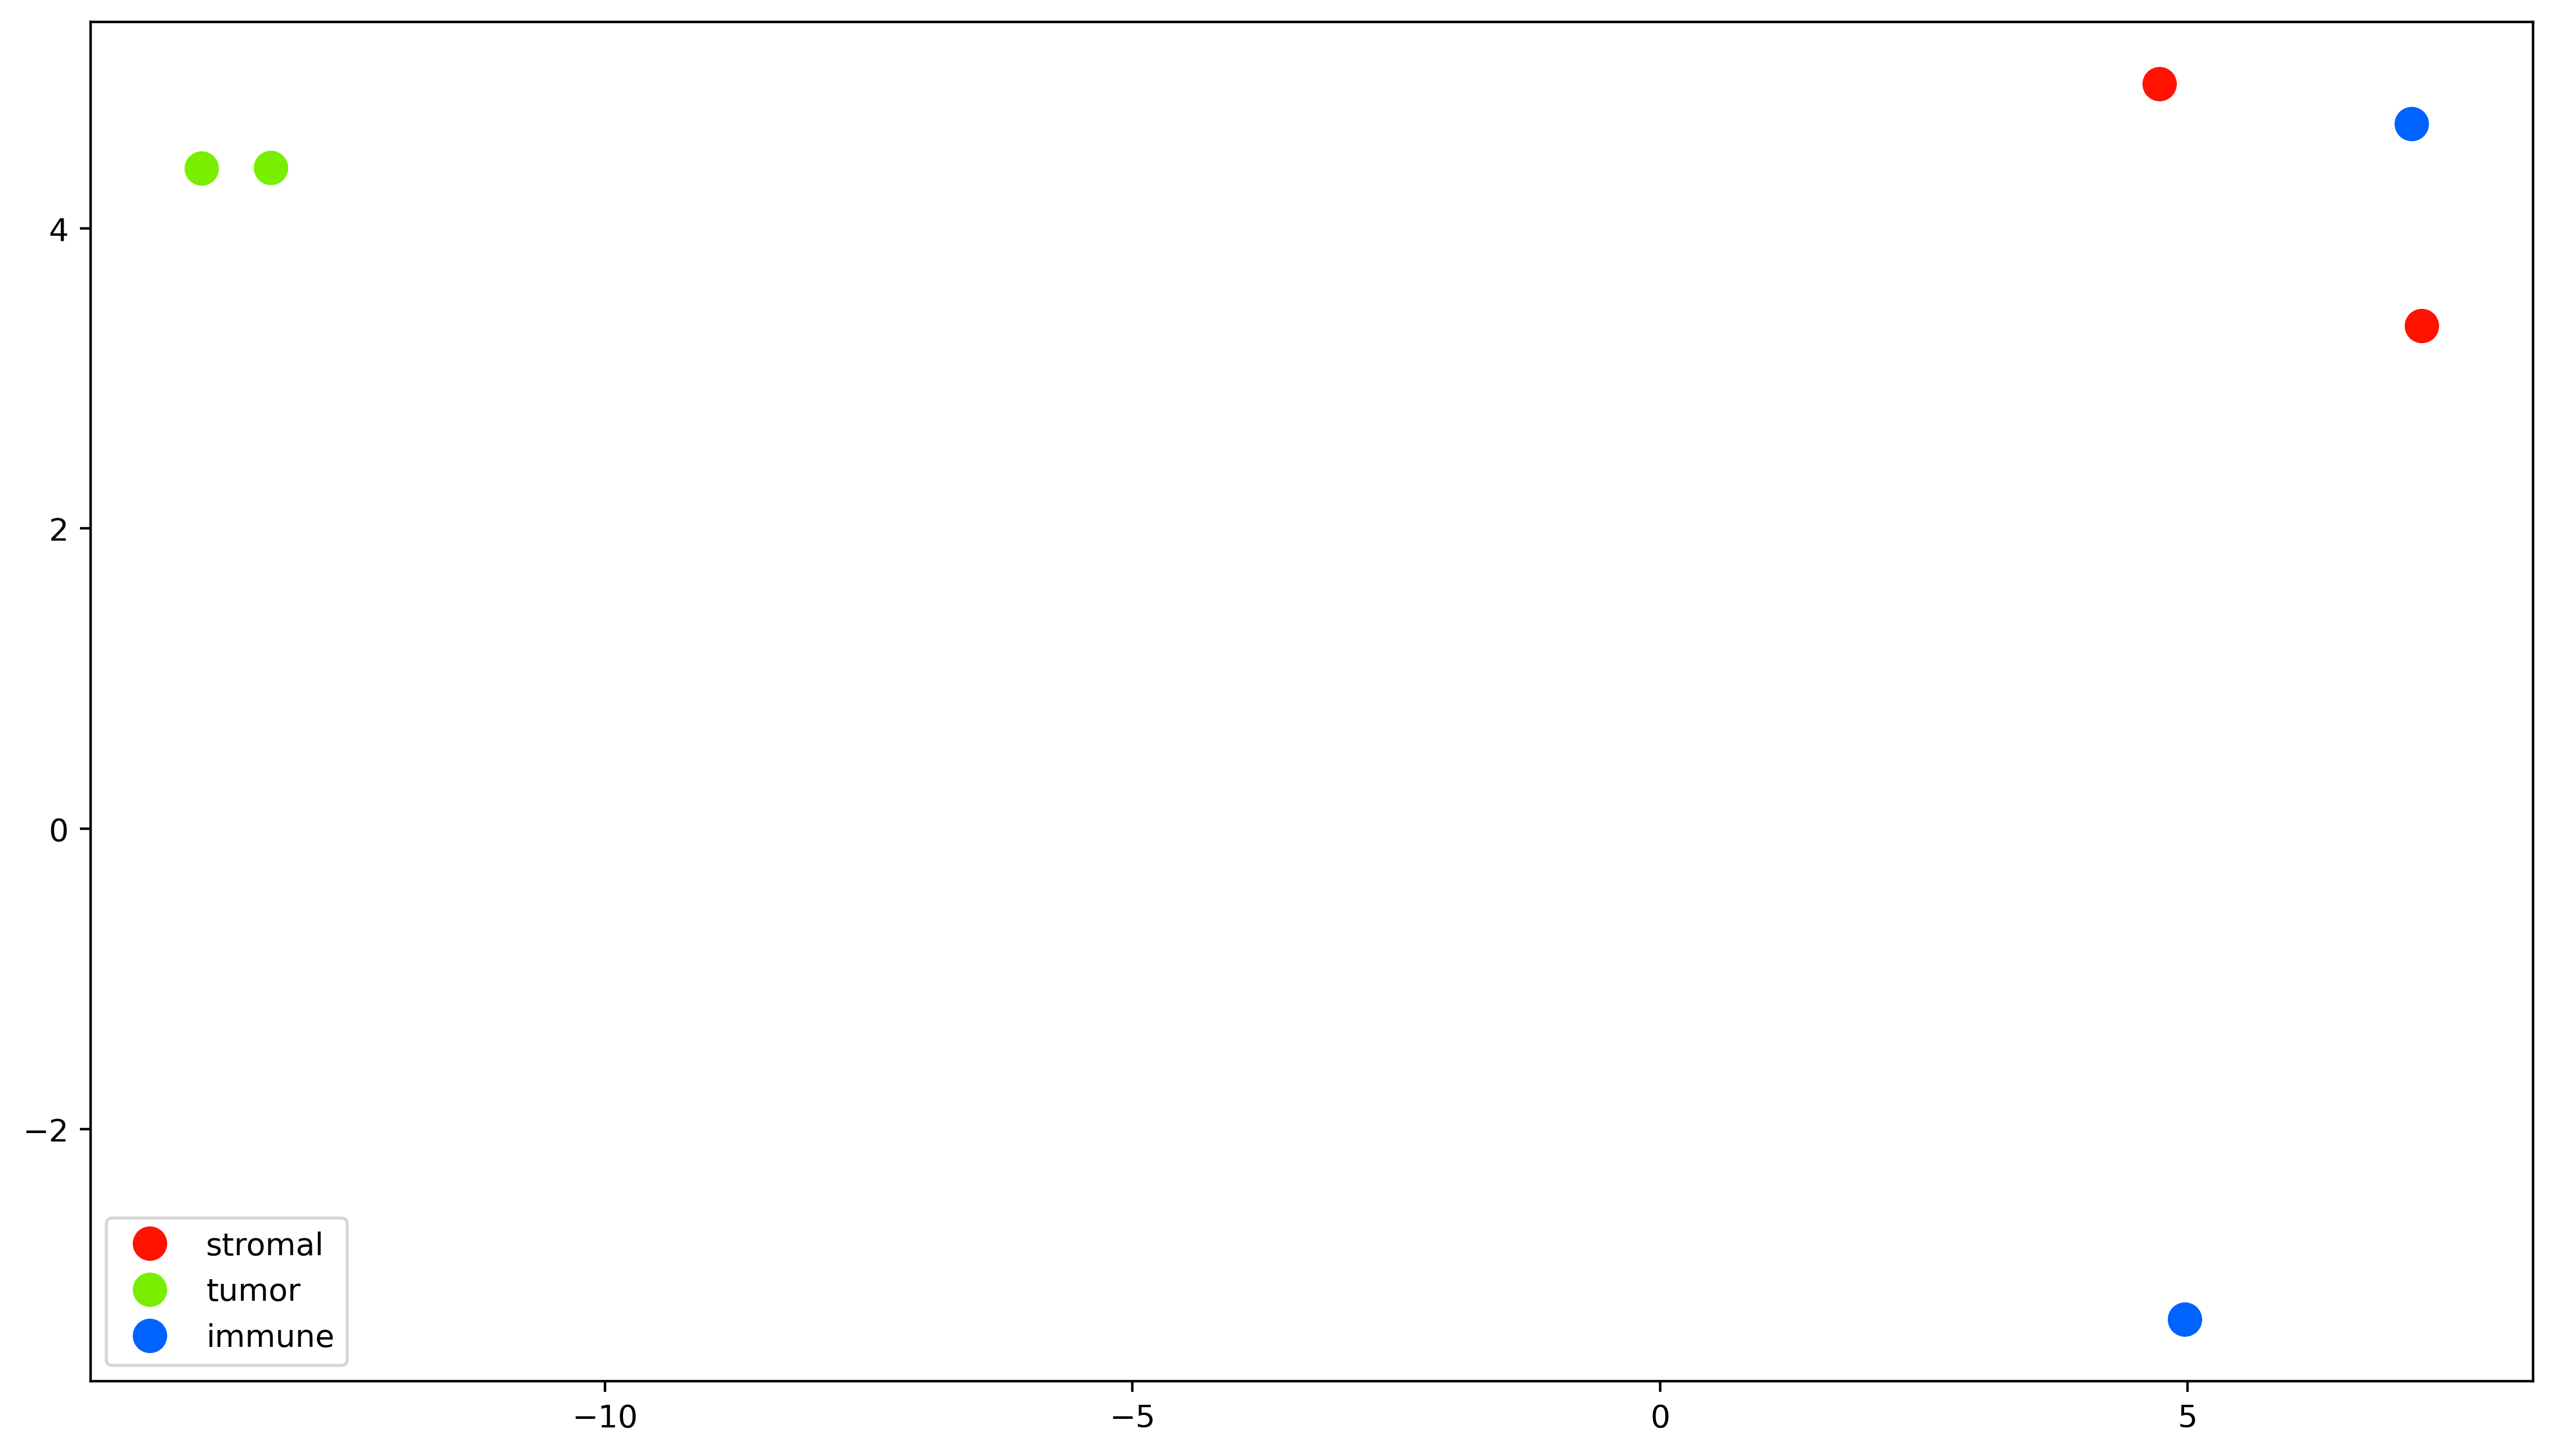

In [118]:
plt.rcParams["figure.figsize"] = 14, 8
colors = np.array([plt.cm.gist_ncar(i) for i in np.linspace(0, 0.9,100)])[[80, 45,  15]]  #[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]


for idx, cell_type in enumerate(list(set(cell_types))):
    Xi = tsne_embedded[[cc==cell_type for cc in cell_types], 0][:2]
    Yi = tsne_embedded[[cc==cell_type for cc in cell_types], 1][:2]
    def fff(ss):
        if ss=='is_cancer':
            return 'is_tumor'
        if ss=='is_stroma':
            return 'is_stromal'
        return ss
    cell_type = fff(cell_type)
    plt.plot(Xi, Yi, 'ro', color=colors[idx], label=cell_type[3:], markersize=10, linestyle='')

plt.legend();
# plt.title('d');
# plt.show()
OUTPUT_PATH = r'/storage/md_keren/shitay/outputs/thesis/cohort'
plt.savefig(join(OUTPUT_PATH, r'tSNE_labels.jpg'))

# DEBUG

In [54]:
df[['first', 'second']].apply(frozenset, axis=1)

0      (B, A)
1    (A1, B1)
2      (C, D)
3      (F, E)
4      (H, G)
5      (J, I)
6      (K, L)
dtype: object

In [51]:
df = pd.DataFrame({
                   'first': ['A', 'A1', 'D', 'E', 'G', 'I', 'K'],
                   'second': ['B', 'B1', 'C', 'F', 'H', 'J', 'L'],
                   'key': ['AB', 'AB', 'CD', 'EF', 'GH', 'IJ', 'KL'],
                   'max registered': [10, 10, 15, 10, 'NaN', 'NaN', 15]
                 })
df

first second key max registered
0     A      B  AB             10
1    A1     B1  AB             10
2     D      C  CD             15
3     E      F  EF             10
4     G      H  GH            NaN
5     I      J  IJ            NaN
6     K      L  KL             15

In [50]:
out = df.assign(group=df[['first', 'second']].apply(frozenset, axis=1)).sort_values('max registered', ascending=False).groupby('group').head(1).sort_index()

TypeError: '<' not supported between instances of 'str' and 'int'

In [14]:
ddd = clustering_mapping.groupby(['Sample', 'Cluster']).count().reset_index()

In [25]:
ddd[ddd.Cluster == 4]

Sample  Cluster  Barcode
65    M111        4     1450
84    M114        4       12
99    M116        4        7
142   M124        4        2
183   M130        4       61
191   M131        4        1
207   M134        4        4
280   M145        4        2
287   M146        4        1
335   M152        4        1
410   M162        4        1
425   M164        4        2
433   M167        4     1108
444   M168        4      119
460   M170        4      444

In [19]:
ddd[ddd.Sample == 'M168'].Barcode.sum()

1826

In [26]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [28]:
[g for g in cohort.gene_names if g.startswith('HEXA')]
# [g for g in cohort.features if g.startswith('ENSG00000120215')]
# cohort.number_of_genes

['HEXA', 'HEXA-AS1']

In [ ]:
df = ddd.iloc[:, :]

# colors = ['darkred', 'yellow', 'tomato', 'orange', 'bisque', 'aqua', 'powderblue', 'violet', 'purple',
#       '#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
# fields = df.columns.tolist()

# # figure and axis
# fig, ax = plt.subplots(1, figsize=(12, 10))
# # plot bars
# left = len(df) * [0]
# for idx, name in enumerate(fields):
#     plt.barh(df.index, df[name], left=left, color=colors[idx])
#     left = left + df[name]
#     # title and subtitle
#     plt.title(title, loc='left')
#     plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
#     # legend
#     plt.legend(labels, bbox_to_anchor=([-0.1, 1, 0, 0]), ncol=1, frameon=False)
#     # remove spines
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     # format x ticks
#     xticks = np.arange(0, 1.1, 0.1)
#     xlabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
#     plt.xticks(xticks, xlabels)
#     # adjust limits and draw grid lines
#     plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
#     ax.xaxis.grid(color='gray', linestyle='dashed')
# plt.show()

In [21]:
# ddd = immune_cluster_fraction.pivot_table(index='sample', columns='cluster')

# ddd.columns = ddd.columns.get_level_values(1)
# ddd = ddd.sort_values(1)
# ddd.head()

# # variables
# labels = list(range(1,13))#['NA', 'EU', 'JP', 'Others']
# colors = ['darkred', 'yellow', 'tomato', 'orange', 'bisque', 'aqua', 'powderblue', 'violet', 'purple',
#           '#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
# title = 'Immune clusters\n'
# subtitle = 'Fraction of cells per patient'

# plot_stackedbar_p(ddd, labels, colors, title, subtitle)


In [27]:
melanoma_clinical_data = get_interpreted_clinical_table(ICI=False,
#                                                         response=['R', 'NR'],
#                                                         melanomaType=['Cutaneous', 'Mucosal', 'Uveal', 'UN primary'], 
                                                        treatment=None)
print(len(melanoma_clinical_data))
# melanoma_clinical_data[~melanoma_clinical_data.ICI]
# melanoma_clinical_data
Counter(melanoma_clinical_data.MelanomaType)

71


Counter({'Cutaneous': 49,
         'Mucosal': 8,
         'Unknown': 3,
         'Uveal': 4,
         'Acral': 2,
         'UN primary': 5})

In [47]:
pd.set_option('display.max_rows', None)

melanoma_clinical_data = get_interpreted_clinical_table(ICI=True, treatment=None, response=['R', 'NR'])
# Counter(melanoma_clinical_data['MelanomaType'])
# melanoma_clinical_data

In [40]:
ddd = get_clinical_data(71,therapy_translator=seperate_IPI_from_NIVO_translator, additional_features=['Therapy(ies) prior to biopsy', 'Therapy after biopsy', 'Biopsy type (pre, post)'], time_translator=pre_pro_translator)
ddd.to_excel(r'/storage/md_keren/shitay/garbage/validate_clinical_table.xlsx')

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


In [2]:
cutaneous_melanoma_clinical_data = get_clinical_data(n_samples=71, ICI=True, melanoma_type=['Cutaneous'], therapy_translator=seperate_IPI_from_NIVO_translator, additional_features=['Biopsy type (pre, post)'], time_translator=pre_pro_translator)
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['response'] != 'not in use for now']                    
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data.drop(columns=['ICI', 'BRAF', 'Biopsy type (pre, post)']).reset_index(drop=True).rename(columns={'prior to biopsy':'treatment_before', 'after biopsy':'treatment_after'})

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


In [3]:
cutaneous_melanoma_clinical_data['treatment'] = cutaneous_melanoma_clinical_data.apply(lambda x: x.treatment_after if x['pre/post']=='Pre' else x.treatment_before, axis=1)

NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO']
IPI_NIVO_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.treatment=='NIVO + IPI']



IPI_NIVO_Pre_cutaneous_melanoma_clinical_data = IPI_NIVO_cutaneous_melanoma_clinical_data[IPI_NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Pre']
IPI_NIVO_Post_cutaneous_melanoma_clinical_data = IPI_NIVO_cutaneous_melanoma_clinical_data[IPI_NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Post']

NIVO_Pre_cutaneous_melanoma_clinical_data = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Pre']
NIVO_Post_cutaneous_melanoma_clinical_data = NIVO_cutaneous_melanoma_clinical_data[NIVO_cutaneous_melanoma_clinical_data['pre/post'] == 'Post']

In [ ]:
cutaneous_melanoma_clinical_data

In [126]:
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]

In [133]:
def plot_stackedbar_p2(df, labels, title, subtitle, file_path=None, colors=[]):
    if not len(colors):
        colors = ['darkred', 'yellow', 'tomato', 'orange', 'bisque', 'aqua', 'powderblue', 'violet', 'purple',
          '#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
    fields = df.columns.tolist()

    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
    # plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left=left, color=colors[idx])
        left = left + df[name]
        # title and subtitle
        plt.title(title, loc='left')
        plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
        # legend
        # plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=4, frameon=False)
        plt.legend(labels, bbox_to_anchor=([-0.1, 1, 0, 0]), ncol=1, frameon=False)

        # remove spines
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # format x ticks
        xticks = np.arange(0, 1.1, 0.1)
        xlabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
        plt.xticks(xticks, xlabels)
        # adjust limits and draw grid lines
        plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
        ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.show()
    if file_path:
        fig.savefig(file_path)


In [20]:
# idx = 0
# for clustering_name, clustering_inf in cluster_inf_dic.items():
#     idx +=1
#     if idx ==1:
#         cluster_fraction = clustering_inf[0]
#         annotation_df = clustering_inf[1]
    
# labels = [f'{idx+1}. {label}'  for idx,label in enumerate(annotation_df.annotation.tolist())]
# plot_stackedbar_p2(cluster_fraction, labels, title=f'{clustering_name} clusters\n', 
#                   subtitle='Fraction of cells per patient', colors=colors) 
# #                   file_path=join(OUTPUT_FOLDER, f'{clustering_name}_sample_fractions.png'))


In [22]:
G1 = list(np.zeros(7)) + [10]
G2 = list(np.zeros(1)) + [1,2,3,11]
G2 = [1,11]


_, pval = ranksums(G1, G2)
pval

0.06757726305587054

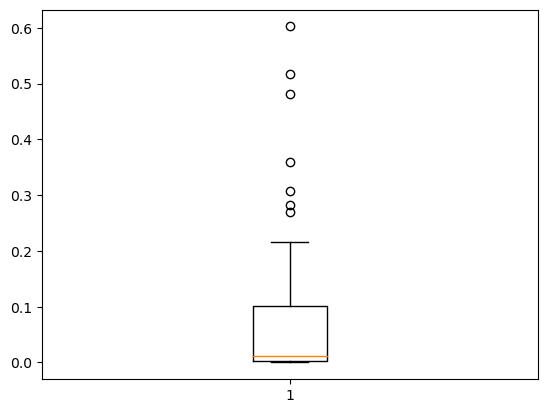

In [100]:
gene_name = 'AXL'
# gene_name = 'MLANA'


gene_threshold = 1

##########################
pd.set_option('display.max_rows', None)
plt.rcdefaults()  # reset params
##########################

gene_idx = tumor_cohort.gene_names.index(gene_name)
df = pd.DataFrame(np.array([tumor_cohort.samples, tumor_cohort.counts[:,gene_idx]]).T, columns=['sample', 'exp'])
df.exp = df.exp.astype(float) > gene_threshold
d1 = df.groupby('sample').sum().reset_index()
d2 = df.groupby('sample').count().reset_index()

merged_df = d1.merge(d2, left_on='sample', right_on='sample')
merged_df['%'] = merged_df.exp_x / merged_df.exp_y

merged_df.sort_values('%')
plt.boxplot(merged_df['%']);

In [144]:

def get_percent_gene(cohort, gene_name):
    gene_idx = cohort.gene_names.index(gene_name)
    df = pd.DataFrame(np.array([cohort.samples, cohort.counts[:,gene_idx]]).T, columns=['sample', 'exp'])
    df.exp = df.exp.astype(float) > gene_threshold
    d1 = df.groupby('sample').sum().reset_index().rename(columns={'exp':f'c_{gene_name}'})
    d2 = df.groupby('sample').count().reset_index().rename(columns={'exp':'general_count'})

    merged_df = d1.merge(d2, left_on='sample', right_on='sample')
    merged_df[f'p_{gene_name}'] = merged_df[f'c_{gene_name}'] / merged_df.general_count
    return merged_df.drop(columns=['general_count'])

def get_percent_genes(cohort, genes):
    df = get_percent_gene(cohort, genes[0])
    for gene in genes[1:]:
        df = df.merge(get_percent_gene(cohort, gene), left_on='sample', right_on='sample')
    return df
# get_percent_gene(tumor_cohort, 'MLANA').merge(f(tumor_cohort, 'AXL'), left_on='sample', right_on='sample')



In [178]:
# df

In [99]:
get_arranged_GEP_fraction_df()

TypeError: get_GEP_fraction_df() takes 0 positional arguments but 1 was given

In [78]:
GEP_fration = get_GEP_fraction_df(GEP_all_samples_df)

In [89]:
GEP_fration.rename(columns={'program':'cluster'})
GEP_fration.head()

sample  program  sample_fraction Response treatment
0   M100        1              0.0       NR  anti-PD1
1   M100        2              0.0       NR  anti-PD1
2   M100        3              0.0       NR  anti-PD1
3   M100        4              0.0       NR  anti-PD1
4   M100        5              0.0       NR  anti-PD1

In [40]:
immune_cluster_fraction
# ddd = get_GEP_fraction_df(GEP_all_samples_df)

sample  cluster  sample_fraction Response              treatment
0     M100        1         0.016854       NR               anti-PD1
1     M100        2         0.005618       NR               anti-PD1
2     M100        3         0.011236       NR               anti-PD1
3     M100        4         0.213483       NR               anti-PD1
4     M100        5         0.325843       NR               anti-PD1
..     ...      ...              ...      ...                    ...
847    M99        8         0.226356       NR  anti-PD1 + anti-CTLA4
848    M99        9         0.091439       NR  anti-PD1 + anti-CTLA4
849    M99       10         0.017929       NR  anti-PD1 + anti-CTLA4
850    M99       11         0.193635       NR  anti-PD1 + anti-CTLA4
851    M99       12         0.013895       NR  anti-PD1 + anti-CTLA4

[588 rows x 5 columns]